<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modelling" data-toc-modified-id="Modelling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#ADF,-KPSS-test" data-toc-modified-id="ADF,-KPSS-test-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>ADF, KPSS test</a></span></li><li><span><a href="#ACF-and-PACF" data-toc-modified-id="ACF-and-PACF-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>ACF and PACF</a></span></li></ul></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Changing-train-data---forecast-5-days" data-toc-modified-id="Changing-train-data---forecast-5-days-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Changing train data - forecast 5 days</a></span></li></ul></li><li><span><a href="#Training-rolling-ARIMA-1,0,1" data-toc-modified-id="Training-rolling-ARIMA-1,0,1-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training rolling ARIMA 1,0,1</a></span></li><li><span><a href="#Training-without-rolling-ARIMA-1,0,1" data-toc-modified-id="Training-without-rolling-ARIMA-1,0,1-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training without rolling ARIMA 1,0,1</a></span></li><li><span><a href="#Training-ARIMA-1,1,1" data-toc-modified-id="Training-ARIMA-1,1,1-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training ARIMA 1,1,1</a></span></li><li><span><a href="#SARIMAX-(1,-0,-1)-(1,-0,-1,-7)" data-toc-modified-id="SARIMAX-(1,-0,-1)-(1,-0,-1,-7)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>SARIMAX (1, 0, 1) (1, 0, 1, 7)</a></span></li><li><span><a href="#SARIMAX" data-toc-modified-id="SARIMAX-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>SARIMAX</a></span></li></ul></div>

In [22]:
import requests
# import pprint
import csv
from datetime import datetime, timedelta
import logging
import os
import logging.handlers

# Data analysis
import pandas as pd
import numpy as np

# Data Visualization
# import matplotlib.pyplot as plt 
# import seaborn as sns
# import plotly.express as px 

# Time Series
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from pmdarima import auto_arima
# import statsmodels.api as sm

# For printing multiple outputs
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Visualization parameters
# sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
# sns.set_context('notebook')
# sns.set_style("ticks")
# from IPython.display import set_matplotlib_formats
# %config InlineBackend.figure_format = 'retina'

# Metrics for model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# NISE
NISE = "nise gwal"
NISE_STATION = "NISE Gwal Pahari, Gurugram, India"
NISE_OUTPUT = "../../data/cron_job_data/nise_cron_output"

# Sector 51
SECTOR_51 = "Sector-51, Gurugram"
SECTOR_51_STATION = "Sector-51, Gurugram, India"
SECTOR_51_OUTPUT = "../../data/cron_job_data/sector_51_cron_output"
SECTOR_51_DAILY_AQI = '../../data/cleaned_data/Forecasting_time_series/sector_51_daily_aqi.csv'

# Teri gram
TERI_GRAM = "Teri Gram"
TERI_GRAM_STATION = "Teri Gram, Gurugram"
TERI_GRAM_OUTPUT = "../../data/cron_job_data/teri_gram_cron_output"

# Vikas Sadan
VIKAS_SADAN = "Vikas Sadan"
VIKAS_SADAN_STATION = "Vikas Sadan Gurgaon"
VIKAS_SADAN_OUTPUT = "../../data/cron_job_data/vikas_sadan_cron_output"

stations = [(NISE,  NISE_OUTPUT), (SECTOR_51, SECTOR_51_OUTPUT), (TERI_GRAM, TERI_GRAM_OUTPUT), (VIKAS_SADAN, VIKAS_SADAN_OUTPUT)]

# We have selected best model based on different combinations - See Modelling block below
ORDER, SEASONAL_ORDER = (1, 0, 1), (1, 0, 1, 7)
FORECAST_SECTOR_51_DAILY_AQI = '../../data/cleaned_data/Forecasting_time_series/forecast_sector_51_daily_aqi.csv'

def get_api_token():
    '''
    This function fetches the AQI token.
    '''
    try:
        return os.environ['API_TOKEN']
    except KeyError:
        print("KeyError")
         # If running locally, use an alternative method to get the API token
        return input("Enter your API token: ")
    
# Incase if api fails, write to file with previous day
# In 2nd cron daily job, Incase if api fails, write to file with previous day

def setData(station, output_file, logger, TOKEN):
    '''
    This function is called hourly once. 
    It fetches the real-time hourly AQI data for 4 stations and writes to the hourly csv files.
    This data is consumed by writeData function.
    '''
    
    try:
        # Get the API response
        url = "https://api.waqi.info/search/?token=" + TOKEN + "&keyword=" + station
        response = requests.get(url)
        if response.status_code == 200:
            res = response.json()
            result = []
            if station.lower() in (res["data"][0]['station']['name']).lower():
                result.append(res["data"][0]['aqi'])
                result.append(res["data"][0]['station']['name'])
                result.append(pd.to_datetime(res["data"][0]['time']['stime']))
            logger.info(f"station=> {station}, result => {result}")
            print(f"station=> {station}, result => {result}")
            
            # If AQI is not a number, dont write it and return
            try:
                int(result[0])
            except Exception as exception:
                logger.info(f"setData function - AQI is not an integer. Exception {type(exception).__name__} has occured for station=> {station}")
                return
            
            # Write to the file only when (station, time) is not already existing in the file.

            new_timestamp = (res["data"][0]['time']['stime'])
            csv_file_path = output_file + '.csv'

            # Check if the new timestamp is already present
            with open(csv_file_path, 'r') as csv_file:
                csv_reader = csv.reader(csv_file)
                # Assuming the timestamp is in the 3rd column
                existing_timestamps = [row[2] for row in csv_reader]

            if new_timestamp not in existing_timestamps:
                with open(csv_file_path, 'a', newline='') as csv_file:
                    csv_writer = csv.writer(csv_file)
                    csv_writer.writerow(result)
                print(f'The hourly data has been written to {csv_file_path} with Timestamp: {new_timestamp}')
                logger.info(f'The hourly data has been written to {csv_file_path} with Timestamp: {new_timestamp}')
            else:
                print(f'Timestamp {new_timestamp} already present in {csv_file_path}, not appending.')
                logger.info(f'Timestamp {new_timestamp} already present in {csv_file_path}, not appending.')
        else:
            print(f"setData function - Error: {response.status_code} - {response.text}")
            logger.info(f"setData function - Error: {response.status_code} - {response.text}")
    except Exception as e:
        print(f"setData function - Exception {type(e).__name__} has occured for station=> {station}")
        logger.info(f"setData function - Exception {type(e).__name__} has occured for station=> {station}")

def setLogger():
    '''
    This function sets the logger to the logs directory.
    Every day, a new file gets created.
    '''
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    logger_file_handler = logging.handlers.RotatingFileHandler(
        f"logs/{datetime.now().strftime('%d-%m-%Y')}.log",
        maxBytes=1024 * 1024,
        backupCount=1,
        encoding="utf8",
    )
    formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    logger_file_handler.setFormatter(formatter)
    logger.addHandler(logger_file_handler)
    return logger

def writeData(station_hourly_aqi, station_daily_aqi):
    '''
    This function is called daily once at 1 AM. 
    It preprocesses the data, computes the daily AQI from hourly AQI csv files and writes to the daily csv files.
    This data is consumed by retrain_model function.
    '''
    # Hourly data preprocessing
    df_api = pd.read_csv(station_hourly_aqi + ".csv")
    df_api['Time'] = pd.to_datetime(df_api['Time'])
    df_api.set_index('Time', inplace=True)
    df_api = df_api['AQI'].resample('D').mean()
    df_api = pd.DataFrame(df_api)
    print(f"df_api columns {df_api.columns}")
    logger.info(f"df_api columns {df_api.columns}")
    df_api['AQI'] = round(df_api['AQI'])

    today = datetime.now().date()
    yesterday = today - timedelta(days=1)

    # Write it to the Daily data csv file
    temp_daily_aqi = pd.read_csv(station_daily_aqi)
    print(f'temp_daily_aqi columns {temp_daily_aqi.columns}')
    logger.info(f'temp_daily_aqi columns {temp_daily_aqi.columns}')
                
    temp_daily_aqi['Date'] = pd.to_datetime(temp_daily_aqi['Date'])
    temp_daily_aqi.set_index('Date', inplace=True)

    print(f"temp_daily_aqi[{yesterday}]=> {temp_daily_aqi[yesterday:yesterday]}")
    logger.info(f"temp_daily_aqi[{yesterday}]=> {temp_daily_aqi[yesterday:yesterday]}")
    
    try:
        with open(station_daily_aqi, 'a', newline='') as csv_file:
            if len(temp_daily_aqi[yesterday:yesterday]) == 0: # Write only if it does not exist already
                csv_writer = csv.writer(csv_file)
                index = temp_daily_aqi.iloc[-1,0] + 1 # Add 1 to yesterday's index
                aqi = df_api[yesterday:yesterday].AQI.values[0]
                print(f'Index => {index}, yesterday => {yesterday} & AQI => {aqi}')
                logger.info(f'Index => {index}, yesterday => {yesterday} & AQI => {aqi}')
                if np.isnan(df_api[yesterday:yesterday].AQI.values[0]): # If NaN, take yesterday's value.
                    aqi = temp_daily_aqi.iloc[-1,2]
                csv_writer.writerow([index, yesterday, aqi])
                print(f'Daily AQI data has been written to {station_daily_aqi}')
                logger.info(f'Daily AQI data has been written to {station_daily_aqi}')
    except Exception as e:
        print(f"writeData function - Exception {type(e).__name__} has occured for station=> {station_daily_aqi}")
        logger.info(f"writeData function - Exception {type(e).__name__} has occured for station=> {station_daily_aqi}")

def retrain_model(order, seasonal_order, station_daily_aqi):
    '''
    This function is called daily once at 1 AM. 
    It takes into account today's AQI and re-trains the model.
    We check the model's performance by splitting data into train & test data, then train the model and calculate MAPE.
    If MAPE is <= 30%, we consider entire data (no splitting into train & test) and re-train our model & forecast for the next 5 days.
    Else if MAPE is > 30%, an email is sent to myself (Pranay Bomma) to manually look into the model and fix it.
    '''

    # Read the data & clean it.
    daily_aqi = pd.read_csv(station_daily_aqi)
    daily_aqi['Date'] = pd.to_datetime(daily_aqi['Date'])
    daily_aqi.set_index('Date', inplace=True)
    daily_aqi.drop(columns=['Unnamed: 0'], inplace=True)
    daily_aqi.index = pd.to_datetime(daily_aqi.index)
    daily_aqi.ffill(inplace=True)

    df = daily_aqi
    
    # Split into train & test
    train_end = df.index[-1] - timedelta(days=5)  # Except last 5 days
    print(f"train_end=> {train_end}")
    logger.info(f'Re-training the model & train_end is {train_end}')
    
    train_data = df.loc[:train_end, 'AQI']
    test_data = df.loc[train_end + timedelta(days=1):, 'AQI']

    # Train the model
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    predictions = model_fit.forecast(len(test_data))
    predictions = pd.Series(predictions, index=test_data.index)
    
    # Calculate MAPE
    MAPE = round(mean_absolute_percentage_error(test_data, predictions) * 100, 2)  # Round it off to two decimal points
    print(f"\n\nMAPE=> {MAPE}")
    logger.info(f'Retrained the model & MAPE is {MAPE}%')

    if (MAPE <= 30):
        # If MAPE is < 30%, forecast next 5 days.
        train_data = df.loc[:, 'AQI']
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()
        predictions = model_fit.forecast(len(test_data))
        predictions = pd.Series(predictions)
        print(f"\n\nForecast=> {predictions}")
        logger.info(f"Forecast=> {predictions}")

        # Save the forecast
        try:
            
            containsNaN = predictions.isna().sum()
            if containsNaN == 0:
                with open(FORECAST_SECTOR_51_DAILY_AQI, 'w', newline='') as csv_file:
                    csv_writer = csv.writer(csv_file)
                    csv_writer.writerow(['Date', 'AQI'])
                    for i in range(5):
                        csv_writer.writerow([predictions.index[i].date(), round(predictions.values[i])])

                    # Log the predictions to view in future.
                    print(f'The forecast data has been written to {FORECAST_SECTOR_51_DAILY_AQI}')
                    logger.info(f'The forecast data has been written to {FORECAST_SECTOR_51_DAILY_AQI}')
            else:
                print(f'retrain_model function - The forecast data has NaNs.')
                logger.info(f'retrain_model function - The forecast data has NaNs.')

        except Exception as e:
            print(f"retrain_model function - Exception {type(e).__name__} has occured.")
            logger.info(f"retrain_model function - Exception {type(e).__name__} has occured.")

    elif (MAPE > 30):
        # record MAPE and send email if it is >30%
        pass
    else:
        # Raise Exception & email - Model is not re-trained.
        print(f"retrain_model function - Model is not retrained. Please look into the issue.")
        logger.info(f"retrain_model function - Model is not retrained. Please look into the issue.")

if __name__ == "__main__":

    # Logging
    logger = setLogger()
    
    # Get API token
    TOKEN = get_api_token()

    for station, station_location in stations:
        setData(station,  station_location, logger, TOKEN)
    
     # If the day changes, append it to original data
    
    if datetime.now().hour == 20:     # It means 1 AM IST (20 is GitHub action runner time)
        writeData(SECTOR_51_OUTPUT, SECTOR_51_DAILY_AQI)
        retrain_model(ORDER, SEASONAL_ORDER, SECTOR_51_DAILY_AQI)
#         for station, station_location in stations:
#             writeData(station_location)

KeyError
Enter your API token: 7c0e1c5a796cf1a14edf4bf1462a99e9b37d8bdf
station=> nise gwal, result => ['117', 'NISE Gwal Pahari, Gurugram, India', Timestamp('2023-12-29 11:00:00')]
The hourly data has been written to ../../data/cron_job_data/nise_cron_output.csv with Timestamp: 2023-12-29 11:00:00
station=> Sector-51, Gurugram, result => ['191', 'Sector-51, Gurugram, India', Timestamp('2023-12-29 11:00:00')]
The hourly data has been written to ../../data/cron_job_data/sector_51_cron_output.csv with Timestamp: 2023-12-29 11:00:00
station=> Teri Gram, result => ['164', 'Teri Gram, Gurugram, India', Timestamp('2023-12-29 11:00:00')]
The hourly data has been written to ../../data/cron_job_data/teri_gram_cron_output.csv with Timestamp: 2023-12-29 11:00:00
station=> Vikas Sadan, result => ['169', 'Vikas Sadan Gurgaon, Gurgaon, India', Timestamp('2023-12-29 11:00:00')]
The hourly data has been written to ../../data/cron_job_data/vikas_sadan_cron_output.csv with Timestamp: 2023-12-29 11:00:00

In [17]:
# Write data
station_hourly_aqi, station_daily_aqi = SECTOR_51_OUTPUT, SECTOR_51_DAILY_AQI
df_api = pd.read_csv(station_hourly_aqi + ".csv")
df_api['Time'] = pd.to_datetime(df_api['Time'])
df_api.set_index('Time', inplace=True)
df_api = df_api['AQI'].resample('D').mean()
df_api = pd.DataFrame(df_api)
print(f"df_api columns {df_api.columns}")
df_api['AQI'] = round(df_api['AQI'])
today = datetime.now().date()
yesterday = today - timedelta(days=1)

temp_daily_aqi = pd.read_csv(station_daily_aqi)
print(f'temp_daily_aqi columns {temp_daily_aqi.columns}')
logger.info(f'temp_daily_aqi columns {temp_daily_aqi.columns}')

temp_daily_aqi['Date'] = pd.to_datetime(temp_daily_aqi['Date'])
temp_daily_aqi.set_index('Date', inplace=True)
temp_daily_aqi
# try:
#     with open(station_daily_aqi, 'a', newline='') as csv_file:
#         if len(temp_daily_aqi[yesterday:yesterday]) == 0: # Write only if it does not exist already
#             csv_writer = csv.writer(csv_file)
#             index = temp_daily_aqi.iloc[-1,0] + 1 # Add 1 to yesterday's index
#             aqi = df_api[yesterday:yesterday].AQI.values[0]
#             if np.isnan(df_api[yesterday:yesterday].AQI.values[0]): # If NaN, take yesterday's value.
#                 aqi = temp_daily_aqi.iloc[-1,2]
#             csv_writer.writerow([index, yesterday, aqi])
#             logger.info(f'Daily AQI data has been written to {station_daily_aqi}')
# except Exception as e:
#     print(f"writeData function - Exception {type(e).__name__} has occured for station=> {station_daily_aqi}")
#     logger.info(f"writeData function - Exception {type(e).__name__} has occured for station=> {station_daily_aqi}")


df_api columns Index(['AQI'], dtype='object')
temp_daily_aqi columns Index(['Unnamed: 0', 'Date', 'AQI'], dtype='object')


Unnamed: 0    AQI
Date                         
2020-03-05           0   73.0
2020-03-06           1   55.0
2020-03-07           2   78.0
2020-03-08           3  120.0
2020-03-09           4  179.0
...                ...    ...
2023-12-24        1389  244.0
2023-12-25        1390  185.0
2023-12-26        1391  271.0
2023-12-27        1392  236.0
2023-12-28        1393  181.0

[1394 rows x 2 columns]

In [20]:
temp_daily_aqi[yesterday:yesterday]
df_api[yesterday:yesterday]

Unnamed: 0    AQI
Date                         
2023-12-28        1393  181.0

AQI
Time             
2023-12-28  179.0

In [49]:
train_data = df.loc[:, 'AQI']
model = SARIMAX(train_data, order=ORDER, seasonal_order=SEASONAL_ORDER)
model_fit = model.fit()
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
print(f"\n\nForecast=> {predictions}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70295D+00    |proj g|=  1.61432D-01

At iterate    5    f=  5.62268D+00    |proj g|=  7.39977D-04

At iterate   10    f=  5.62186D+00    |proj g|=  2.27188D-03

At iterate   15    f=  5.61878D+00    |proj g|=  1.31866D-02

At iterate   20    f=  5.61424D+00    |proj g|=  3.29944D-03

At iterate   25    f=  5.61365D+00    |proj g|=  5.71950D-03

At iterate   30    f=  5.61307D+00    |proj g|=  2.79821D-03

At iterate   35    f=  5.61273D+00    |proj g|=  1.27206D-04

At iterate   40    f=  5.61271D+00    |proj g|=  8.18904D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [ ]:
predictions[0] == np.nan

In [42]:
def retrain_model(order, seasonal_order, station_daily_aqi):
    
    # Read the data & clean it.
    daily_aqi = pd.read_csv(station_daily_aqi)
    daily_aqi['Date'] = pd.to_datetime(daily_aqi['Date'])
    daily_aqi.set_index('Date', inplace=True)
    daily_aqi.drop(columns=['Unnamed: 0'], inplace=True)
    daily_aqi.index = pd.to_datetime(daily_aqi.index)
    
    df = daily_aqi
    
    # Split into train & test
    train_end = df.index[-1] - timedelta(days=5)  # Except last 5 days
    print(f"train_end=> {train_end}")
    logger.info(f'Re-training the model & train_end is {train_end}')
    
    train_data = df.loc[:train_end, 'AQI']
    test_data = df.loc[train_end + timedelta(days=1):, 'AQI']

    # Train the model
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    predictions = model_fit.forecast(len(test_data))
    predictions = pd.Series(predictions, index=test_data.index)
    
    # Calculate MAPE
    MAPE = round(mean_absolute_percentage_error(test_data, predictions) * 100, 2)  # Round it off to two decimal points
    print(f"\n\nMAPE=> {MAPE}")
    logger.info(f'Retrained the model & MAPE is {MAPE}%')

    if (MAPE <= 30):
        # If MAPE is < 30%, forecast next 5 days.
        train_data = df.loc[:, 'AQI']
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()
        predictions = model_fit.forecast(len(test_data))
        predictions = pd.Series(predictions, index=test_data.index)
        print(f"\n\nForecast=> {predictions}")

        # Save the forecast
        try:
            with open(FORECAST_SECTOR_51_DAILY_AQI, 'w', newline='') as csv_file:
                csv_writer = csv.writer(csv_file)
                csv_writer.writerow(['Date', 'AQI'])
                for i in range(5):
                    csv_writer.writerow([predictions.index[i].date(), predictions.values[i]])

                # Log the predictions to view in future.
                logger.info(f'The forecast data has been written to {FORECAST_SECTOR_51_DAILY_AQI}')

        except Exception as e:
            print(f"Exception {type(e).__name__} has occured for station=> {station}")
            logger.info(f"Exception {type(e).__name__} has occured for station=> {station}")

    elif (MAPE > 30):
        # record MAPE and send email if it is >30%
        pass
    else:
        # Raise Exception & email - Model is not re-trained.
        print(f"Model is not retrained. Please look into the issue.")
        logger.info(f"Model is not retrained. Please look into the issue.")

# Modelling

In [254]:
results = pd.DataFrame(columns=[
    "train_end", "test_end", "p", "d", "q", "P", "D", "Q", "s", "MSE", "MAE", "MAPE", "Rolling?", "AIC", "BIC"
])
results

Empty DataFrame
Columns: [train_end, test_end, p, d, q, P, D, Q, s, MSE, MAE, MAPE, Rolling?, AIC, BIC]
Index: []

In [226]:
def append_to_results(train_end, test_end, p, d, q, P, D, Q, s, actual, predictions, rolling, model, results):
    result = {
        "train_end": [train_end], 
        "test_end": [test_end],
        "p": [p],
        "d": [d],
        "q": [q],
        "P": [P],
        "D": [D],
        "Q": [Q],
        "s": [s],
        "MSE": [round(mean_squared_error(actual, predictions))],
        "MAE": [round(mean_absolute_error(actual, predictions))],
        "MAPE": [mean_absolute_percentage_error(actual, predictions)],
        "Rolling?": [rolling],
        "AIC": [round(model.aic)],
        "BIC": [round(model.bic)]
    }
    results = pd.concat([results, pd.DataFrame.from_dict(result)])
    return results

In [5]:
df = pd.read_csv("../../data/cleaned_data/Forecasting_time_series/sector_51_daily_aqi.csv")
df

Unnamed: 0        Date    AQI
0              0  2020-03-05   73.0
1              1  2020-03-06   55.0
2              2  2020-03-07   78.0
3              3  2020-03-08  120.0
4              4  2020-03-09  179.0
...          ...         ...    ...
1363        1363  2023-11-28  219.0
1364        1364  2023-11-29  326.0
1365        1365  2023-11-30  348.0
1366        1366  2023-12-01  282.0
1367        1367  2023-12-02  326.0

[1368 rows x 3 columns]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1368 entries, 2020-03-05 to 2023-12-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AQI     1368 non-null   float64
dtypes: float64(1)
memory usage: 21.4 KB


In [7]:
df.set_index('Date', inplace=True)

In [8]:
df

Unnamed: 0    AQI
Date                         
2020-03-05           0   73.0
2020-03-06           1   55.0
2020-03-07           2   78.0
2020-03-08           3  120.0
2020-03-09           4  179.0
...                ...    ...
2023-11-28        1363  219.0
2023-11-29        1364  326.0
2023-11-30        1365  348.0
2023-12-01        1366  282.0
2023-12-02        1367  326.0

[1368 rows x 2 columns]

In [10]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1368 entries, 2020-03-05 to 2023-12-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AQI     1368 non-null   float64
dtypes: float64(1)
memory usage: 21.4+ KB


In [12]:
df.index = pd.to_datetime(df.index)

In [14]:
df

AQI
Date             
2020-03-05   73.0
2020-03-06   55.0
2020-03-07   78.0
2020-03-08  120.0
2020-03-09  179.0
...           ...
2023-11-28  219.0
2023-11-29  326.0
2023-11-30  348.0
2023-12-01  282.0
2023-12-02  326.0

[1368 rows x 1 columns]

## ADF, KPSS test

In [119]:
from statsmodels.tsa.stattools import adfuller, kpss

In [16]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print("# lags used", result[2])
    print("critical values", result[4]) 

In [120]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


In [121]:
perform_adf_test(df['AQI'])

ADF Statistic: -3.994049
p-value: 0.001442
# lags used 13
critical values {'1%': -3.4351888040389302, '5%': -2.8636769637158244, '10%': -2.5679077212657284}


In [122]:
kpss_test(df['AQI'])

Results of KPSS Test:
Test Statistic            0.323943
p-value                   0.100000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<Figure size 2000x800 with 0 Axes>

<AxesSubplot: xlabel='Date', ylabel='AQI'>

Text(0.5, 1.0, 'Sector 51 AQI 2020 - 2023')

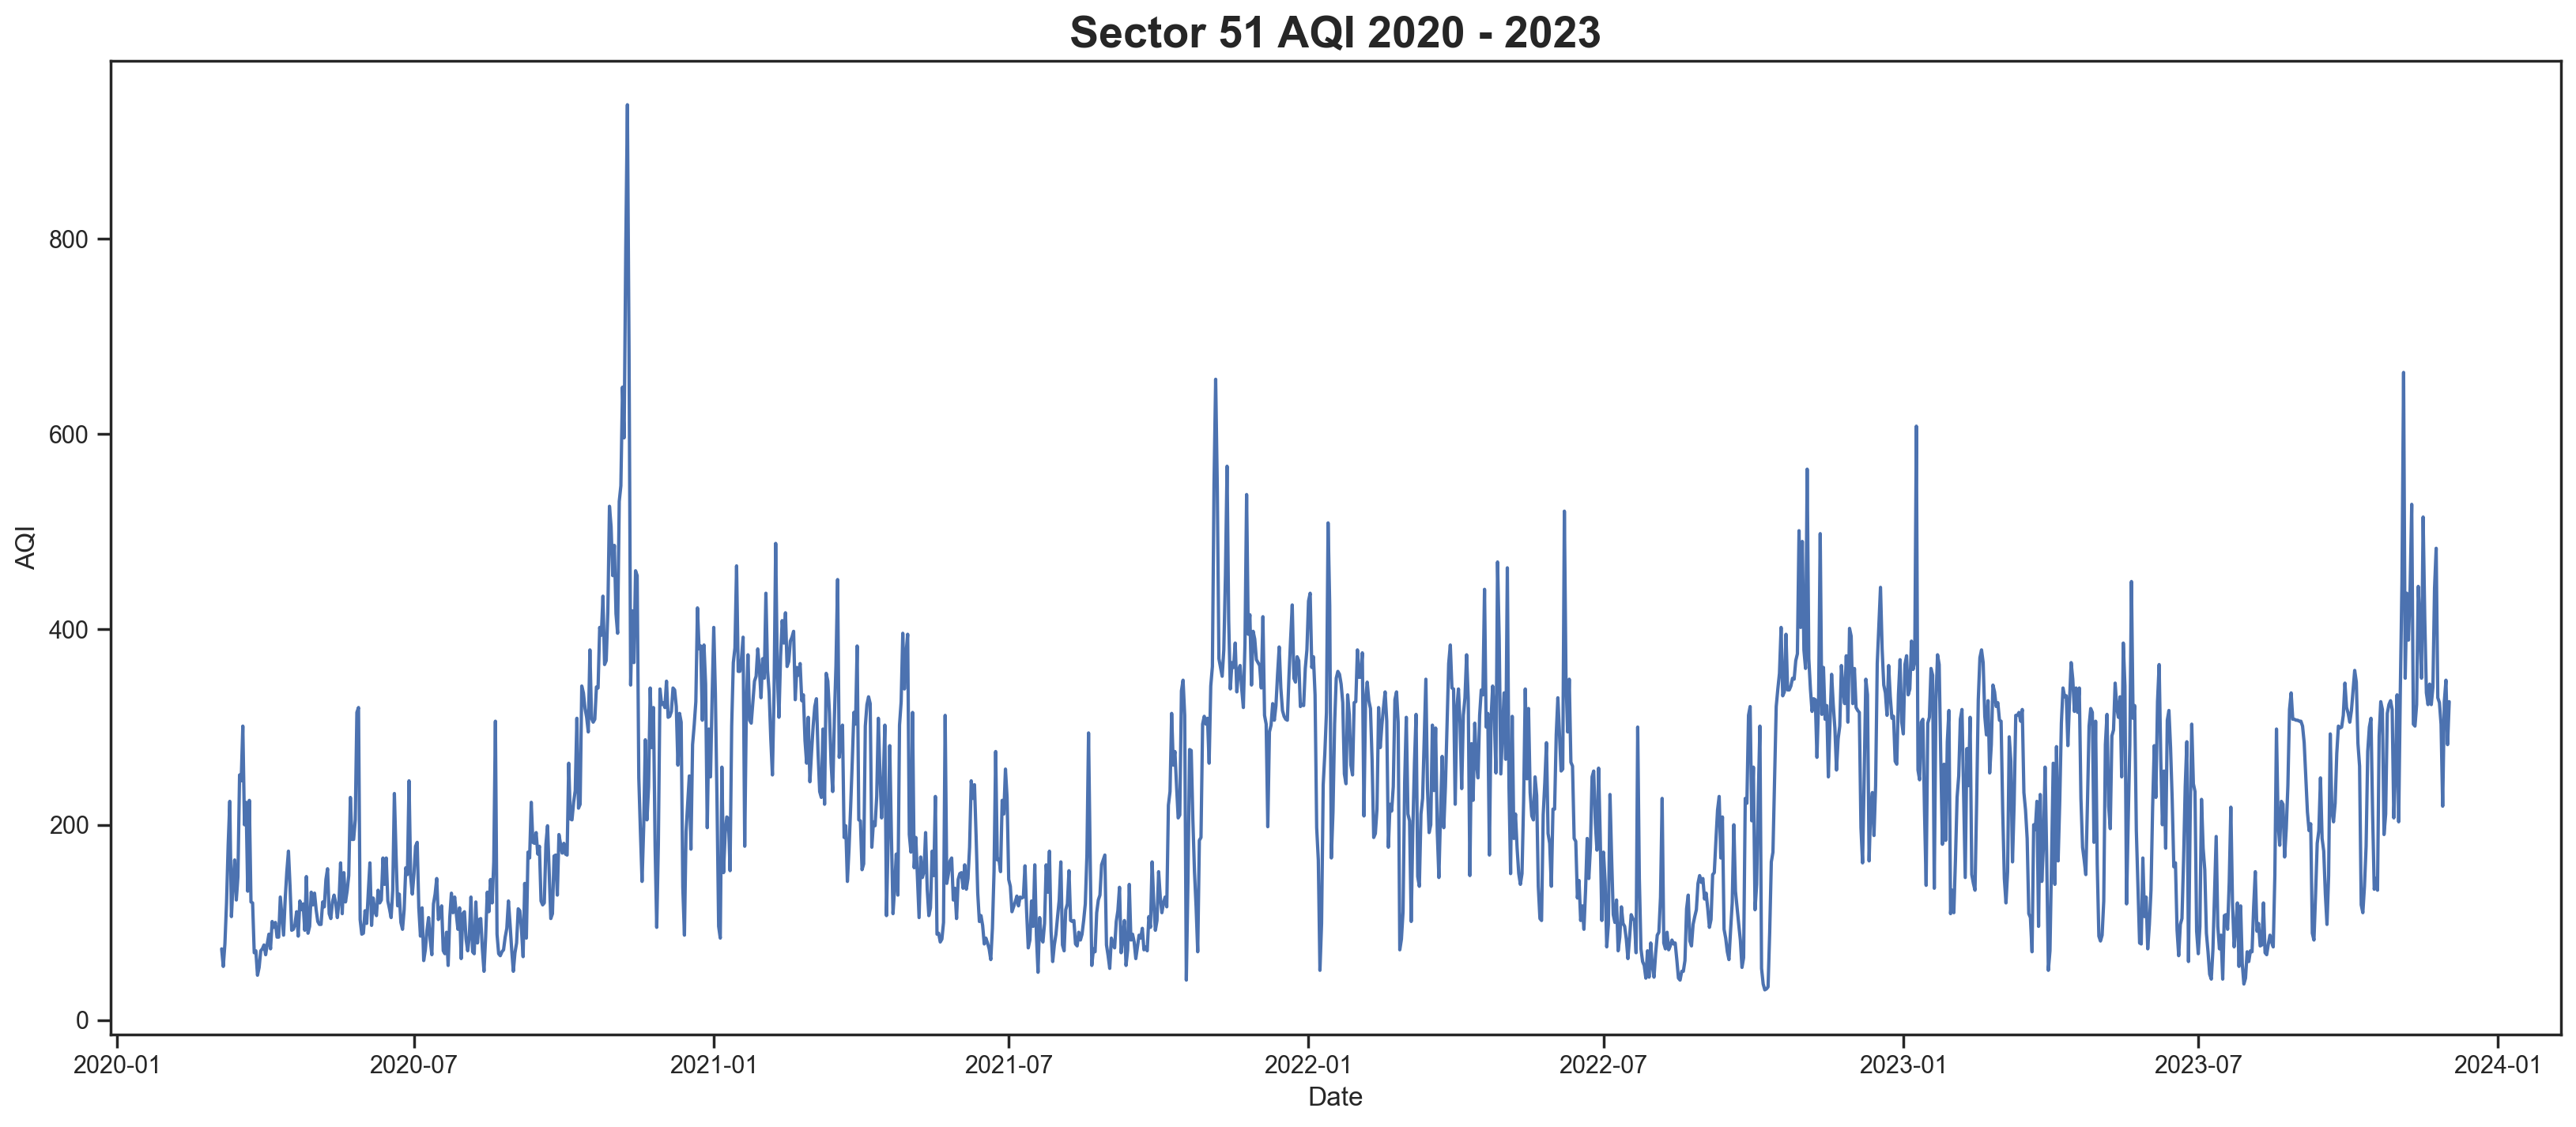

In [18]:
plt.figure(figsize=(20,8))
sns.lineplot(data = df['AQI'], errorbar=None)
plt.title('Sector 51 AQI 2020 - 2023', fontdict= {"fontsize": 20, "fontweight": "bold"})

## ACF and PACF

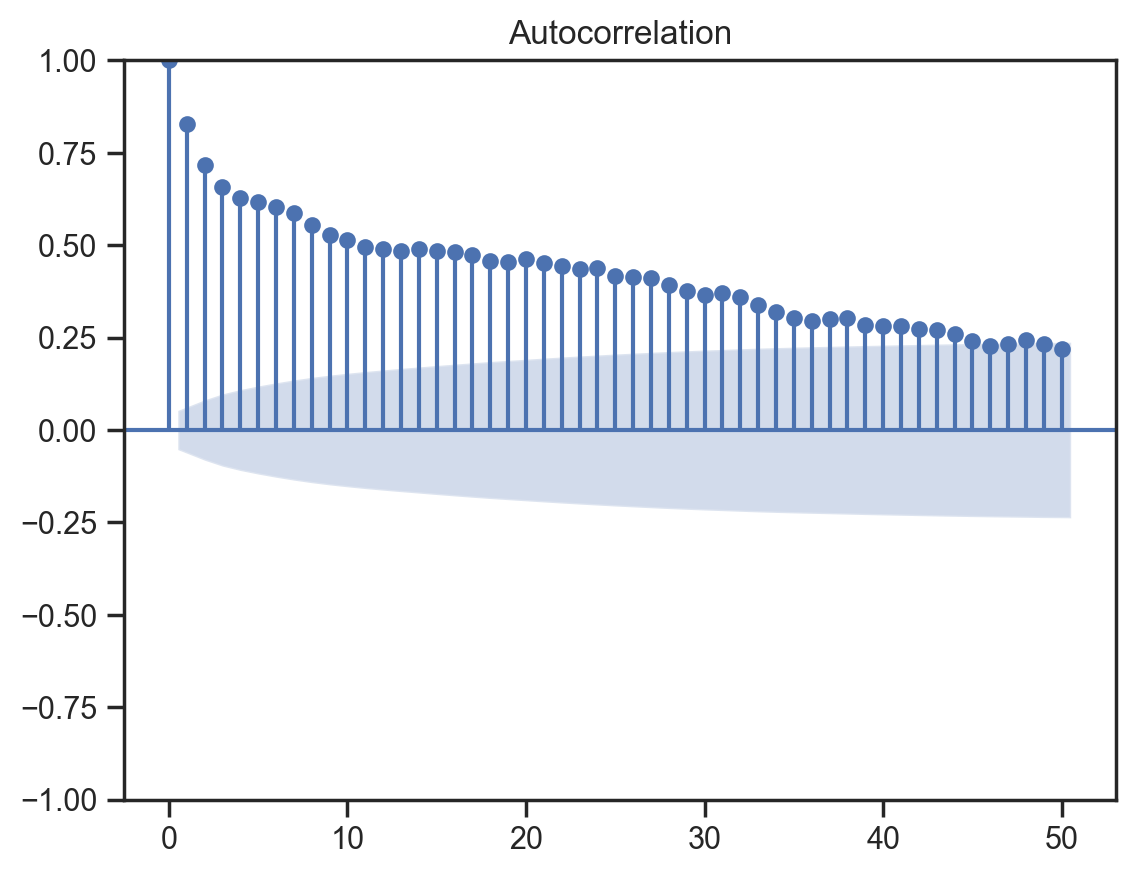

In [123]:
acf_plot = plot_acf(df['AQI'], lags= 50)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


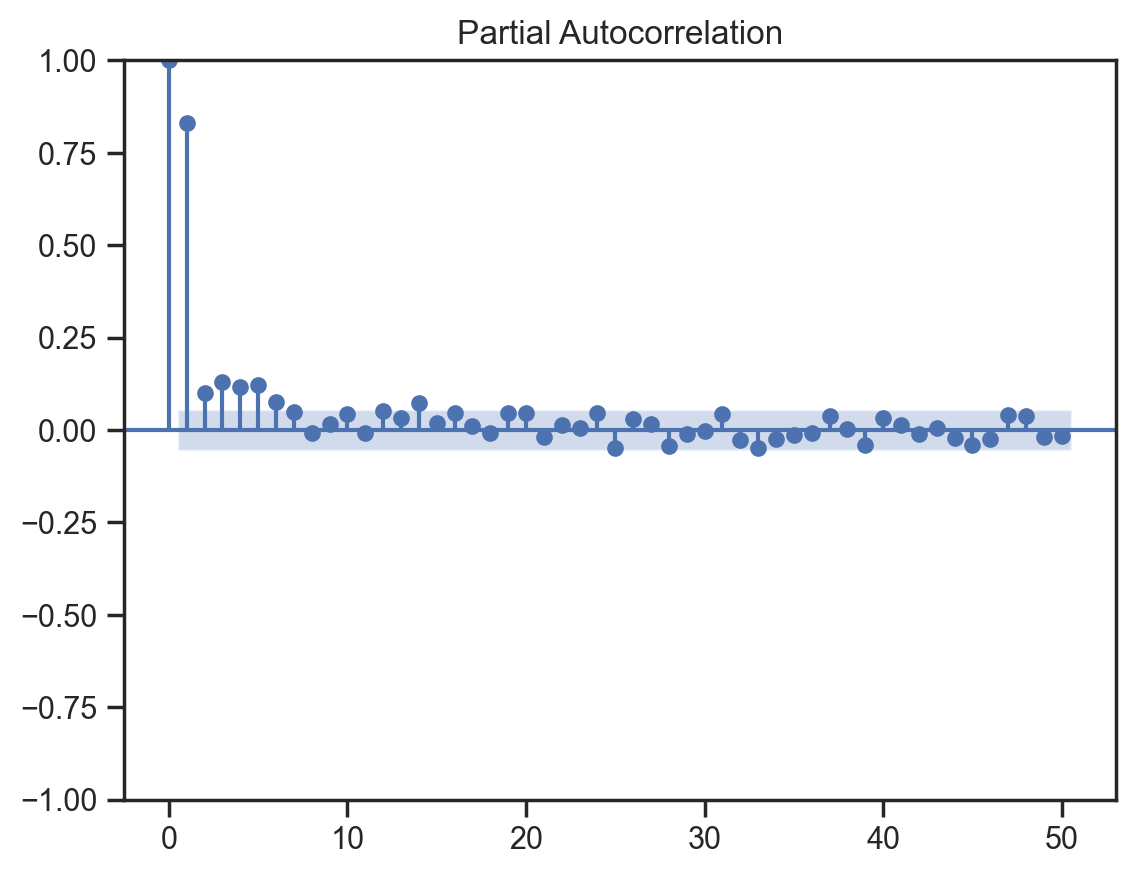

In [22]:
pacf_plot = plot_pacf(df['AQI'], lags= 50)

In [23]:
import statsmodels.api as sm

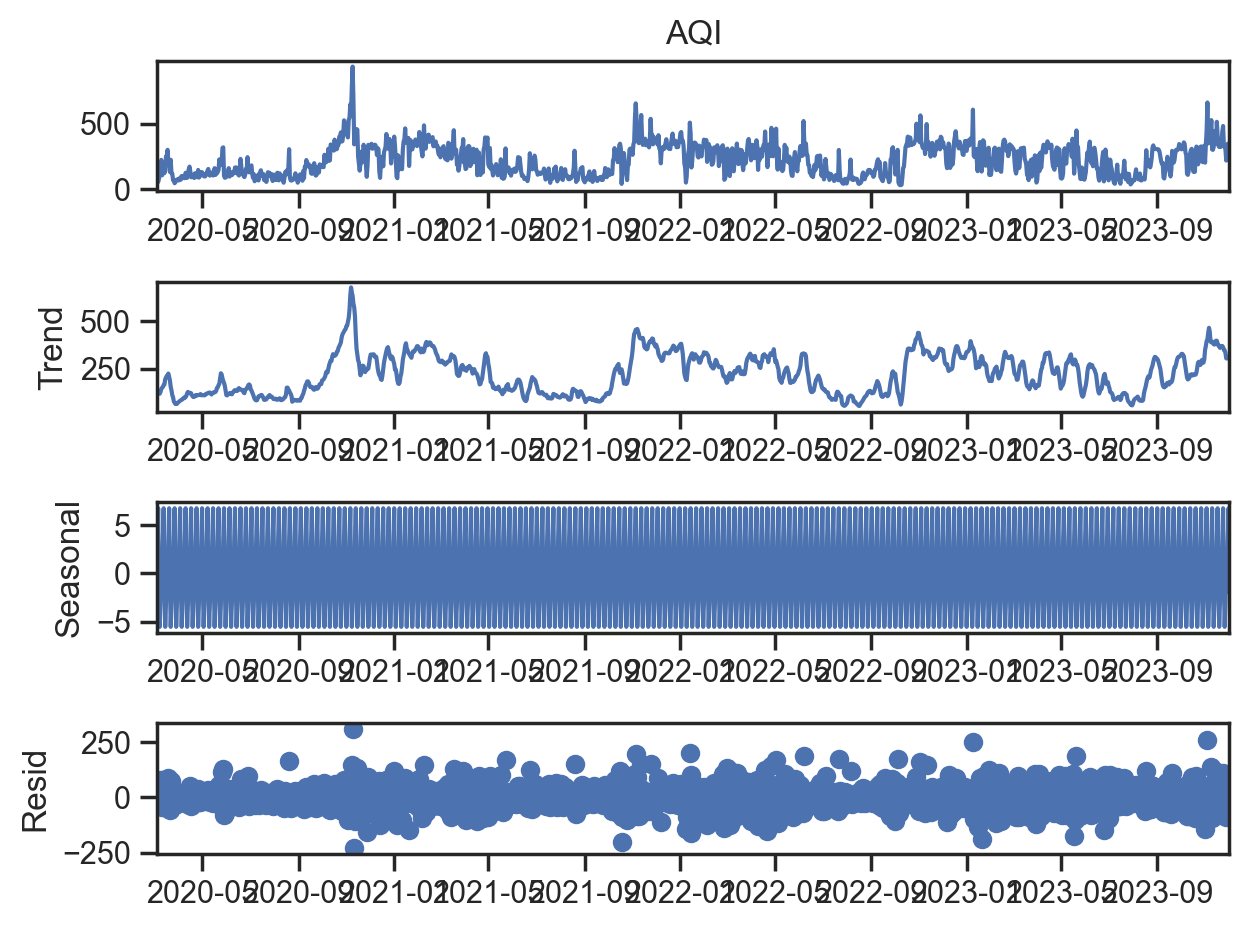

In [24]:
decomp = sm.tsa.seasonal_decompose(df['AQI'])
_ = decomp.plot()

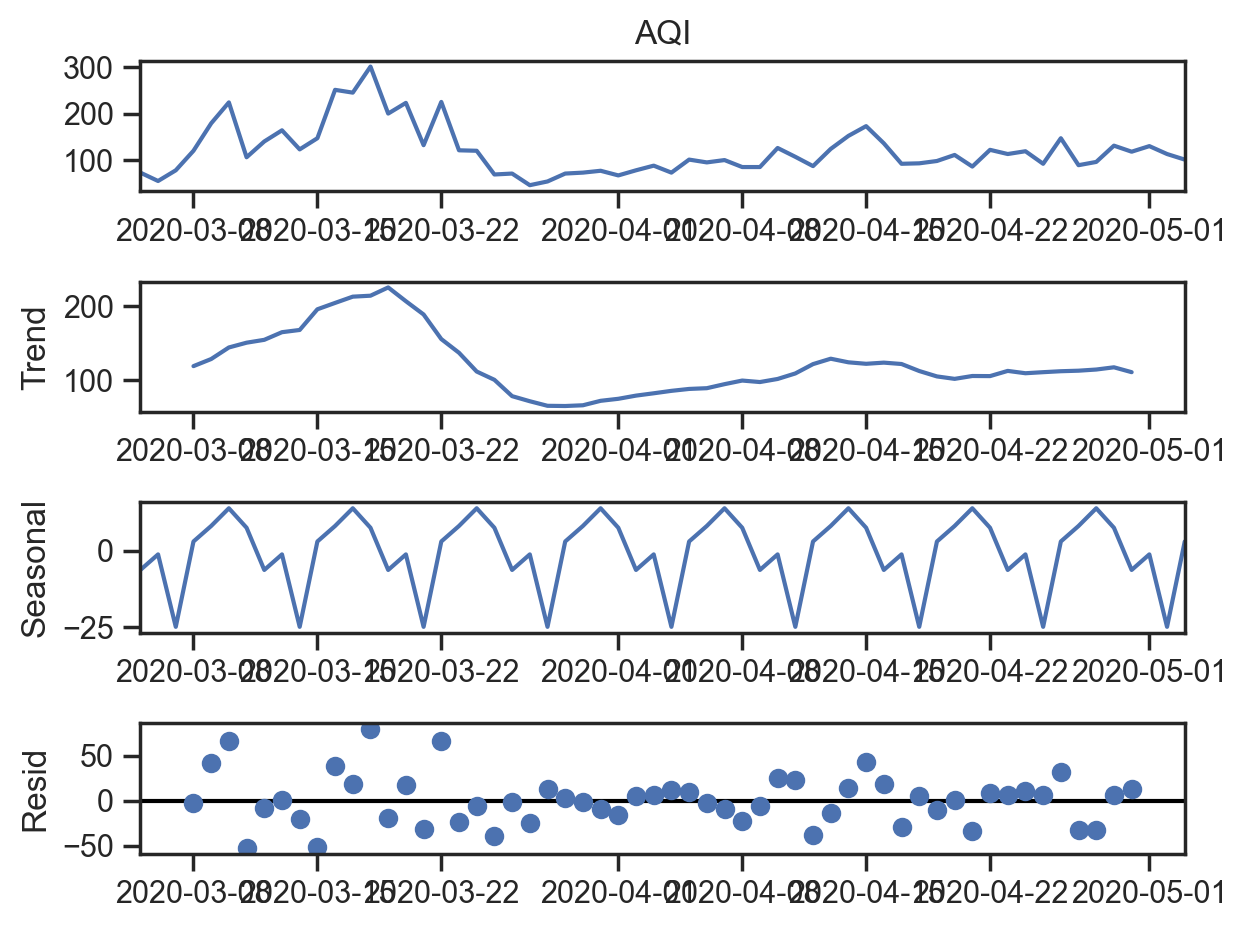

In [124]:
decomp = sm.tsa.seasonal_decompose(df['AQI'][:60])
_ = decomp.plot()

# Functions

In [255]:
def rolling_model(df, order, seasonal_order, train_end, test_end, results):

    train_data = df[ : train_end]['AQI']
    test_data = df[train_end + timedelta(days=1) : test_end]['AQI']

    train_end_copy = train_end
    
    p, d, q = order
    P, D, Q, s = seasonal_order

    rolling_predictions = test_data.copy()

    for train_end in test_data.index:
        train_data = df[ : train_end - timedelta(days=1)]['AQI']
        
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()

        prediction = model_fit.forecast(typ='levels')
        rolling_predictions[train_end] = prediction
    
    residuals = test_data - rolling_predictions
    
    plt.figure(figsize=(14,7))
    plt.plot(residuals)
    plt.axhline(0, linestyle='--', color='k')
    plt.title(f'Residuals from SARIMAX {order} {seasonal_order}', fontsize=20)
    plt.ylabel('Error', fontsize=16)

    plt.figure(figsize=(14, 7))
    plt.plot(test_data)
    plt.plot(rolling_predictions, '--')
    plt.legend(('Data', 'Rolling Predictions'), fontsize=16)
    plt.title(f"AQI daily SARIMAX {order} {seasonal_order}")
    
    results = append_to_results(train_end_copy, test_end, p, d, q, P, D, Q, s, test_data[:-1],
                            rolling_predictions.shift(-1)[:-1], True,
                            model_fit, results)
    return results

In [256]:
def without_rolling_model(df, order, seasonal_order, train_end, test_end, results):

    train_data = df[ : train_end]['AQI']
    test_data = df[train_end + timedelta(days=1) : test_end]['AQI']

    train_end_copy = train_end
    
    p, d, q = order
    P, D, Q, s = seasonal_order

    model = SARIMAX(train_data, order=order, seasonal_order = seasonal_order)
    model_fit = model.fit()
    
    predictions = model_fit.forecast(len(test_data))
    predictions = pd.Series(predictions, index=test_data.index)
    residuals = test_data - predictions

    plt.figure(figsize=(14,7))
    plt.plot(residuals)
    plt.axhline(0, linestyle='--', color='k')
    plt.title(f'Residuals from SARIMAX {order} {seasonal_order}', fontsize=20)
    plt.ylabel('Error', fontsize=16)

    plt.figure(figsize=(14, 7))
    plt.plot(test_data)
    plt.plot(predictions, '--')
    plt.legend(('Data', 'Predictions'), fontsize=16)
    plt.title(f"AQI daily SARIMAX {order} {seasonal_order}")
    
    results = append_to_results(train_end_copy, test_end, p, d, q, P, D, Q, s, test_data,
                            predictions, False,
                            model_fit, results)
    return results

(1, 0, 1) (1, 0, 1, 7)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70325D+00    |proj g|=  1.59279D-01

At iterate    5    f=  5.62262D+00    |proj g|=  6.41252D-04

At iterate   10    f=  5.62164D+00    |proj g|=  4.17823D-03

At iterate   15    f=  5.61850D+00    |proj g|=  3.96466D-03

At iterate   20    f=  5.61530D+00    |proj g|=  2.91338D-03

At iterate   25    f=  5.61310D+00    |proj g|=  2.02058D-03

At iterate   30    f=  5.61274D+00    |proj g|=  4.26342D-04

At iterate   35    f=  5.61255D+00    |proj g|=  2.20700D-04

At iterate   40    f=  5.61254D+00    |proj g|=  7.51443D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70298D+00    |proj g|=  1.59821D-01

At iterate    5    f=  5.62226D+00    |proj g|=  6.43745D-04

At iterate   10    f=  5.62135D+00    |proj g|=  3.85894D-03

At iterate   15    f=  5.61877D+00    |proj g|=  7.65443D-03

At iterate   20    f=  5.61330D+00    |proj g|=  9.02342D-04

At iterate   25    f=  5.61242D+00    |proj g|=  7.91977D-04

At iterate   30    f=  5.61222D+00    |proj g|=  1.58800D-03

At iterate   35    f=  5.61217D+00    |proj g|=  1.85874D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70271D+00    |proj g|=  1.59960D-01

At iterate    5    f=  5.62194D+00    |proj g|=  6.36153D-04


 This problem is unconstrained.



At iterate   10    f=  5.62105D+00    |proj g|=  3.62022D-03

At iterate   15    f=  5.61923D+00    |proj g|=  5.93857D-03

At iterate   20    f=  5.61327D+00    |proj g|=  1.15871D-03

At iterate   25    f=  5.61238D+00    |proj g|=  6.81482D-03

At iterate   30    f=  5.61201D+00    |proj g|=  2.33335D-04

At iterate   35    f=  5.61188D+00    |proj g|=  5.82637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     43      1     0     0   7.871D-05   5.612D+00
  F =   5.6118736213669838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70271D+00    |proj g|=  1.60146D-01

At iterate    5    f=  5.62254D+00    |proj g|=  6.81459D-04


 This problem is unconstrained.



At iterate   10    f=  5.62159D+00    |proj g|=  3.06221D-03

At iterate   15    f=  5.61824D+00    |proj g|=  2.31800D-03

At iterate   20    f=  5.61388D+00    |proj g|=  1.21806D-03

At iterate   25    f=  5.61297D+00    |proj g|=  1.13874D-02

At iterate   30    f=  5.61268D+00    |proj g|=  1.18752D-03

At iterate   35    f=  5.61262D+00    |proj g|=  8.08055D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     42      1     0     0   1.509D-04   5.613D+00
  F =   5.6126167131267195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70331D+00    |proj g|=  1.61290D-01

At iterate    5    f=  5.62274D+00    |proj g|=  6.69734D-04

At iterate   10    f=  5.62181D+00    |proj g|=  2.66774D-03

At iterate   15    f=  5.61957D+00    |proj g|=  1.57162D-02

At iterate   20    f=  5.61390D+00    |proj g|=  2.27579D-03

At iterate   25    f=  5.61338D+00    |proj g|=  2.40194D-03

At iterate   30    f=  5.61288D+00    |proj g|=  6.78311D-04

At iterate   35    f=  5.61283D+00    |proj g|=  3.68838D-05

At iterate   40    f=  5.61283D+00    |proj g|=  6.40874D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70390D+00    |proj g|=  1.59741D-01

At iterate    5    f=  5.62351D+00    |proj g|=  6.81604D-04


 This problem is unconstrained.



At iterate   10    f=  5.62253D+00    |proj g|=  1.19673D-03

At iterate   15    f=  5.62172D+00    |proj g|=  1.14337D-02

At iterate   20    f=  5.61584D+00    |proj g|=  3.11932D-03

At iterate   25    f=  5.61415D+00    |proj g|=  4.30170D-03

At iterate   30    f=  5.61363D+00    |proj g|=  4.71992D-04

At iterate   35    f=  5.61350D+00    |proj g|=  1.19217D-03

At iterate   40    f=  5.61341D+00    |proj g|=  5.41876D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     53      1     0     0   2.005D-05   5.613D+00
  F =   5.6134129133704587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70356D+00    |proj g|=  1.59760D-01

At iterate    5    f=  5.62318D+00    |proj g|=  7.12496D-04


 This problem is unconstrained.



At iterate   10    f=  5.62226D+00    |proj g|=  1.99175D-03

At iterate   15    f=  5.62056D+00    |proj g|=  2.01998D-02

At iterate   20    f=  5.61441D+00    |proj g|=  1.05056D-03

At iterate   25    f=  5.61375D+00    |proj g|=  8.57402D-03

At iterate   30    f=  5.61324D+00    |proj g|=  3.21936D-04

At iterate   35    f=  5.61318D+00    |proj g|=  6.18310D-03

At iterate   40    f=  5.61305D+00    |proj g|=  6.44687D-05

At iterate   45    f=  5.61305D+00    |proj g|=  9.83153D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     53      1     0     0   9.832D-05   5.613D+00
  F =   5.61304500594

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70347D+00    |proj g|=  1.60361D-01

At iterate    5    f=  5.62286D+00    |proj g|=  7.27501D-04

At iterate   10    f=  5.62199D+00    |proj g|=  9.49865D-03

At iterate   15    f=  5.62148D+00    |proj g|=  3.39513D-03

At iterate   20    f=  5.61501D+00    |proj g|=  1.12601D-02

At iterate   25    f=  5.61390D+00    |proj g|=  4.90022D-03

At iterate   30    f=  5.61293D+00    |proj g|=  5.06104D-04

At iterate   35    f=  5.61269D+00    |proj g|=  1.72544D-04

At iterate   40    f=  5.61269D+00    |proj g|=  3.32237D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70377D+00    |proj g|=  1.61096D-01

At iterate    5    f=  5.62307D+00    |proj g|=  7.70150D-04

At iterate   10    f=  5.62183D+00    |proj g|=  2.54969D-03

At iterate   15    f=  5.61979D+00    |proj g|=  1.00265D-02

At iterate   20    f=  5.61431D+00    |proj g|=  6.86343D-03

At iterate   25    f=  5.61387D+00    |proj g|=  5.32244D-03

At iterate   30    f=  5.61338D+00    |proj g|=  5.20403D-04

At iterate   35    f=  5.61329D+00    |proj g|=  5.21813D-04

At iterate   40    f=  5.61291D+00    |proj g|=  1.01399D-04

At iterate   45    f=  5.61290D+00    |proj g|=  4.74167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70380D+00    |proj g|=  1.60504D-01


 This problem is unconstrained.



At iterate    5    f=  5.62333D+00    |proj g|=  7.36125D-04

At iterate   10    f=  5.62224D+00    |proj g|=  2.45834D-03

At iterate   15    f=  5.61896D+00    |proj g|=  4.15758D-03

At iterate   20    f=  5.61427D+00    |proj g|=  9.42382D-04

At iterate   25    f=  5.61343D+00    |proj g|=  7.10306D-04

At iterate   30    f=  5.61331D+00    |proj g|=  3.56005D-04

At iterate   35    f=  5.61329D+00    |proj g|=  1.06941D-03

At iterate   40    f=  5.61327D+00    |proj g|=  1.17499D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     45      1     0     0   1.175D-05   5.613D+00
  F =   5.61327351278

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70357D+00    |proj g|=  1.60738D-01

At iterate    5    f=  5.62312D+00    |proj g|=  7.61411D-04

At iterate   10    f=  5.62221D+00    |proj g|=  1.87823D-03

At iterate   15    f=  5.62157D+00    |proj g|=  6.69396D-03

At iterate   20    f=  5.61765D+00    |proj g|=  5.71238D-03

At iterate   25    f=  5.61416D+00    |proj g|=  8.04704D-04

At iterate   30    f=  5.61320D+00    |proj g|=  4.56685D-04

At iterate   35    f=  5.61308D+00    |proj g|=  5.93191D-05

At iterate   40    f=  5.61308D+00    |proj g|=  2.36486D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70264D+00    |proj g|=  1.59616D-01


 This problem is unconstrained.



At iterate    5    f=  5.62292D+00    |proj g|=  7.58316D-04

At iterate   10    f=  5.62204D+00    |proj g|=  1.78705D-03

At iterate   15    f=  5.61984D+00    |proj g|=  1.57974D-02

At iterate   20    f=  5.61476D+00    |proj g|=  4.54377D-03

At iterate   25    f=  5.61358D+00    |proj g|=  2.77431D-03

At iterate   30    f=  5.61311D+00    |proj g|=  3.12568D-04

At iterate   35    f=  5.61291D+00    |proj g|=  4.51015D-04

At iterate   40    f=  5.61290D+00    |proj g|=  1.18925D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     49      1     0     0   1.189D-05   5.613D+00
  F =   5.61290015826

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67421D+00    |proj g|=  1.11344D-01


 This problem is unconstrained.



At iterate    5    f=  5.62361D+00    |proj g|=  4.85292D-04

At iterate   10    f=  5.62344D+00    |proj g|=  1.11049D-03

At iterate   15    f=  5.62333D+00    |proj g|=  1.28540D-03

At iterate   20    f=  5.62271D+00    |proj g|=  1.02252D-03

At iterate   25    f=  5.62235D+00    |proj g|=  2.58140D-03

At iterate   30    f=  5.62209D+00    |proj g|=  3.48892D-04

At iterate   35    f=  5.62198D+00    |proj g|=  5.49417D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     54      1     0     0   9.055D-04   5.622D+00
  F =   5.6219493555282423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67397D+00    |proj g|=  1.11399D-01


 This problem is unconstrained.



At iterate    5    f=  5.62324D+00    |proj g|=  4.81962D-04

At iterate   10    f=  5.62307D+00    |proj g|=  1.11466D-03

At iterate   15    f=  5.62297D+00    |proj g|=  1.25715D-03

At iterate   20    f=  5.62235D+00    |proj g|=  3.94187D-04

At iterate   25    f=  5.62202D+00    |proj g|=  6.33126D-03

At iterate   30    f=  5.62173D+00    |proj g|=  2.65997D-04

At iterate   35    f=  5.62164D+00    |proj g|=  7.29561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     48      1     0     0   6.193D-04   5.622D+00
  F =   5.6216169489797556     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67331D+00    |proj g|=  1.10390D-01


 This problem is unconstrained.



At iterate    5    f=  5.62291D+00    |proj g|=  4.85942D-04

At iterate   10    f=  5.62276D+00    |proj g|=  1.16043D-03

At iterate   15    f=  5.62267D+00    |proj g|=  1.05037D-03

At iterate   20    f=  5.62205D+00    |proj g|=  3.93382D-04

At iterate   25    f=  5.62160D+00    |proj g|=  3.93556D-04

At iterate   30    f=  5.62138D+00    |proj g|=  3.86904D-04

At iterate   35    f=  5.62128D+00    |proj g|=  1.21338D-04

At iterate   40    f=  5.62126D+00    |proj g|=  3.13130D-04
  ys=-1.631E-07  -gs= 3.721E-06 BFGS update SKIPPED

At iterate   45    f=  5.62126D+00    |proj g|=  6.46866D-05


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.62126D+00    |proj g|=  1.18751D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     76      1     1     0   1.188D-04   5.621D+00
  F =   5.6212584916652792     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67403D+00    |proj g|=  1.10317D-01


 This problem is unconstrained.



At iterate    5    f=  5.62359D+00    |proj g|=  4.62123D-04

At iterate   10    f=  5.62344D+00    |proj g|=  1.23509D-03

At iterate   15    f=  5.62333D+00    |proj g|=  1.06617D-03

At iterate   20    f=  5.62267D+00    |proj g|=  3.98830D-04

At iterate   25    f=  5.62254D+00    |proj g|=  2.36632D-03

At iterate   30    f=  5.62192D+00    |proj g|=  2.90038D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     46      1     0     0   1.155D-03   5.622D+00
  F =   5.6219026109655506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67536D+00    |proj g|=  1.12870D-01

At iterate    5    f=  5.62373D+00    |proj g|=  4.45265D-04

At iterate   10    f=  5.62358D+00    |proj g|=  1.43210D-03

At iterate   15    f=  5.62287D+00    |proj g|=  2.87984D-03

At iterate   20    f=  5.62231D+00    |proj g|=  5.74626D-04

At iterate   25    f=  5.62195D+00    |proj g|=  2.86115D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     43      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67623D+00    |proj g|=  1.12603D-01

At iterate    5    f=  5.62454D+00    |proj g|=  4.30937D-04

At iterate   10    f=  5.62435D+00    |proj g|=  1.20639D-03

At iterate   15    f=  5.62353D+00    |proj g|=  1.05876D-03

At iterate   20    f=  5.62338D+00    |proj g|=  3.53393D-04

At iterate   25    f=  5.62293D+00    |proj g|=  2.06116D-03

At iterate   30    f=  5.62275D+00    |proj g|=  5.80402D-04

At iterate   35    f=  5.62268D+00    |proj g|=  6.15393D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67597D+00    |proj g|=  1.12717D-01

At iterate    5    f=  5.62424D+00    |proj g|=  4.04374D-04

At iterate   10    f=  5.62406D+00    |proj g|=  1.29506D-03

At iterate   15    f=  5.62329D+00    |proj g|=  5.48946D-03

At iterate   20    f=  5.62299D+00    |proj g|=  1.02801D-03

At iterate   25    f=  5.62250D+00    |proj g|=  4.49504D-04

At iterate   30    f=  5.62245D+00    |proj g|=  7.03652D-04

At iterate   35    f=  5.62241D+00    |proj g|=  6.10404D-04

At iterate   40    f=  5.62238D+00    |proj g|=  4.15663D-04

At iterate   45    f=  5.62238D+00    |proj g|=  3.86222D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67576D+00    |proj g|=  1.12982D-01

At iterate    5    f=  5.62391D+00    |proj g|=  3.89606D-04

At iterate   10    f=  5.62373D+00    |proj g|=  1.31991D-03

At iterate   15    f=  5.62343D+00    |proj g|=  1.26478D-03

At iterate   20    f=  5.62263D+00    |proj g|=  1.21903D-03

At iterate   25    f=  5.62227D+00    |proj g|=  2.21401D-03

At iterate   30    f=  5.62205D+00    |proj g|=  2.05050D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  5.62204D+00    |proj g|=  3.66237D-04

At iterate   40    f=  5.62203D+00    |proj g|=  5.99707D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     71      2     0     0   5.997D-05   5.622D+00
  F =   5.6220257765187220     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67591D+00    |proj g|=  1.12836D-01

At iterate    5    f=  5.62413D+00    |proj g|=  3.71491D-04

At iterate   10    f=  5.62396D+00    |proj g|=  1.43095D-03

At iterate   15    f=  5.62359D+00    |proj g|=  1.09292D-03

At iterate   20    f=  5.62288D+00    |proj g|=  3.39261D-04

At iterate   25    f=  5.62254D+00    |proj g|=  2.49635D-03
  ys=-1.746E-04  -gs= 1.234E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  5.62229D+00    |proj g|=  1.61205D-03

At iterate   35    f=  5.62226D+00    |proj g|=  1.97024D-04

At iterate   40    f=  5.62225D+00    |proj g|=  1.05825D-04

At iterate   45    f=  5.62225D+00    |proj g|=  1.60914D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     81      2     1     0   8.171D-05   5.622D+00
  F =   5.6222535630353887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67601D+00    |proj g|=  1.12370D-01


 This problem is unconstrained.



At iterate    5    f=  5.62436D+00    |proj g|=  3.70281D-04

At iterate   10    f=  5.62419D+00    |proj g|=  1.37602D-03

At iterate   15    f=  5.62380D+00    |proj g|=  1.65712D-03

At iterate   20    f=  5.62312D+00    |proj g|=  7.43022D-04

At iterate   25    f=  5.62270D+00    |proj g|=  5.32144D-04

At iterate   30    f=  5.62256D+00    |proj g|=  4.31217D-04

At iterate   35    f=  5.62255D+00    |proj g|=  6.35880D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     51      1     0     0   3.706D-05   5.623D+00
  F =   5.6225486759770371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67623D+00    |proj g|=  1.13043D-01


 This problem is unconstrained.



At iterate    5    f=  5.62422D+00    |proj g|=  4.07751D-04

At iterate   10    f=  5.62406D+00    |proj g|=  1.65156D-03

At iterate   15    f=  5.62334D+00    |proj g|=  3.04278D-03

At iterate   20    f=  5.62309D+00    |proj g|=  7.60051D-04

At iterate   25    f=  5.62261D+00    |proj g|=  1.75165D-03

At iterate   30    f=  5.62249D+00    |proj g|=  8.44764D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     37      1     0     0   8.448D-04   5.622D+00
  F =   5.6224943894761719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67575D+00    |proj g|=  1.12200D-01


 This problem is unconstrained.



At iterate    5    f=  5.62401D+00    |proj g|=  4.08261D-04

At iterate   10    f=  5.62385D+00    |proj g|=  1.69926D-03

At iterate   15    f=  5.62309D+00    |proj g|=  5.30847D-03

At iterate   20    f=  5.62285D+00    |proj g|=  1.49593D-03

At iterate   25    f=  5.62231D+00    |proj g|=  5.59293D-04

At iterate   30    f=  5.62226D+00    |proj g|=  2.12237D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     41      1     0     0   2.212D-04   5.622D+00
  F =   5.6222545968346900     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/var/folders/27/b03t8q596qvcmtyqjtnh0w6w0000gn/T/ipykernel_5869/1689733556.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results = pd.concat([results, pd.DataFrame.from_dict(result)])


train_end   test_end  p  d  q  P  D  Q   s  MSE MAE      MAPE Rolling?  \
0 2023-11-20 2023-12-02  1  0  1  1  0  1   7  490  16  0.044696     True   
0 2023-11-20 2023-12-02  1  0  1  1  0  1  30  408  17  0.048423     True   

     AIC    BIC  
0  15356  15382  
0  15381  15407

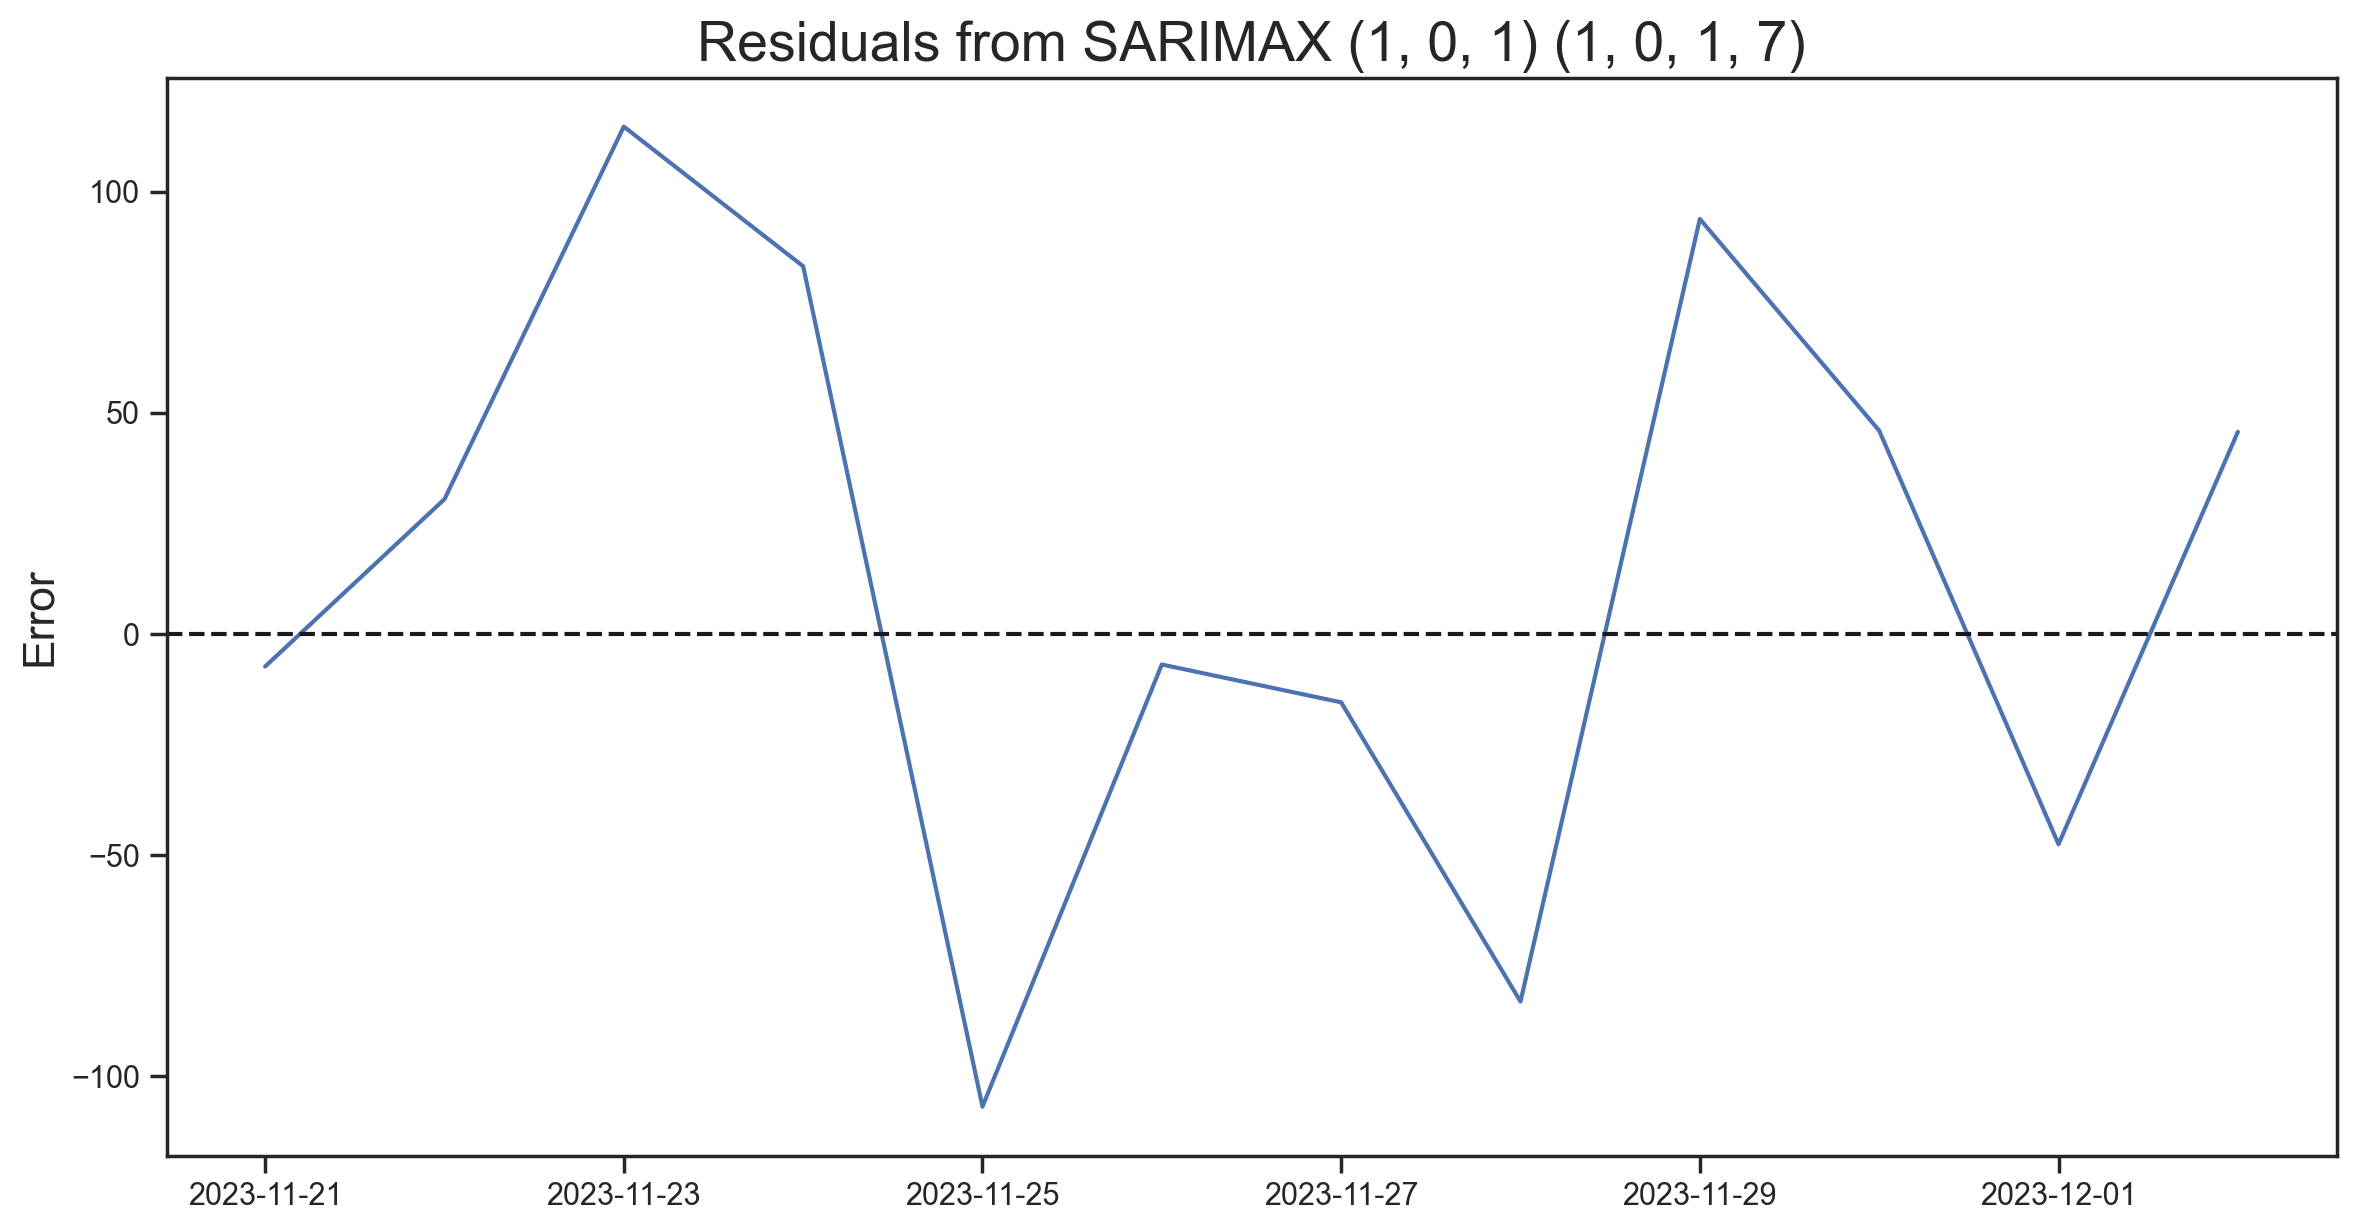

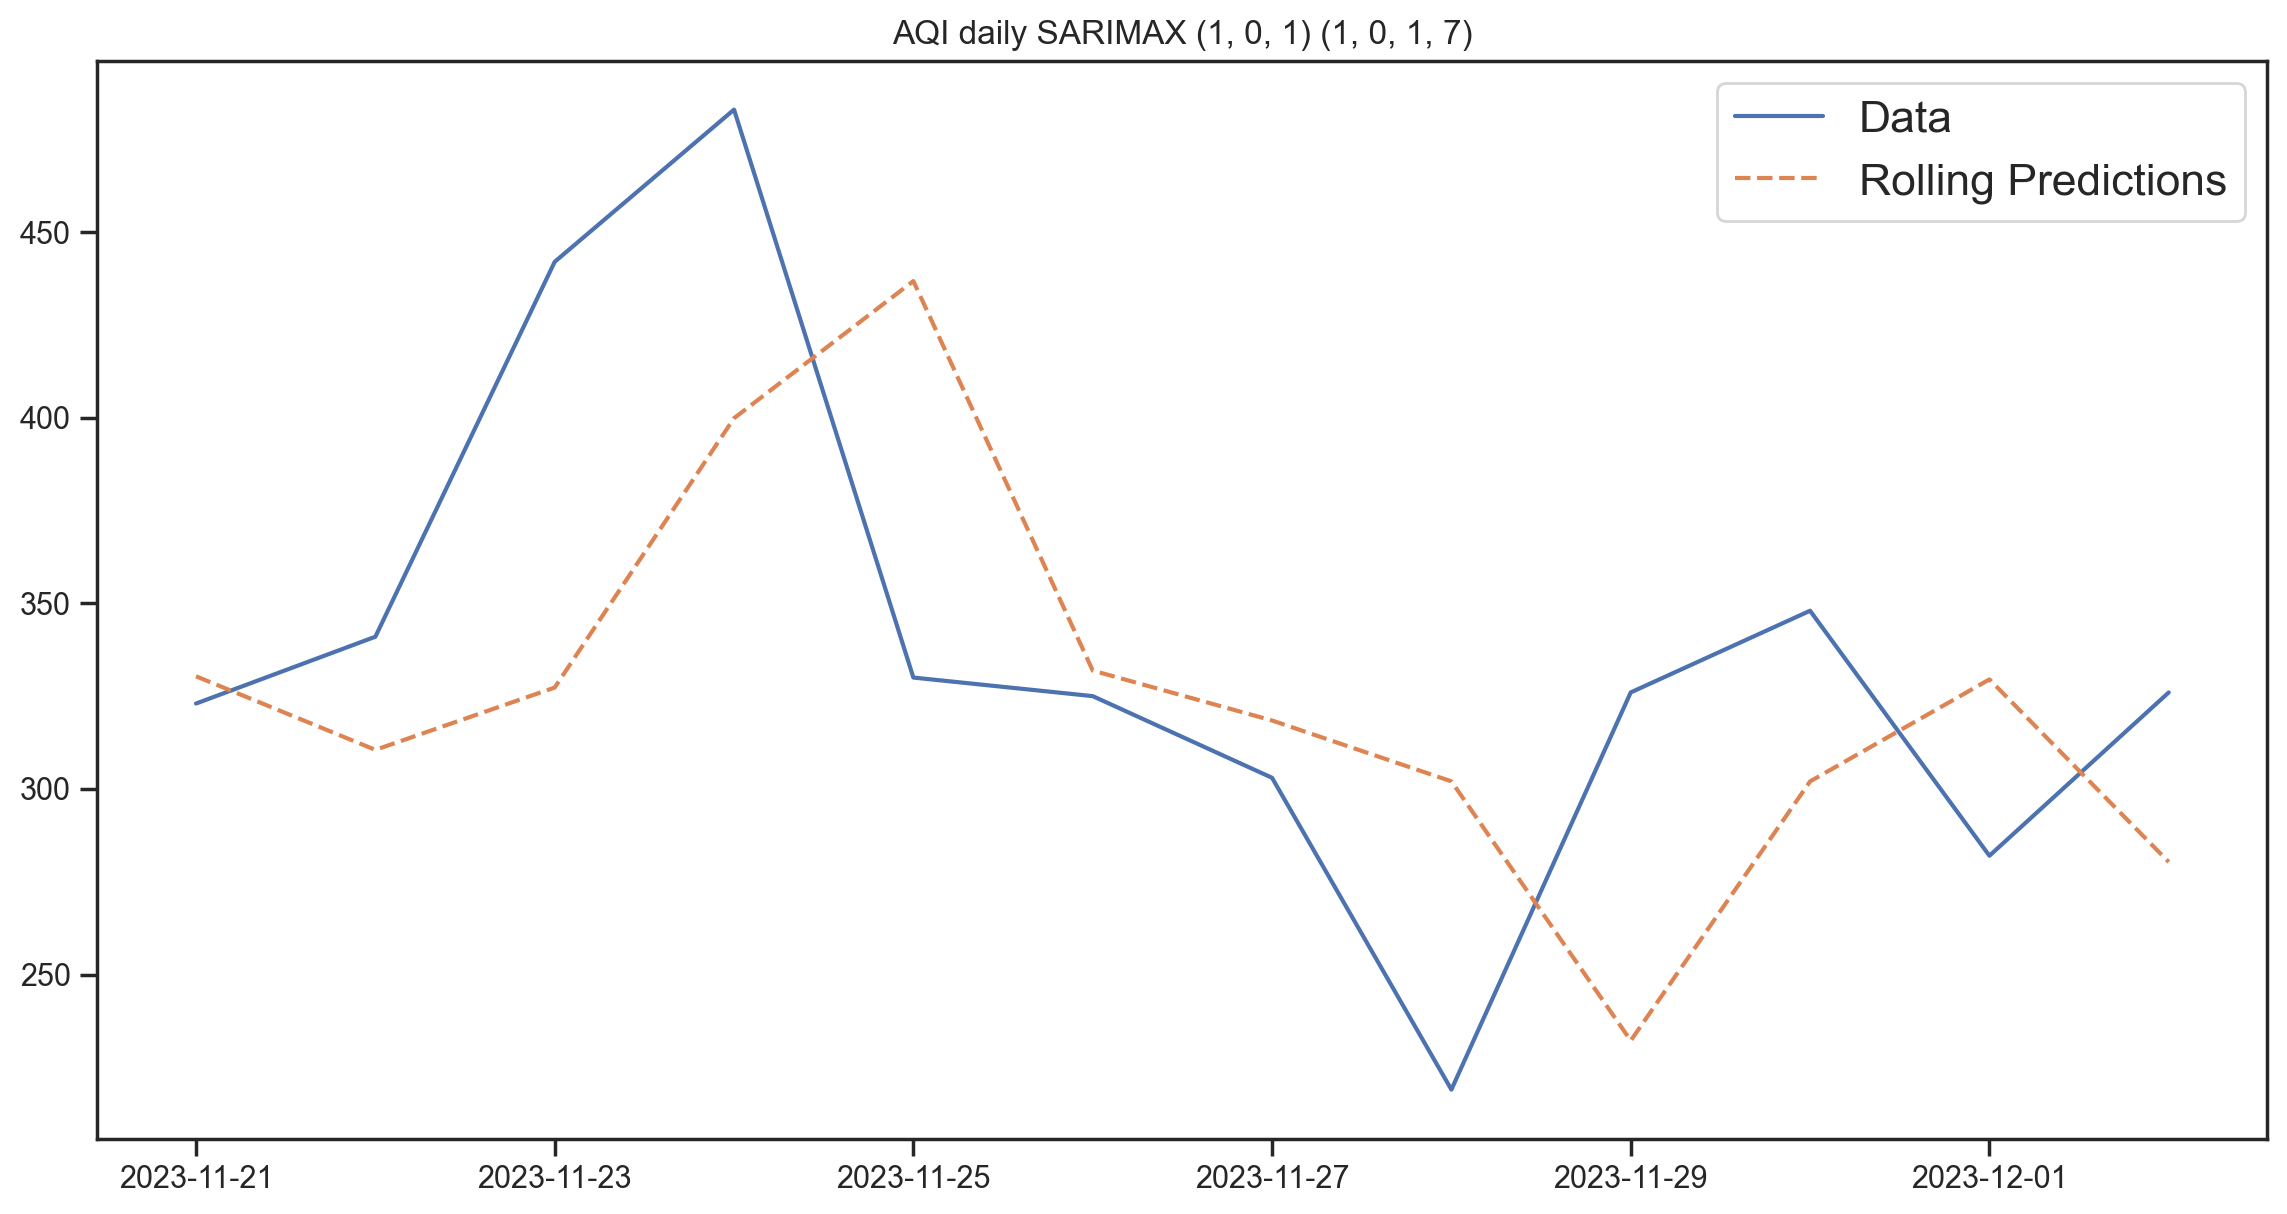

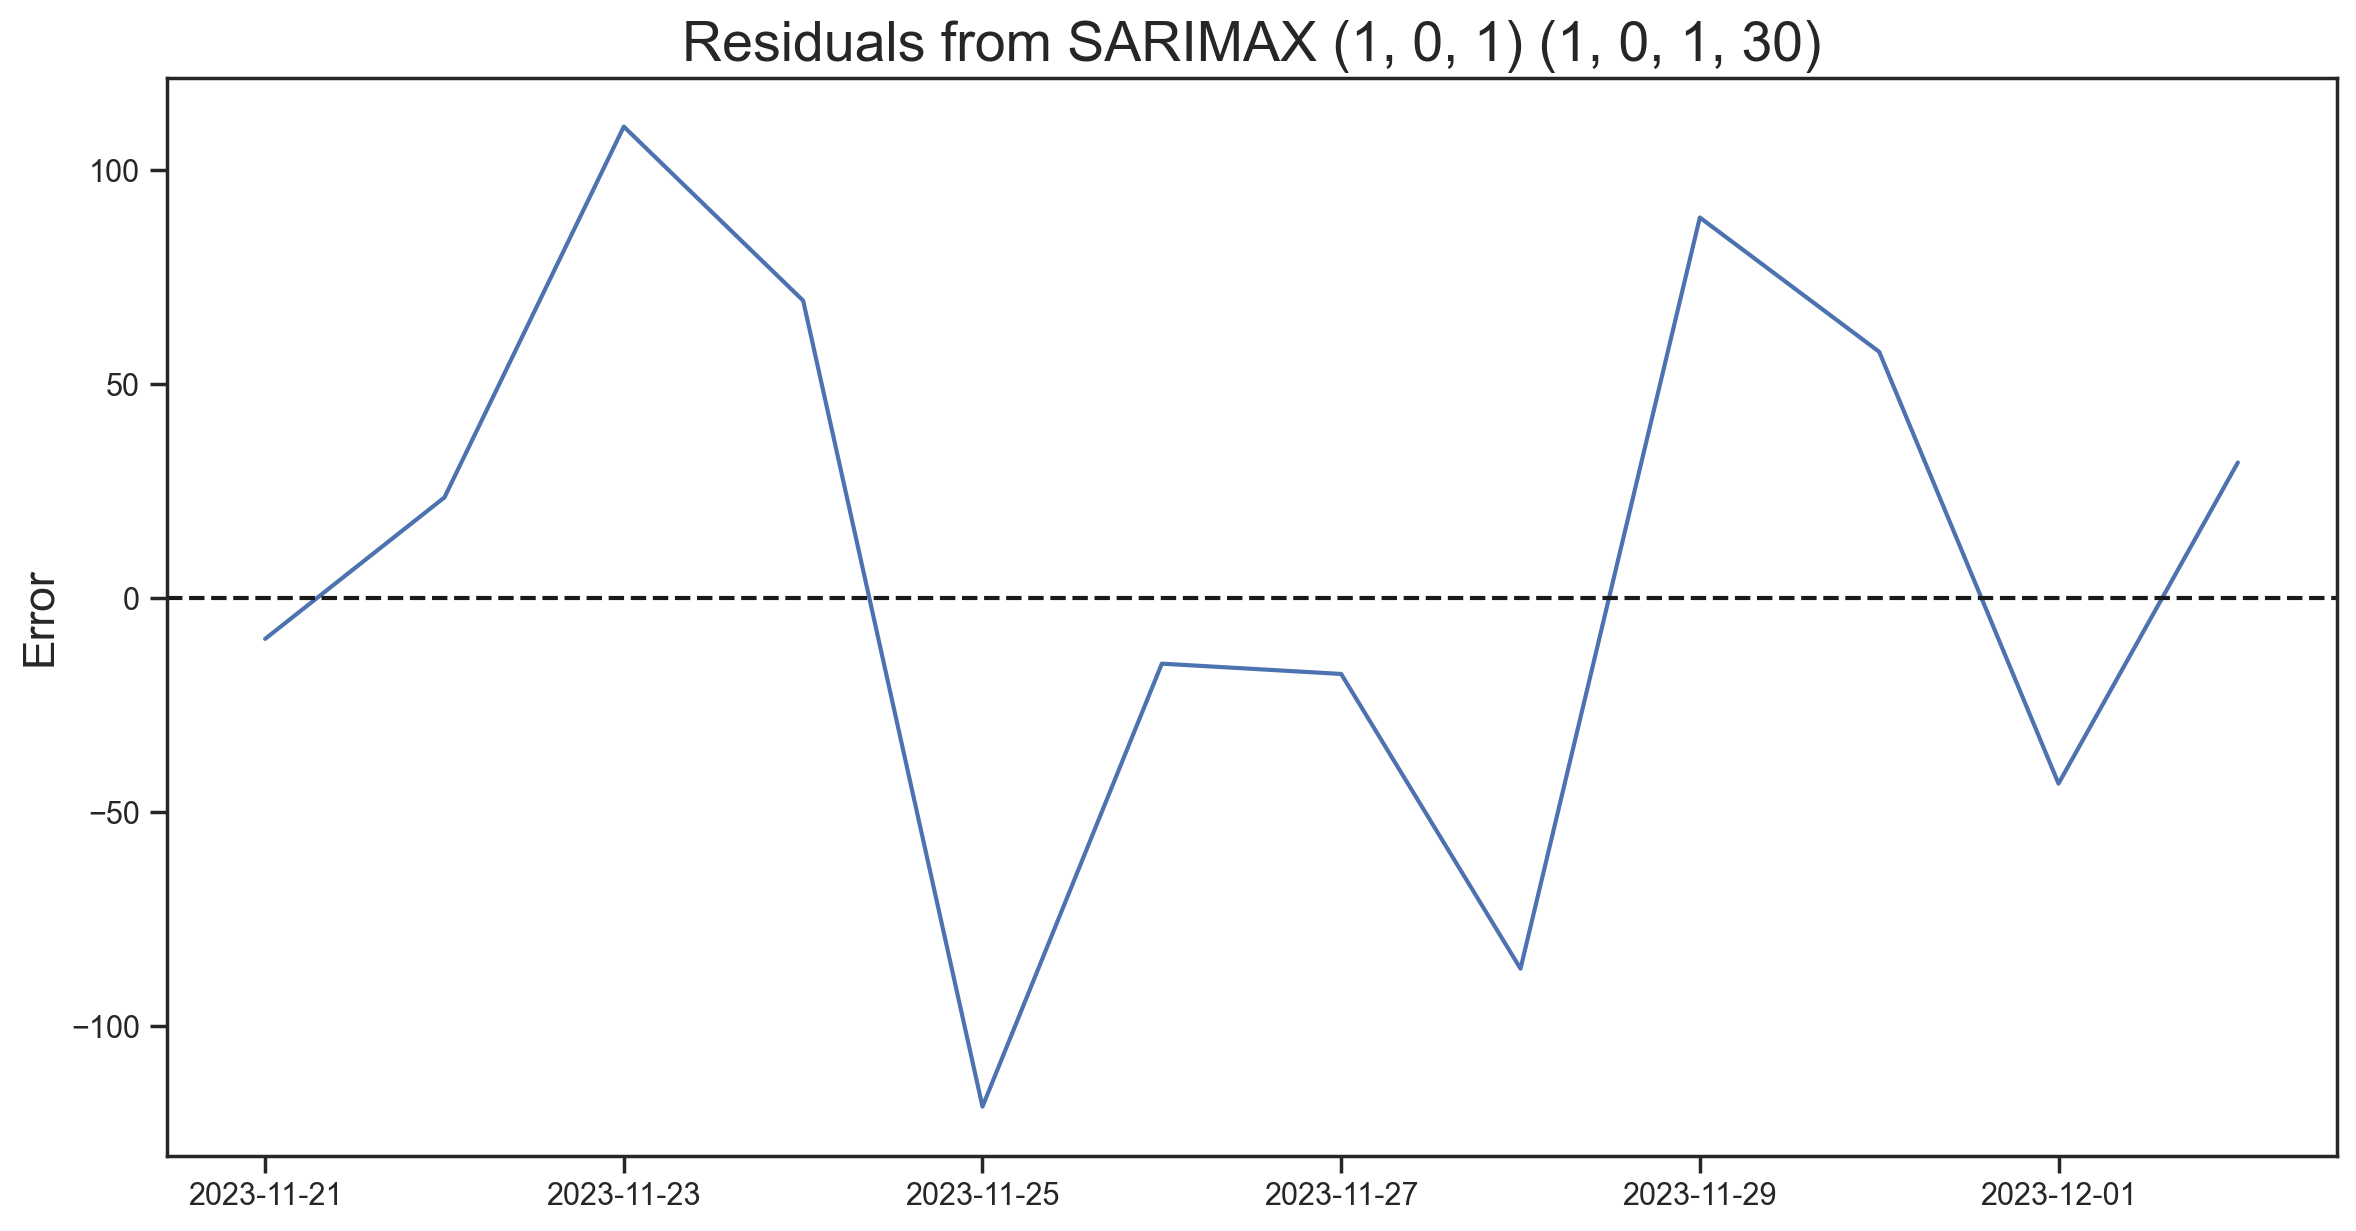

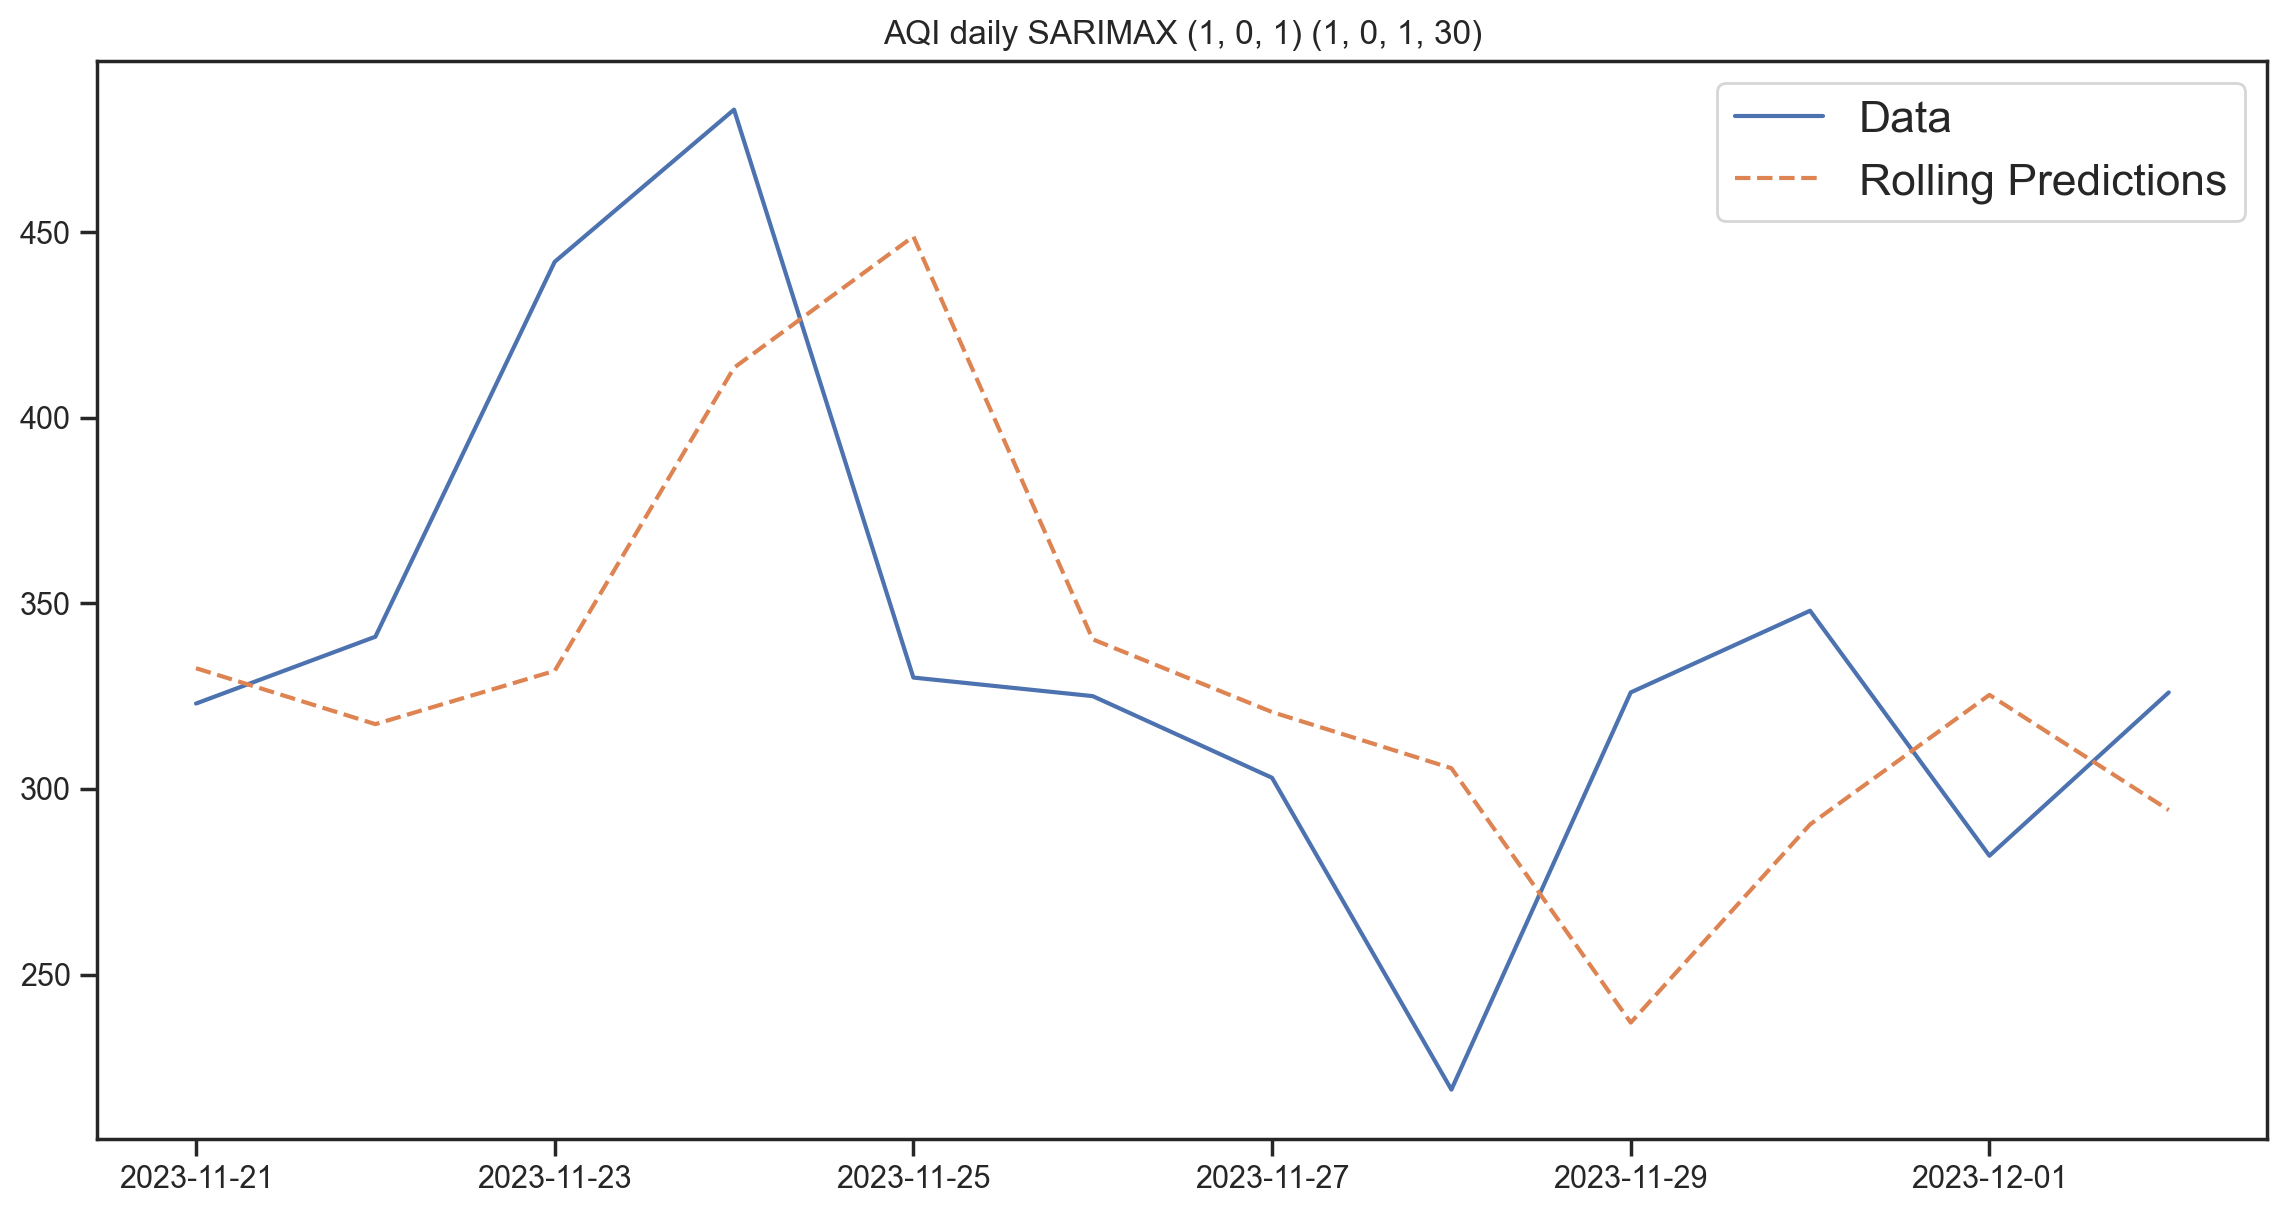

In [257]:
combinations = [[(1, 0, 1), (1, 0, 1, 7)], [(1, 0, 1), (1, 0, 1, 30)]]
for order, seasonal_order in combinations:
    print(order, seasonal_order)
    results = rolling_model(df, order, seasonal_order, datetime(2023, 11, 20), datetime(2023, 12, 2), results)
results

In [258]:
results 

train_end   test_end  p  d  q  P  D  Q   s  MSE MAE      MAPE Rolling?  \
0 2023-11-20 2023-12-02  1  0  1  1  0  1   7  490  16  0.044696     True   
0 2023-11-20 2023-12-02  1  0  1  1  0  1  30  408  17  0.048423     True   

     AIC    BIC  
0  15356  15382  
0  15381  15407

(3, 0, 1) (3, 0, 1, 7)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.74345D+00    |proj g|=  1.62465D-01

At iterate    5    f=  5.64321D+00    |proj g|=  7.21369D-02

At iterate   10    f=  5.61154D+00    |proj g|=  7.17739D-03

At iterate   15    f=  5.59996D+00    |proj g|=  4.28118D-02

At iterate   20    f=  5.58885D+00    |proj g|=  1.31627D-02

At iterate   25    f=  5.58362D+00    |proj g|=  5.12440D-03

At iterate   30    f=  5.58136D+00    |proj g|=  7.84571D-03

At iterate   35    f=  5.58125D+00    |proj g|=  3.50138D-04

At iterate   40    f=  5.58115D+00    |proj g|=  7.99656D-03

At iterate   45    f=  5.58054D+00    |proj g|=  2.32245D-03


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.58042D+00    |proj g|=  7.15230D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56      1     0     0   7.152D-04   5.580D+00
  F =   5.5804205102950784     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/var/folders/27/b03t8q596qvcmtyqjtnh0w6w0000gn/T/ipykernel_5869/1689733556.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results = pd.concat([results, pd.DataFrame.from_dict(result)])


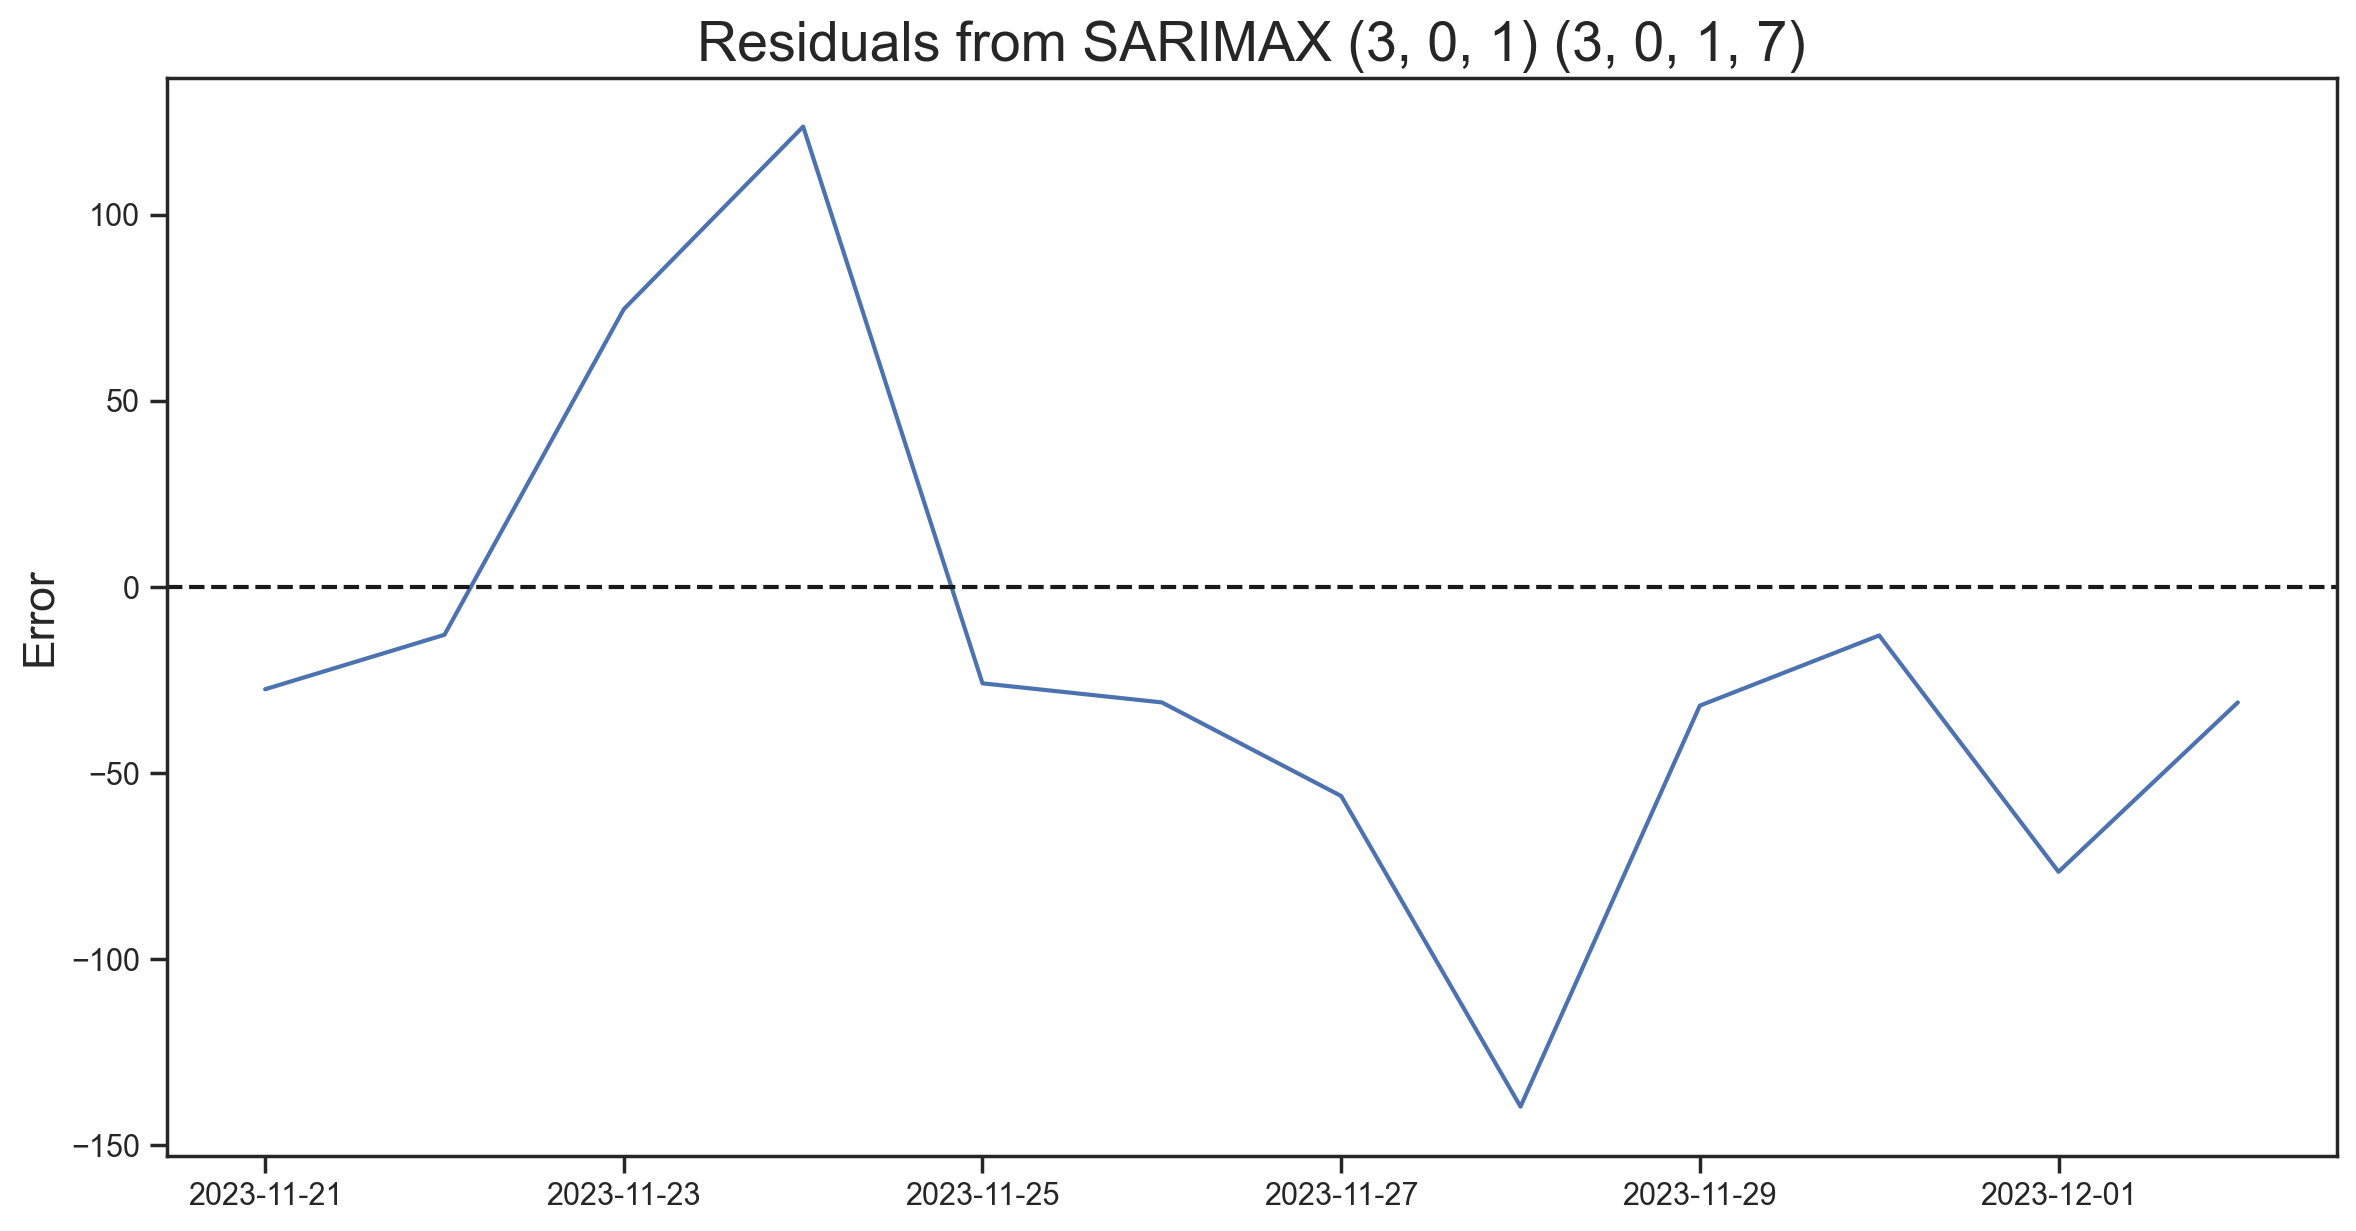

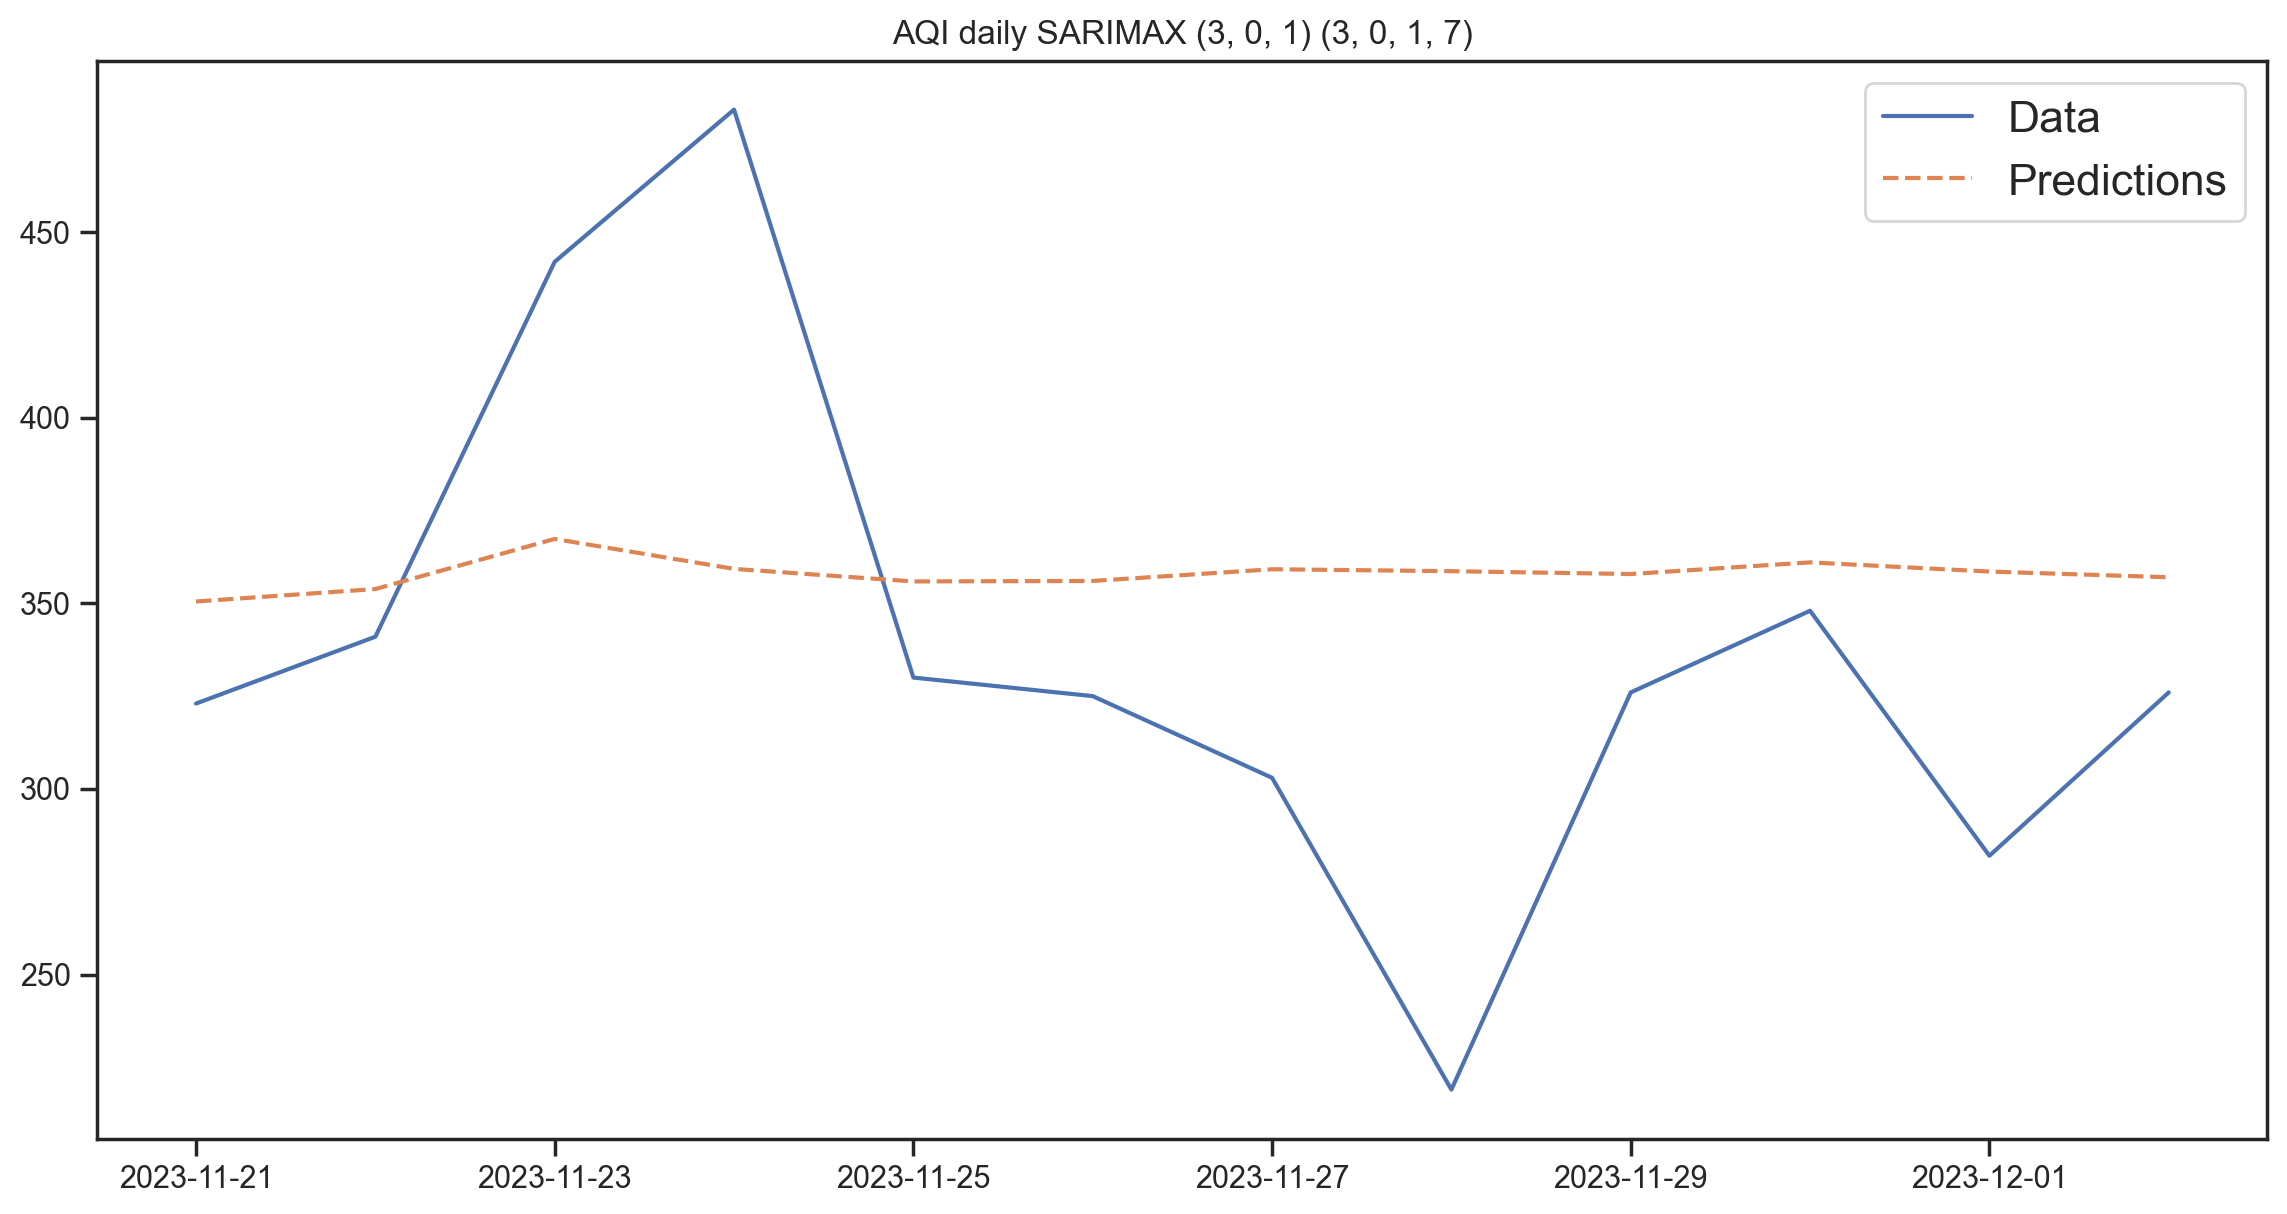

In [259]:
combinations = [[(3, 0, 1), (3, 0, 1, 7)]]
for order, seasonal_order in combinations:
    print(order, seasonal_order)
    results = without_rolling_model(df, order, seasonal_order, datetime(2023, 11, 20), datetime(2023, 12, 2), results)

In [244]:
results

train_end   test_end  p  d  q  P  D  Q   s   MSE MAE      MAPE Rolling?  \
0 2023-11-20 2023-12-02  1  0  1  0  0  0   0   536  19  0.055139     True   
0 2023-11-20 2023-12-02  1  0  1  1  0  1   7   490  16  0.044696     True   
0 2023-11-20 2023-12-02  1  0  1  1  0  1  30   408  17  0.048423     True   
0 2023-11-20 2023-12-02  1  0  1  1  0  1   7  6876  67  0.187624    False   
0 2023-11-20 2023-12-02  1  0  1  1  0  1  30  6876  67  0.187624    False   
0 2023-11-20 2023-12-02  3  0  1  3  0  1   7  4420  52  0.163380    False   

     AIC    BIC  
0  15382  15398  
0  15356  15382  
0  15381  15407  
0  15247  15273  
0  15247  15273  
0  15147  15184

In [262]:
results

train_end   test_end  p  d  q  P  D  Q   s    MSE MAE      MAPE Rolling?  \
0 2023-11-20 2023-12-02  1  0  1  1  0  1   7    490  16  0.044696     True   
0 2023-11-20 2023-12-02  1  0  1  1  0  1  30    408  17  0.048423     True   
0 2023-11-20 2023-12-02  3  0  1  3  0  1   7   4509  54  0.170570    False   
0 2023-11-25 2023-12-02  1  0  0  1  1  0   7  10750  81  0.291416    False   
0 2023-11-25 2023-12-02  1  0  1  1  1  0   7  10704  81  0.290274    False   
0 2023-11-25 2023-12-02  1  0  1  1  1  1   7   2049  36  0.131509    False   

     AIC    BIC  
0  15356  15382  
0  15381  15407  
0  15152  15199  
0  15561  15577  
0  15563  15584  
0  15211  15237

(1, 0, 0) (1, 1, 0, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.73342D+00    |proj g|=  6.24419D-02


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  5.72862D+00    |proj g|=  5.01108D-03

At iterate   10    f=  5.71942D+00    |proj g|=  3.81813D-02

At iterate   15    f=  5.71458D+00    |proj g|=  5.12624D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   3.060D-06   5.715D+00
  F =   5.7145836968132864     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
(1, 0, 1) (1, 1, 0, 7)


/var/folders/27/b03t8q596qvcmtyqjtnh0w6w0000gn/T/ipykernel_5869/1689733556.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results = pd.concat([results, pd.DataFrame.from_dict(result)])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.73362D+00    |proj g|=  6.19294D-02

At iterate    5    f=  5.72881D+00    |proj g|=  2.56564D-03

At iterate   10    f=  5.72284D+00    |proj g|=  1.91882D-02

At iterate   15    f=  5.71461D+00    |proj g|=  3.08714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   7.772D-07   5.715D+00
  F =   5.7145647219748703     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/var/folders/27/b03t8q596qvcmtyqjtnh0w6w0000gn/T/ipykernel_5869/1689733556.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results = pd.concat([results, pd.DataFrame.from_dict(result)])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 0, 1) (1, 1, 1, 7)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70308D+00    |proj g|=  1.05266D-01


 This problem is unconstrained.



At iterate    5    f=  5.65312D+00    |proj g|=  2.24173D-02

At iterate   10    f=  5.63850D+00    |proj g|=  5.26946D-03

At iterate   15    f=  5.60637D+00    |proj g|=  5.96278D-03

At iterate   20    f=  5.59808D+00    |proj g|=  4.95073D-02

At iterate   25    f=  5.58450D+00    |proj g|=  2.57401D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     40      1     0     0   4.183D-06   5.585D+00
  F =   5.5845004802042917     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/var/folders/27/b03t8q596qvcmtyqjtnh0w6w0000gn/T/ipykernel_5869/1689733556.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results = pd.concat([results, pd.DataFrame.from_dict(result)])


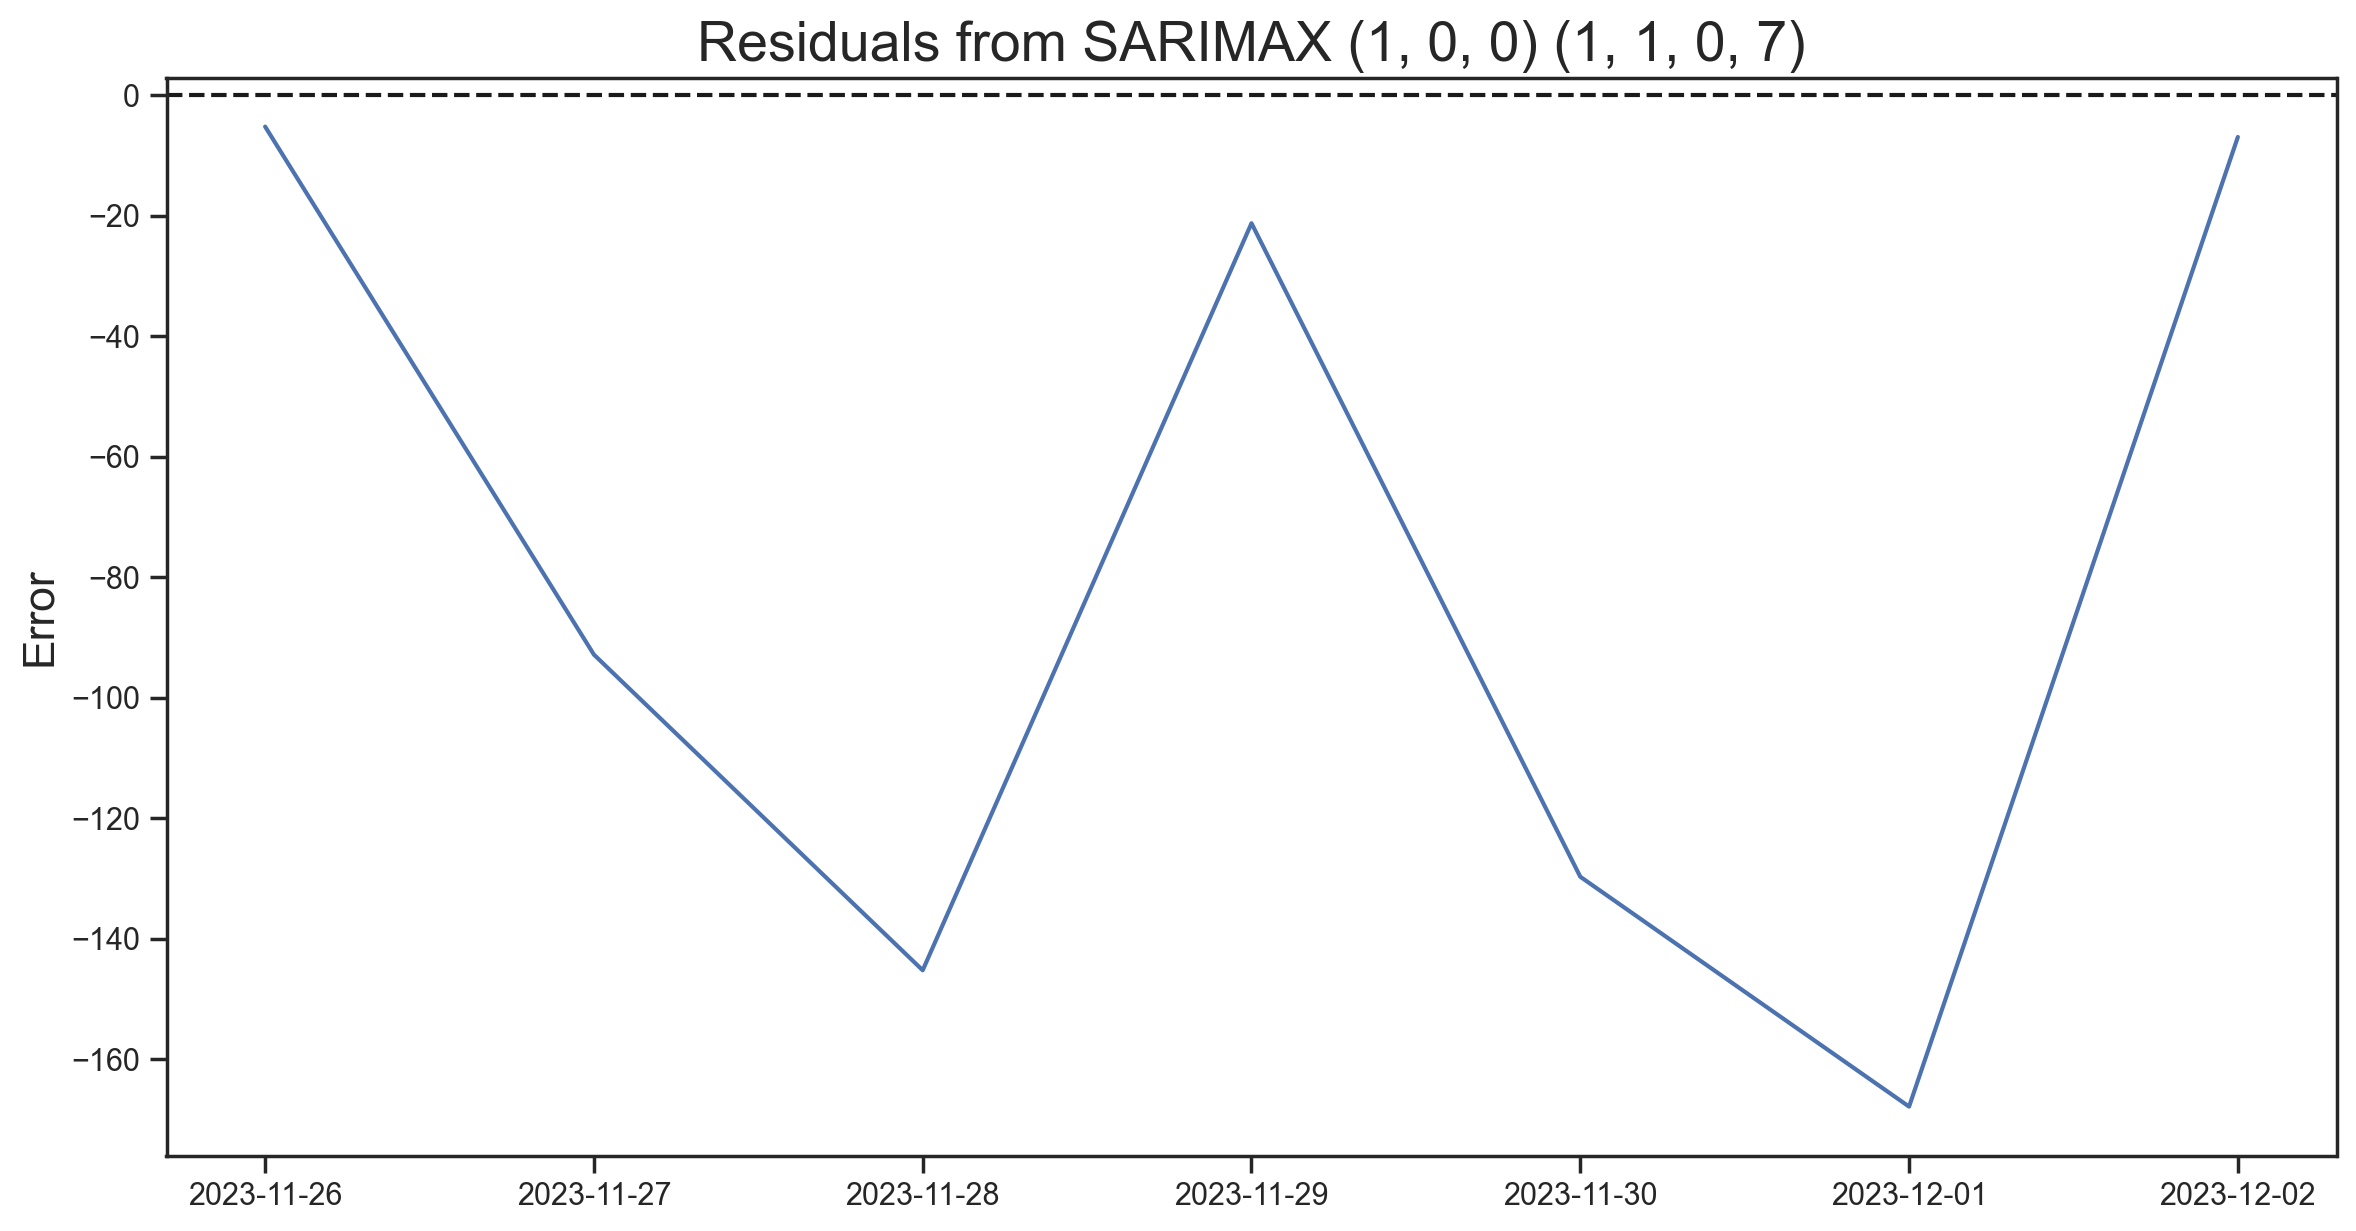

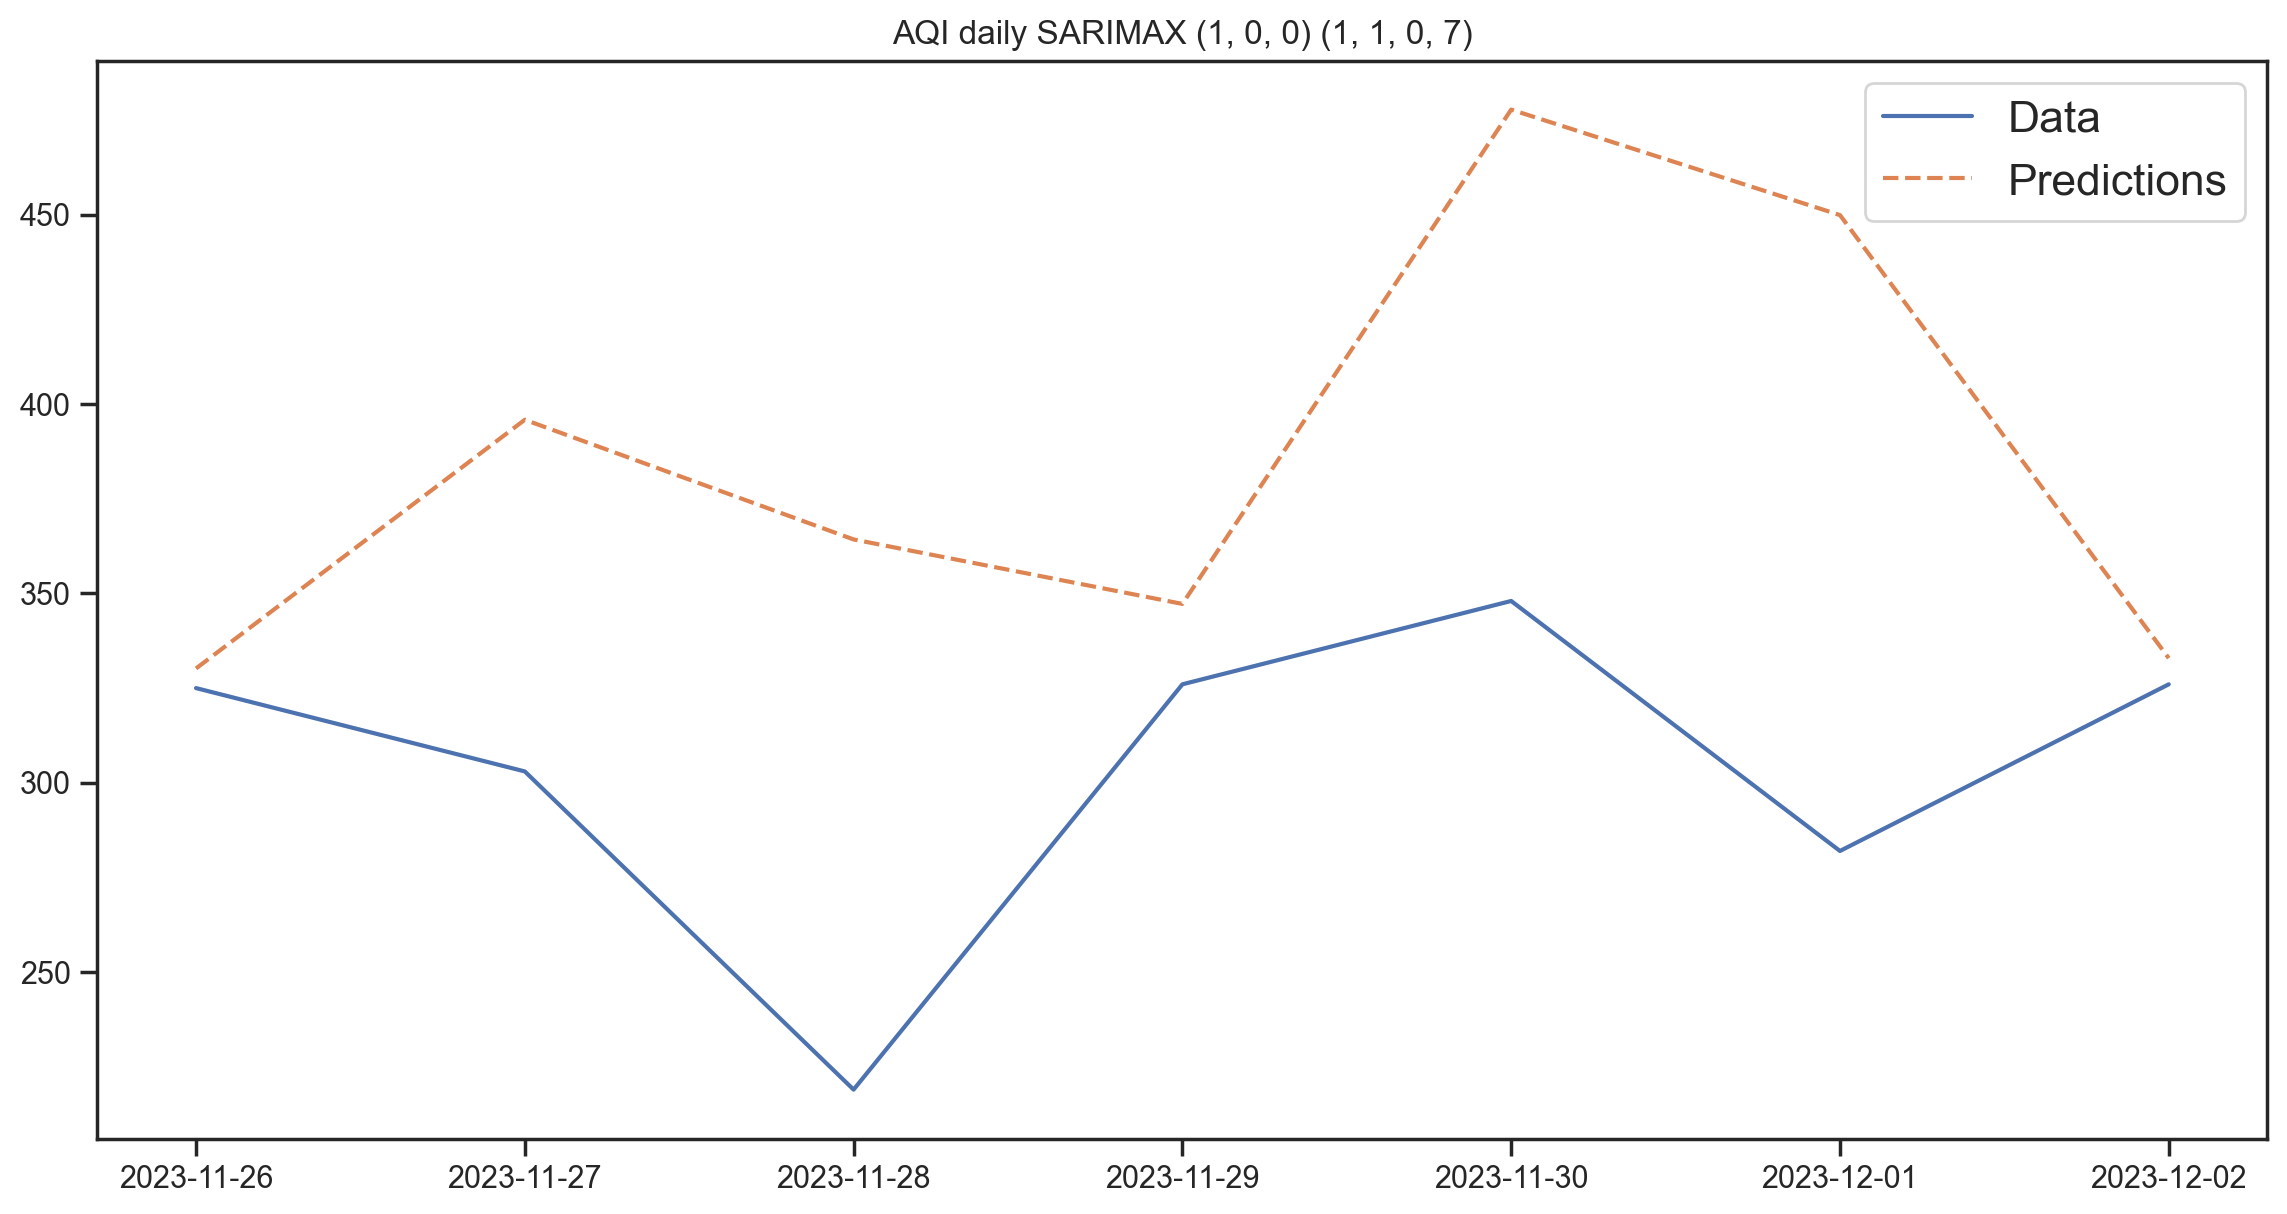

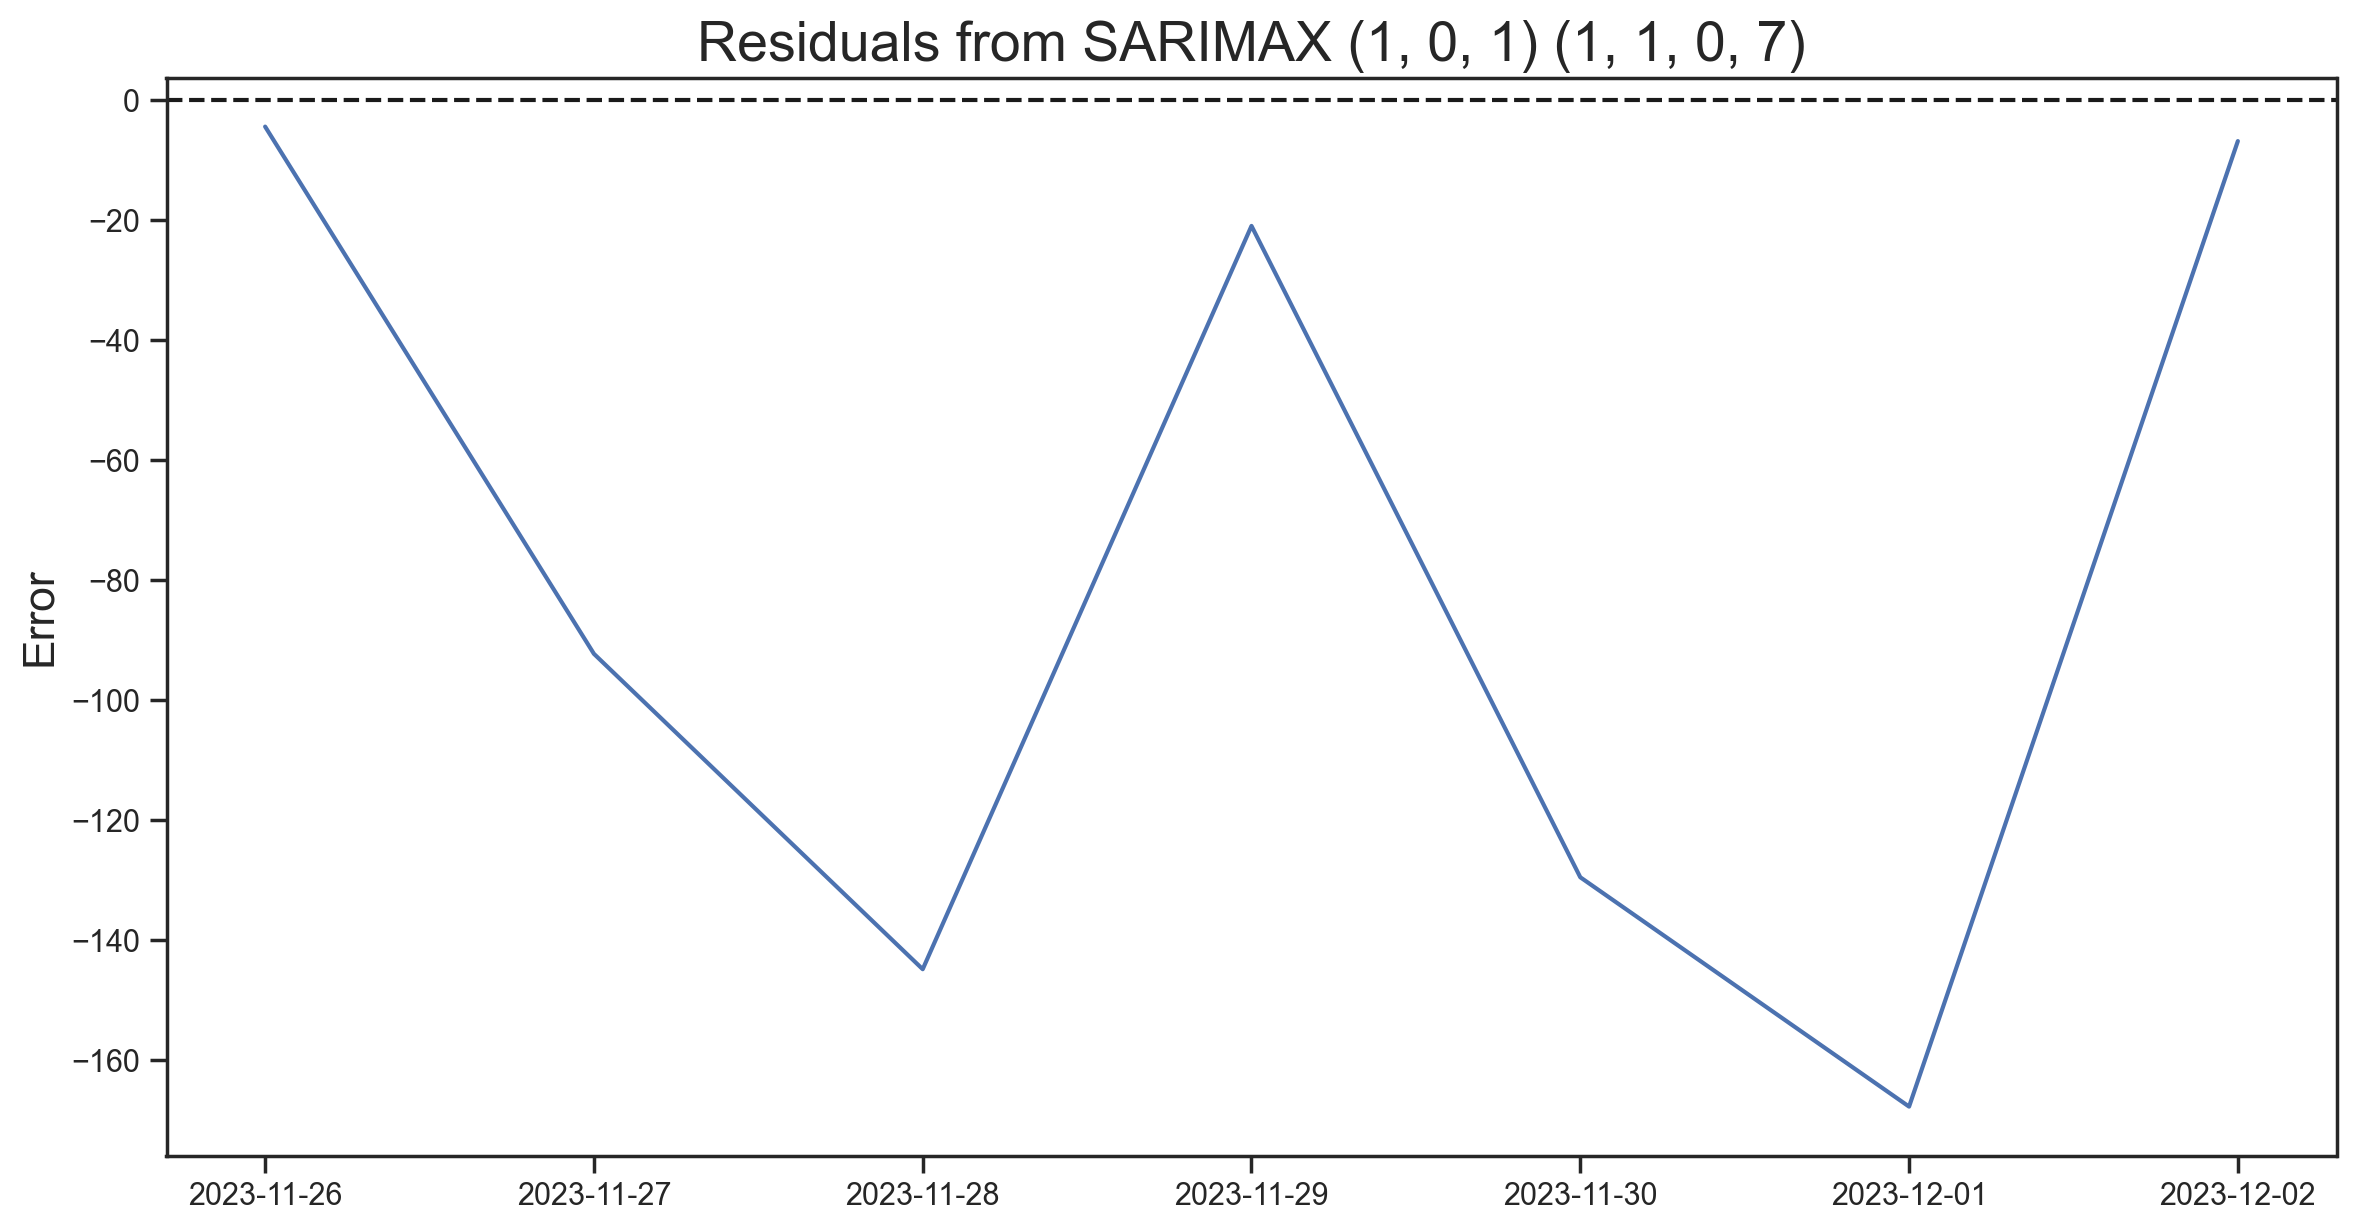

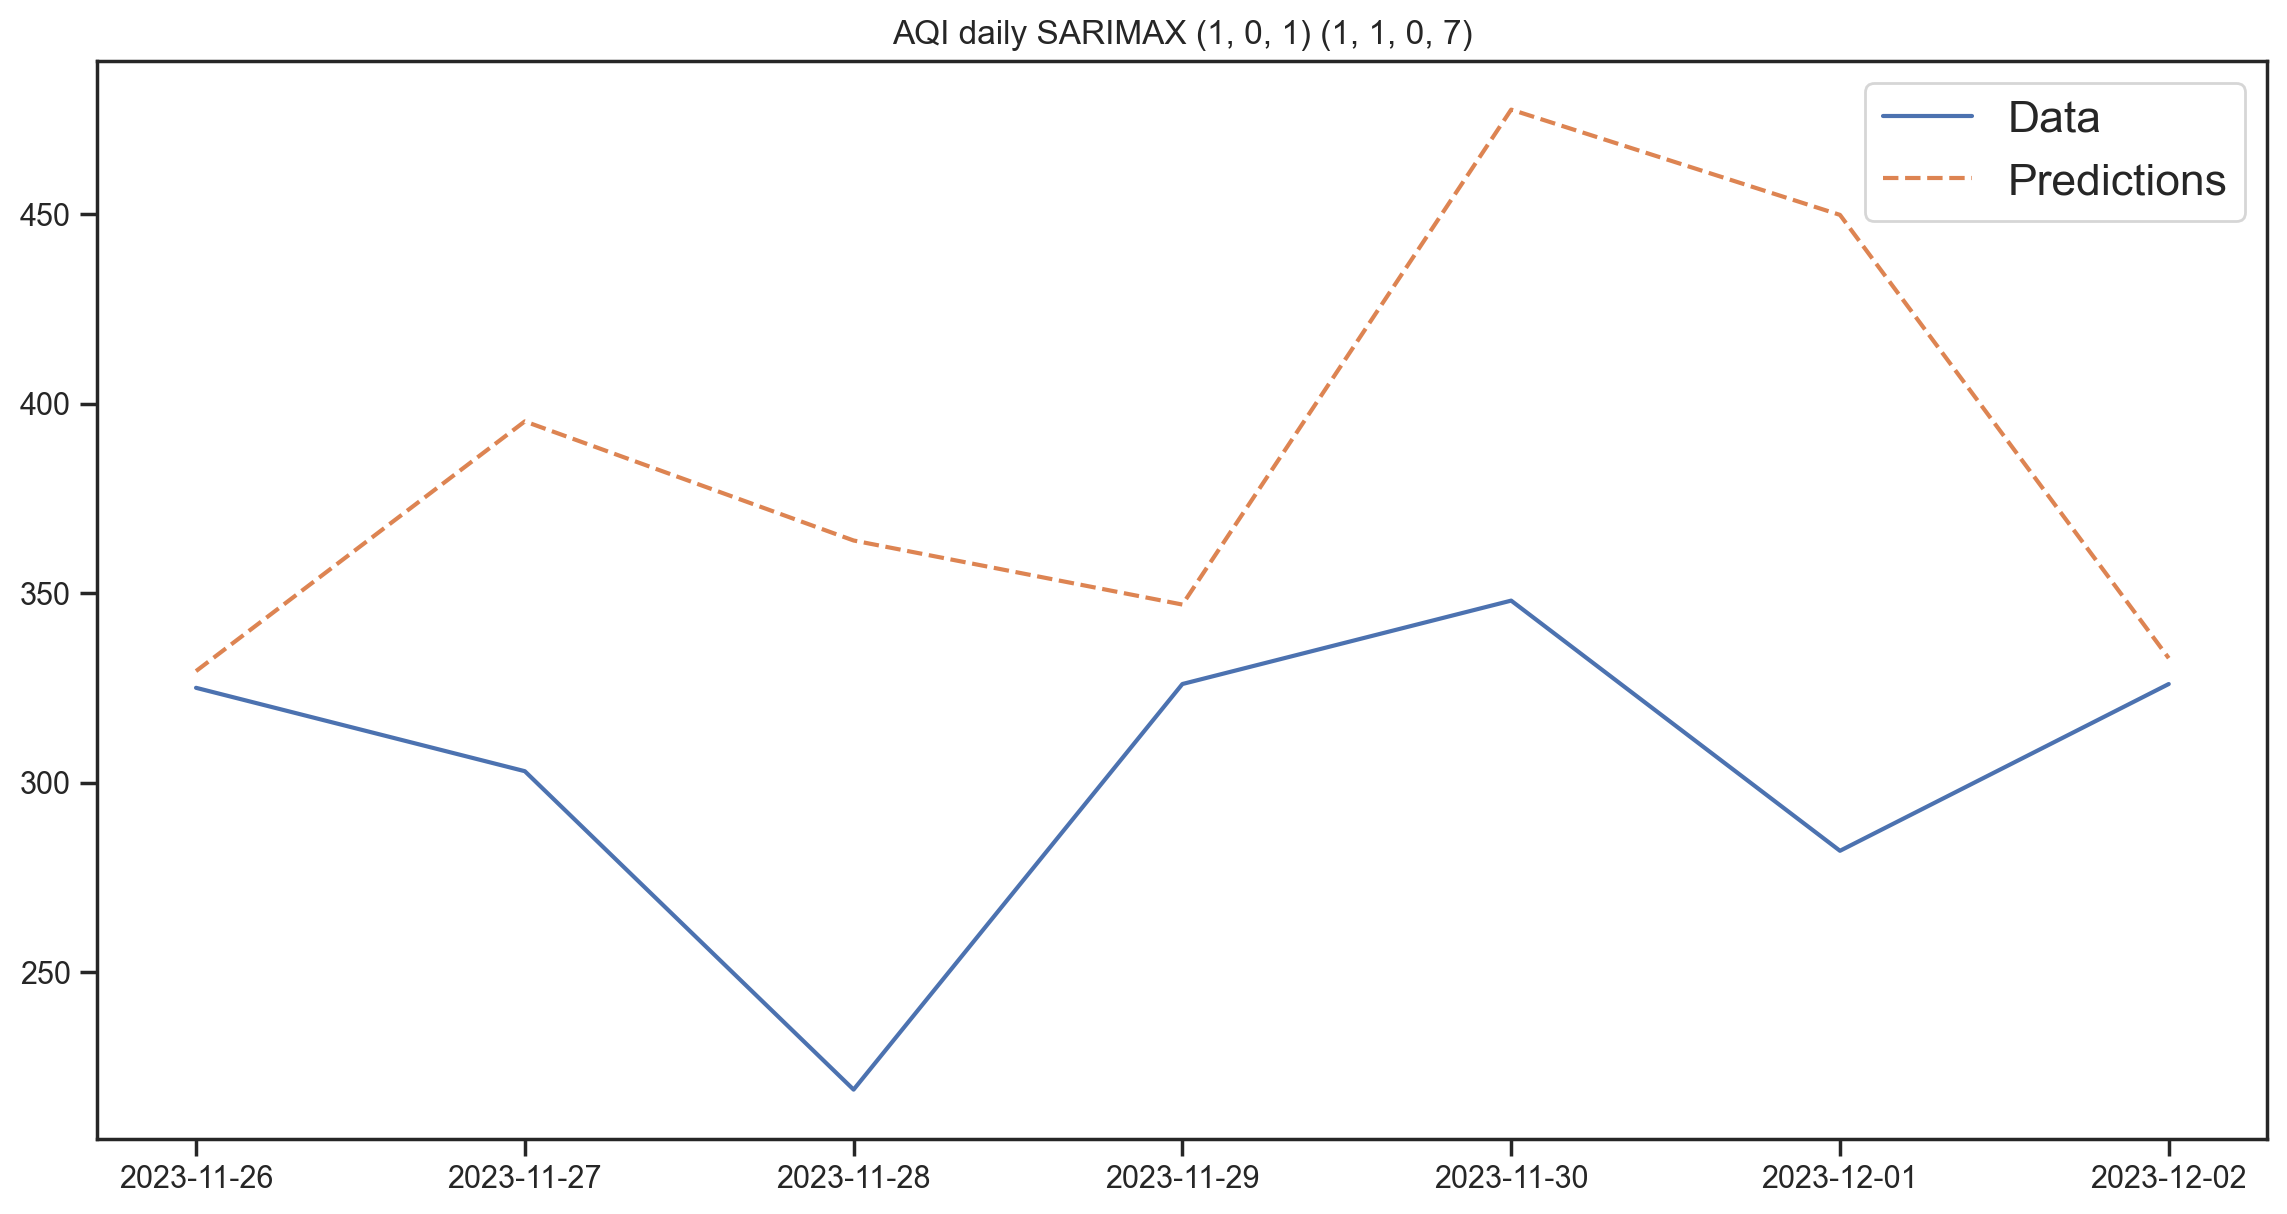

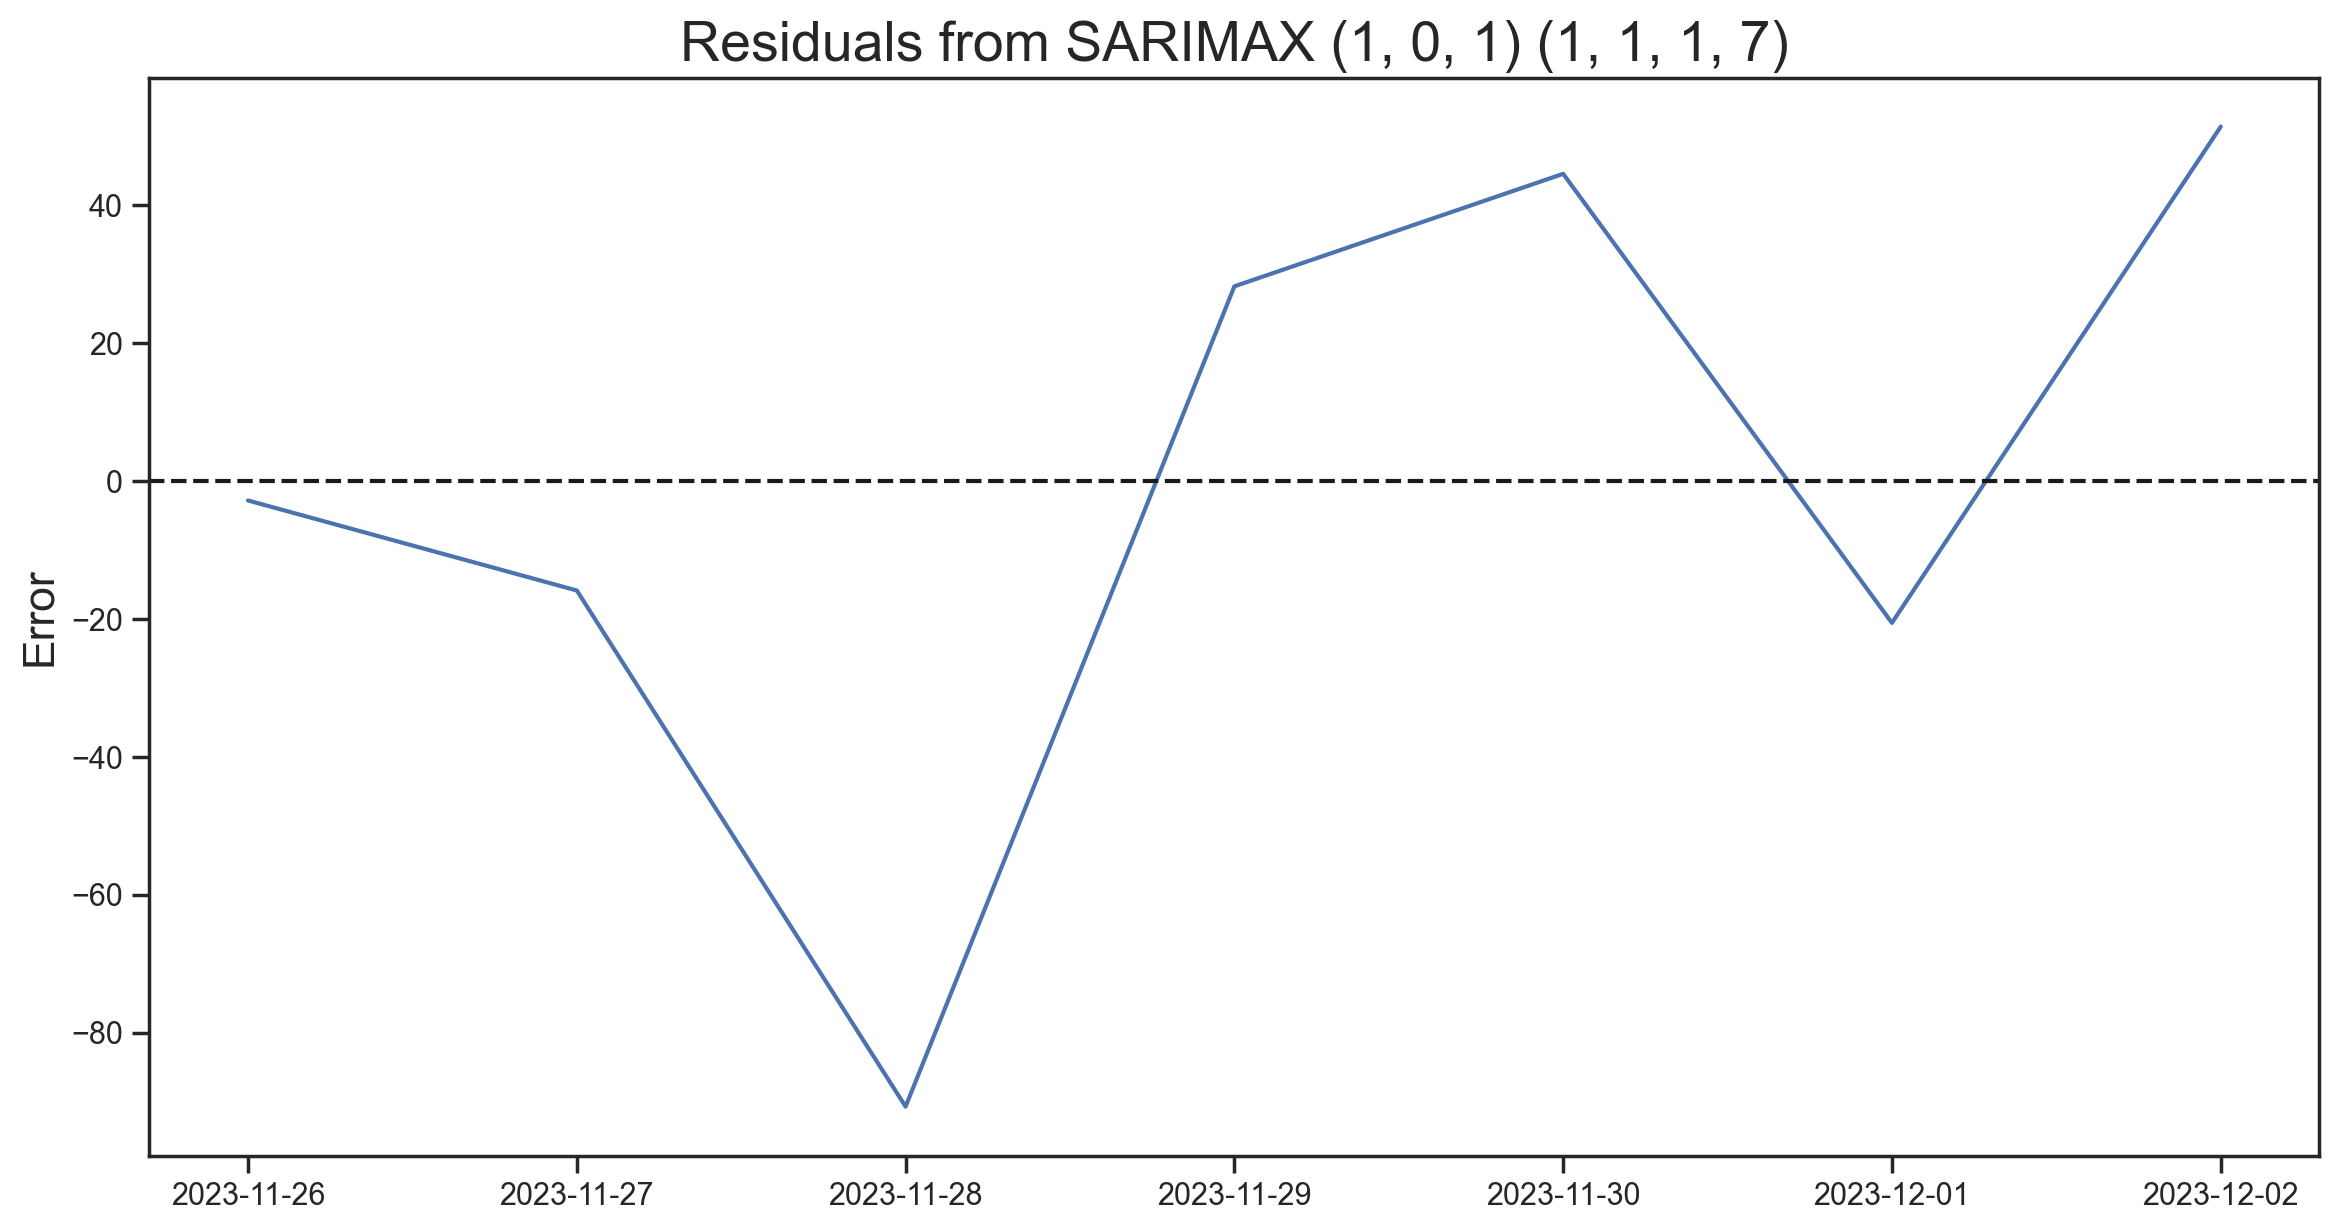

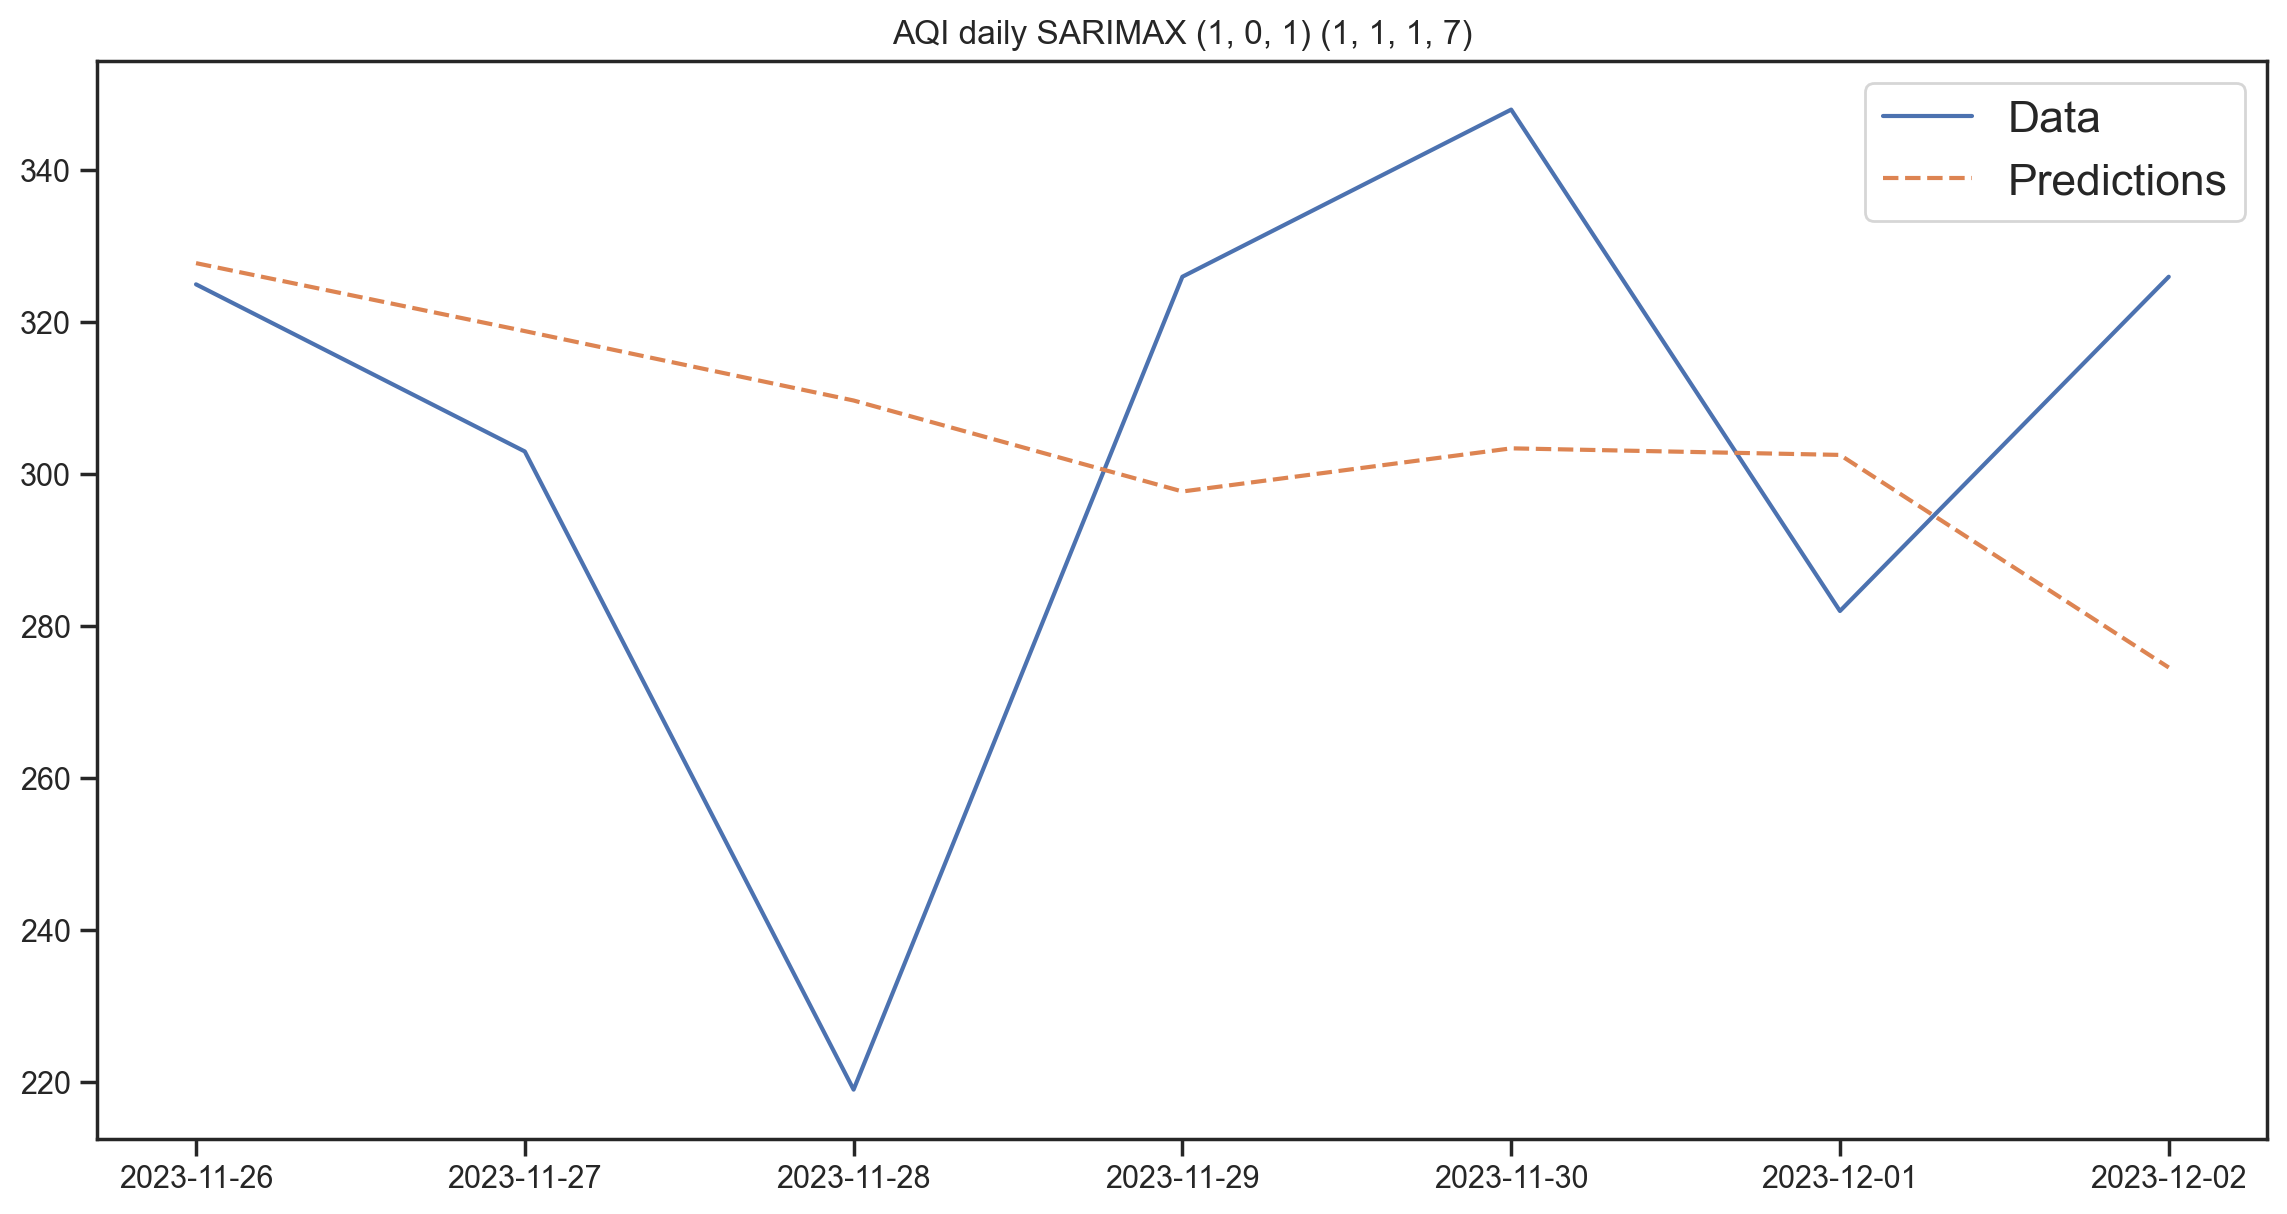

In [261]:
combinations = [[(1, 0, 0), (1, 1, 0, 7)], [(1, 0, 1), (1, 1, 0, 7)], [(1, 0, 1), (1, 1, 1, 7)]]

for order, seasonal_order in combinations:
    print(order, seasonal_order)
    results = without_rolling_model(df, order, seasonal_order, datetime(2023, 11, 25), datetime(2023, 12, 2), results)

In [246]:
results

train_end   test_end  p  d  q  P  D  Q   s   MSE MAE      MAPE Rolling?  \
0 2023-11-20 2023-12-02  1  0  1  0  0  0   0   536  19  0.055139     True   
0 2023-11-20 2023-12-02  1  0  1  1  0  1   7   490  16  0.044696     True   
0 2023-11-20 2023-12-02  1  0  1  1  0  1  30   408  17  0.048423     True   
0 2023-11-20 2023-12-02  1  0  1  1  0  1   7  6876  67  0.187624    False   
0 2023-11-20 2023-12-02  1  0  1  1  0  1  30  6876  67  0.187624    False   
0 2023-11-20 2023-12-02  3  0  1  3  0  1   7  4420  52  0.163380    False   
0 2023-11-20 2023-12-02  1  0  0  1  1  0   7  9939  84  0.234391    False   
0 2023-11-20 2023-12-02  1  0  1  1  1  0   7  6876  67  0.187624    False   
0 2023-11-20 2023-12-02  1  0  1  1  1  1   7  6876  67  0.187624    False   

     AIC    BIC  
0  15382  15398  
0  15356  15382  
0  15381  15407  
0  15247  15273  
0  15247  15273  
0  15147  15184  
0  15278  15299  
0  15247  15273  
0  15247  15273

## Changing train data - forecast 5 days

(1, 0, 1) (1, 0, 1, 7)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70390D+00    |proj g|=  1.59741D-01

At iterate    5    f=  5.62351D+00    |proj g|=  6.81604D-04

At iterate   10    f=  5.62253D+00    |proj g|=  1.19673D-03

At iterate   15    f=  5.62172D+00    |proj g|=  1.14337D-02

At iterate   20    f=  5.61584D+00    |proj g|=  3.11932D-03

At iterate   25    f=  5.61415D+00    |proj g|=  4.30170D-03

At iterate   30    f=  5.61363D+00    |proj g|=  4.71992D-04

At iterate   35    f=  5.61350D+00    |proj g|=  1.19217D-03

At iterate   40    f=  5.61341D+00    |proj g|=  5.41876D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/var/folders/27/b03t8q596qvcmtyqjtnh0w6w0000gn/T/ipykernel_5869/1689733556.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results = pd.concat([results, pd.DataFrame.from_dict(result)])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.74484D+00    |proj g|=  1.62471D-01


 This problem is unconstrained.



At iterate    5    f=  5.64362D+00    |proj g|=  7.17902D-02

At iterate   10    f=  5.61198D+00    |proj g|=  7.71974D-03

At iterate   15    f=  5.60491D+00    |proj g|=  4.81406D-02

At iterate   20    f=  5.59248D+00    |proj g|=  1.81313D-02

At iterate   25    f=  5.58323D+00    |proj g|=  8.86689D-03

At iterate   30    f=  5.58136D+00    |proj g|=  1.30901D-03

At iterate   35    f=  5.58130D+00    |proj g|=  4.35629D-04

At iterate   40    f=  5.58102D+00    |proj g|=  1.21190D-02

At iterate   45    f=  5.58058D+00    |proj g|=  2.27155D-03


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.58055D+00    |proj g|=  7.51884D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56      1     0     0   7.519D-05   5.581D+00
  F =   5.5805465968915717     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/var/folders/27/b03t8q596qvcmtyqjtnh0w6w0000gn/T/ipykernel_5869/1689733556.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results = pd.concat([results, pd.DataFrame.from_dict(result)])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 0, 1) (1, 0, 1, 30)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67623D+00    |proj g|=  1.12603D-01


 This problem is unconstrained.



At iterate    5    f=  5.62454D+00    |proj g|=  4.30937D-04

At iterate   10    f=  5.62435D+00    |proj g|=  1.20639D-03

At iterate   15    f=  5.62353D+00    |proj g|=  1.05876D-03

At iterate   20    f=  5.62338D+00    |proj g|=  3.53393D-04

At iterate   25    f=  5.62293D+00    |proj g|=  2.06116D-03

At iterate   30    f=  5.62275D+00    |proj g|=  5.80402D-04

At iterate   35    f=  5.62268D+00    |proj g|=  6.15393D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     51      1     0     0   6.160D-04   5.623D+00
  F =   5.6226784237021432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/var/folders/27/b03t8q596qvcmtyqjtnh0w6w0000gn/T/ipykernel_5869/1689733556.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results = pd.concat([results, pd.DataFrame.from_dict(result)])


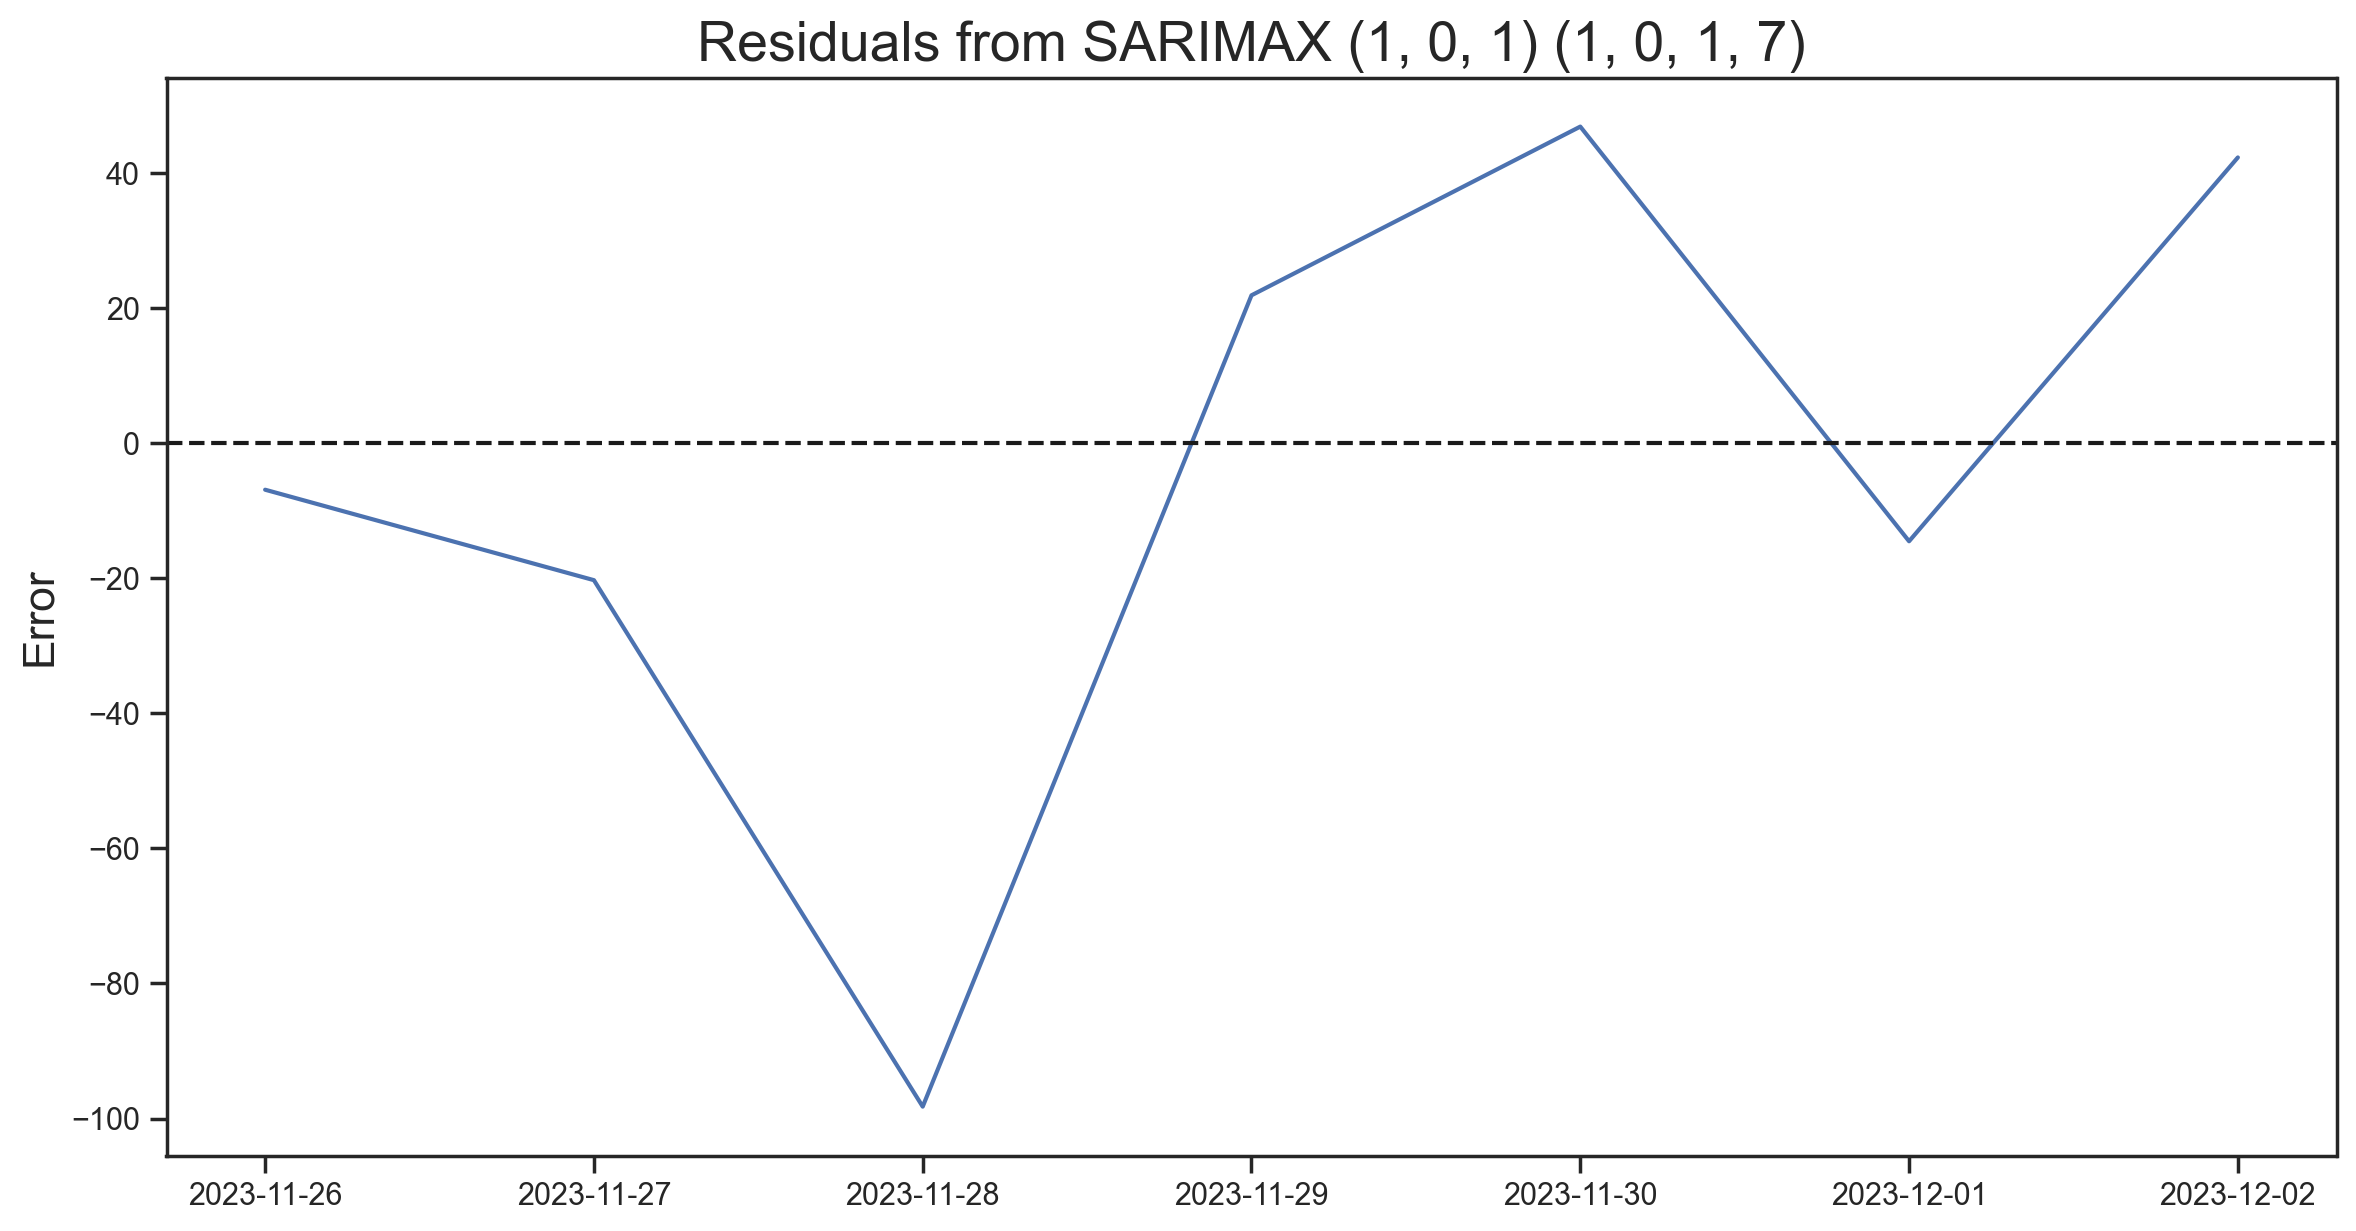

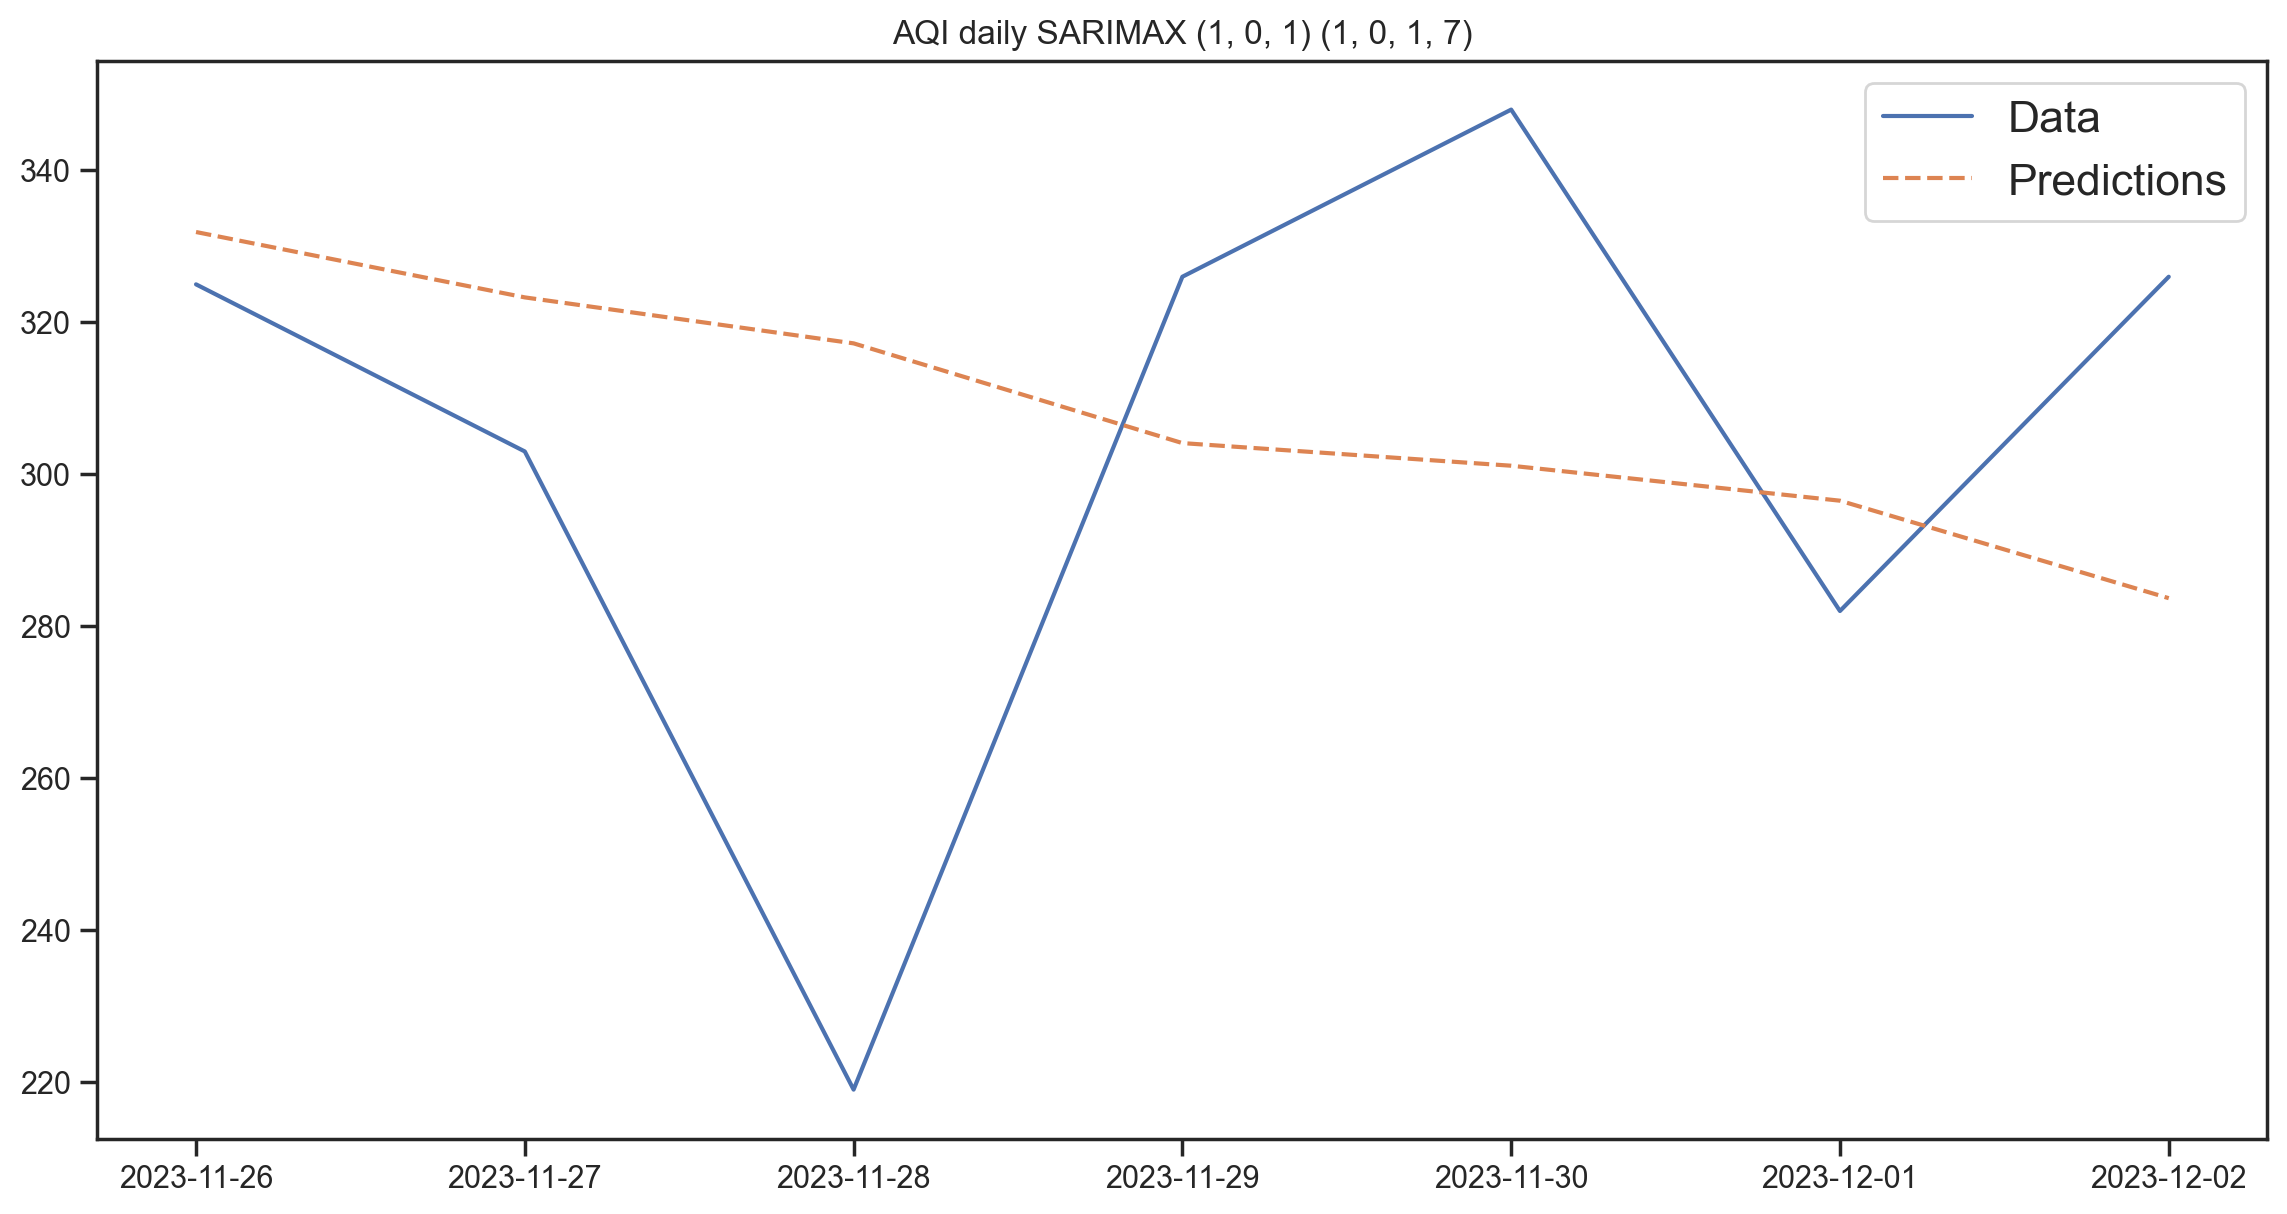

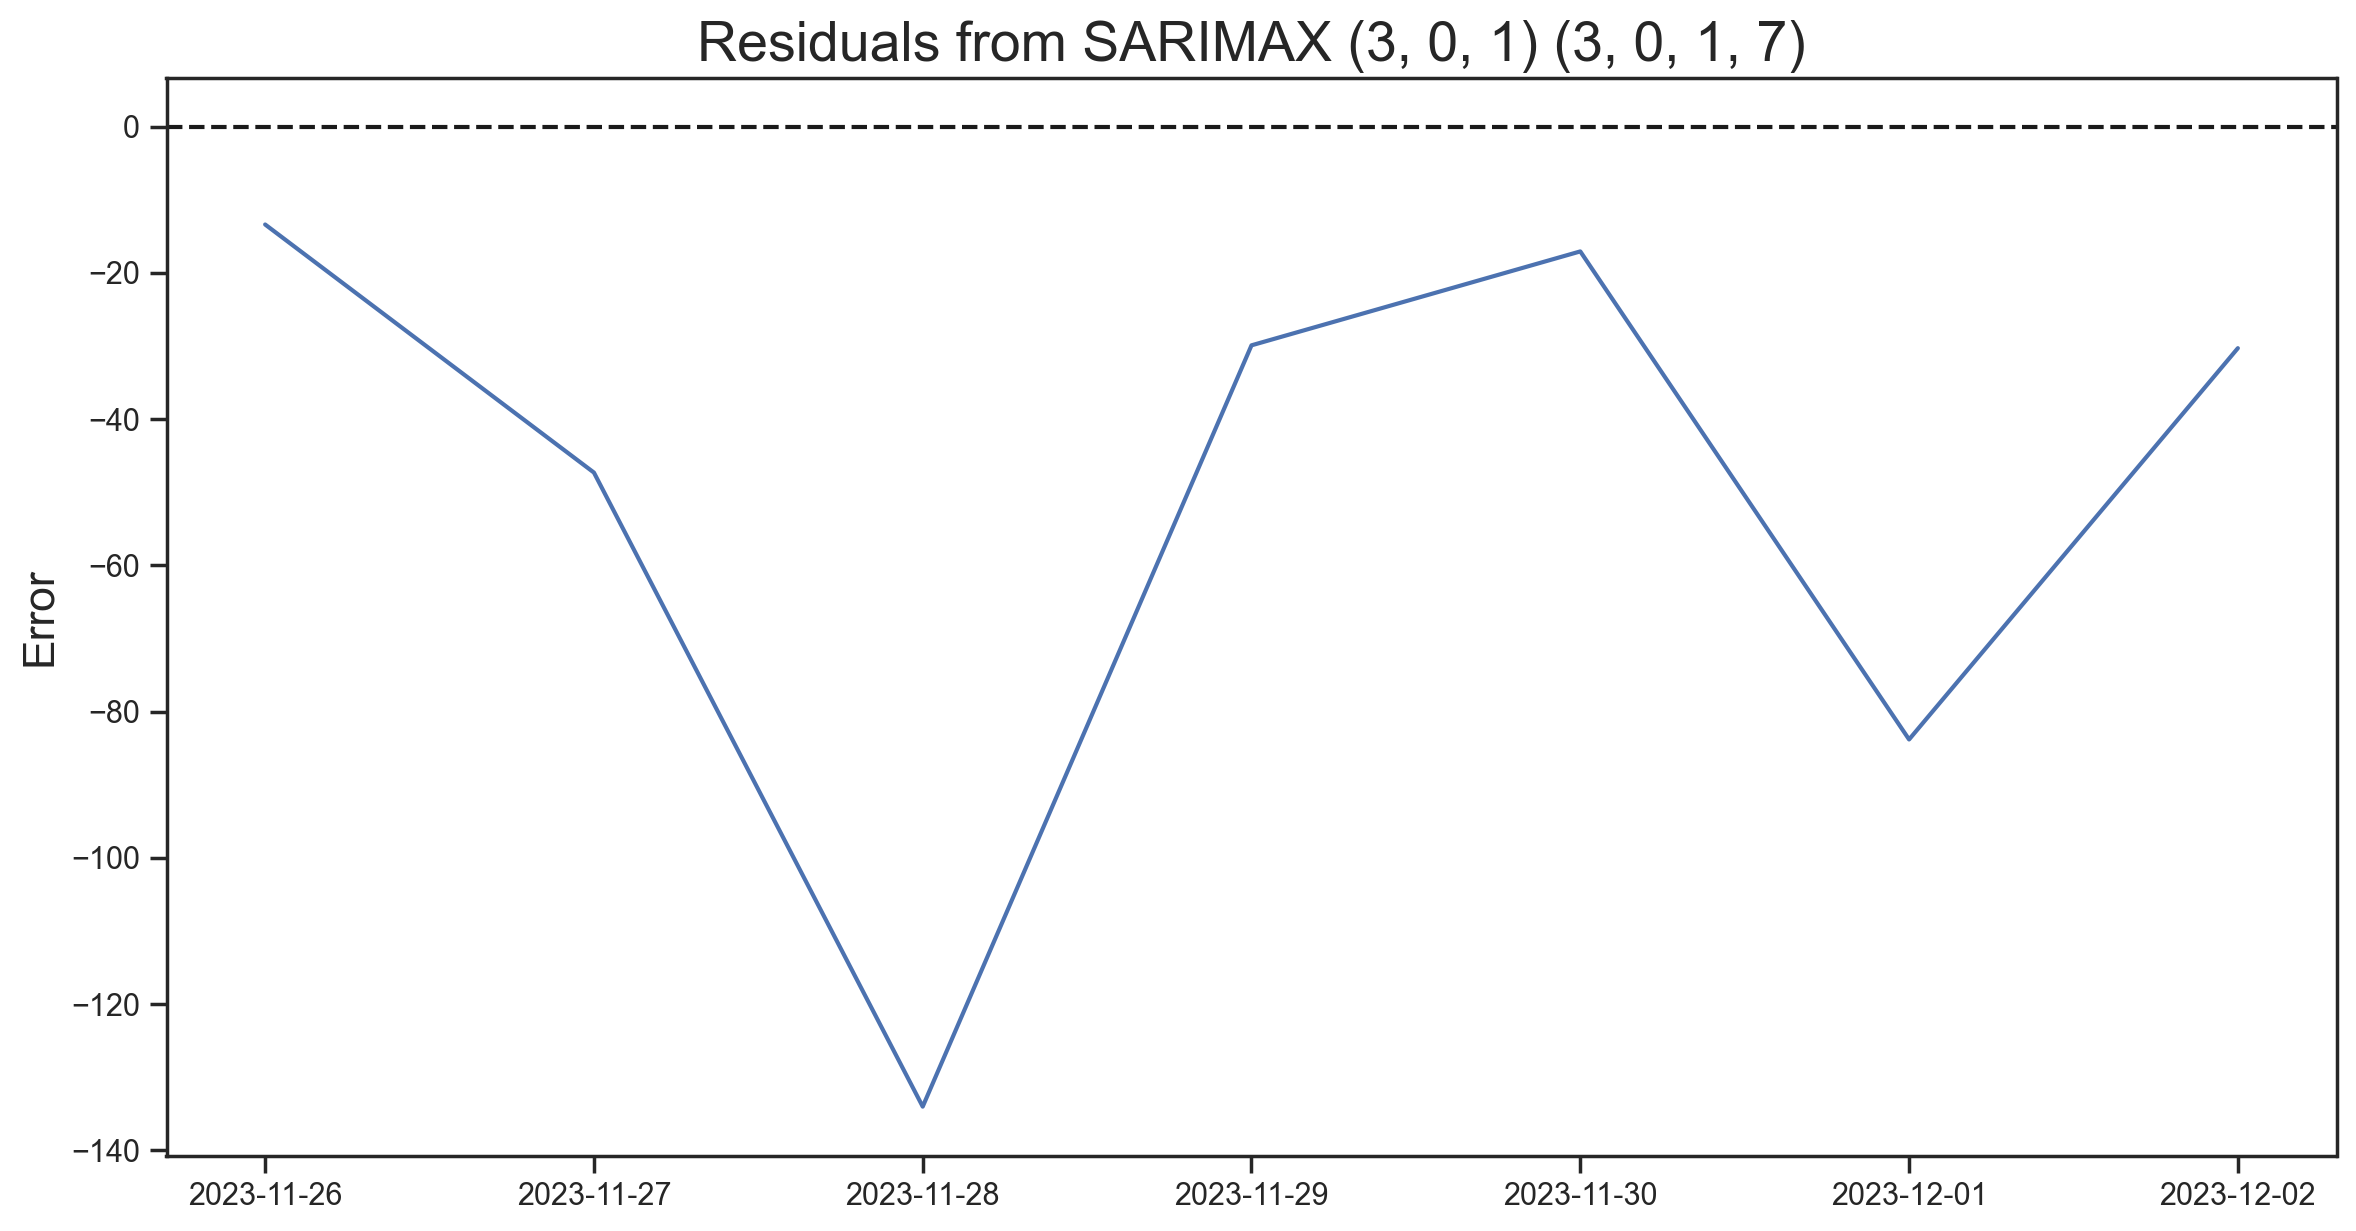

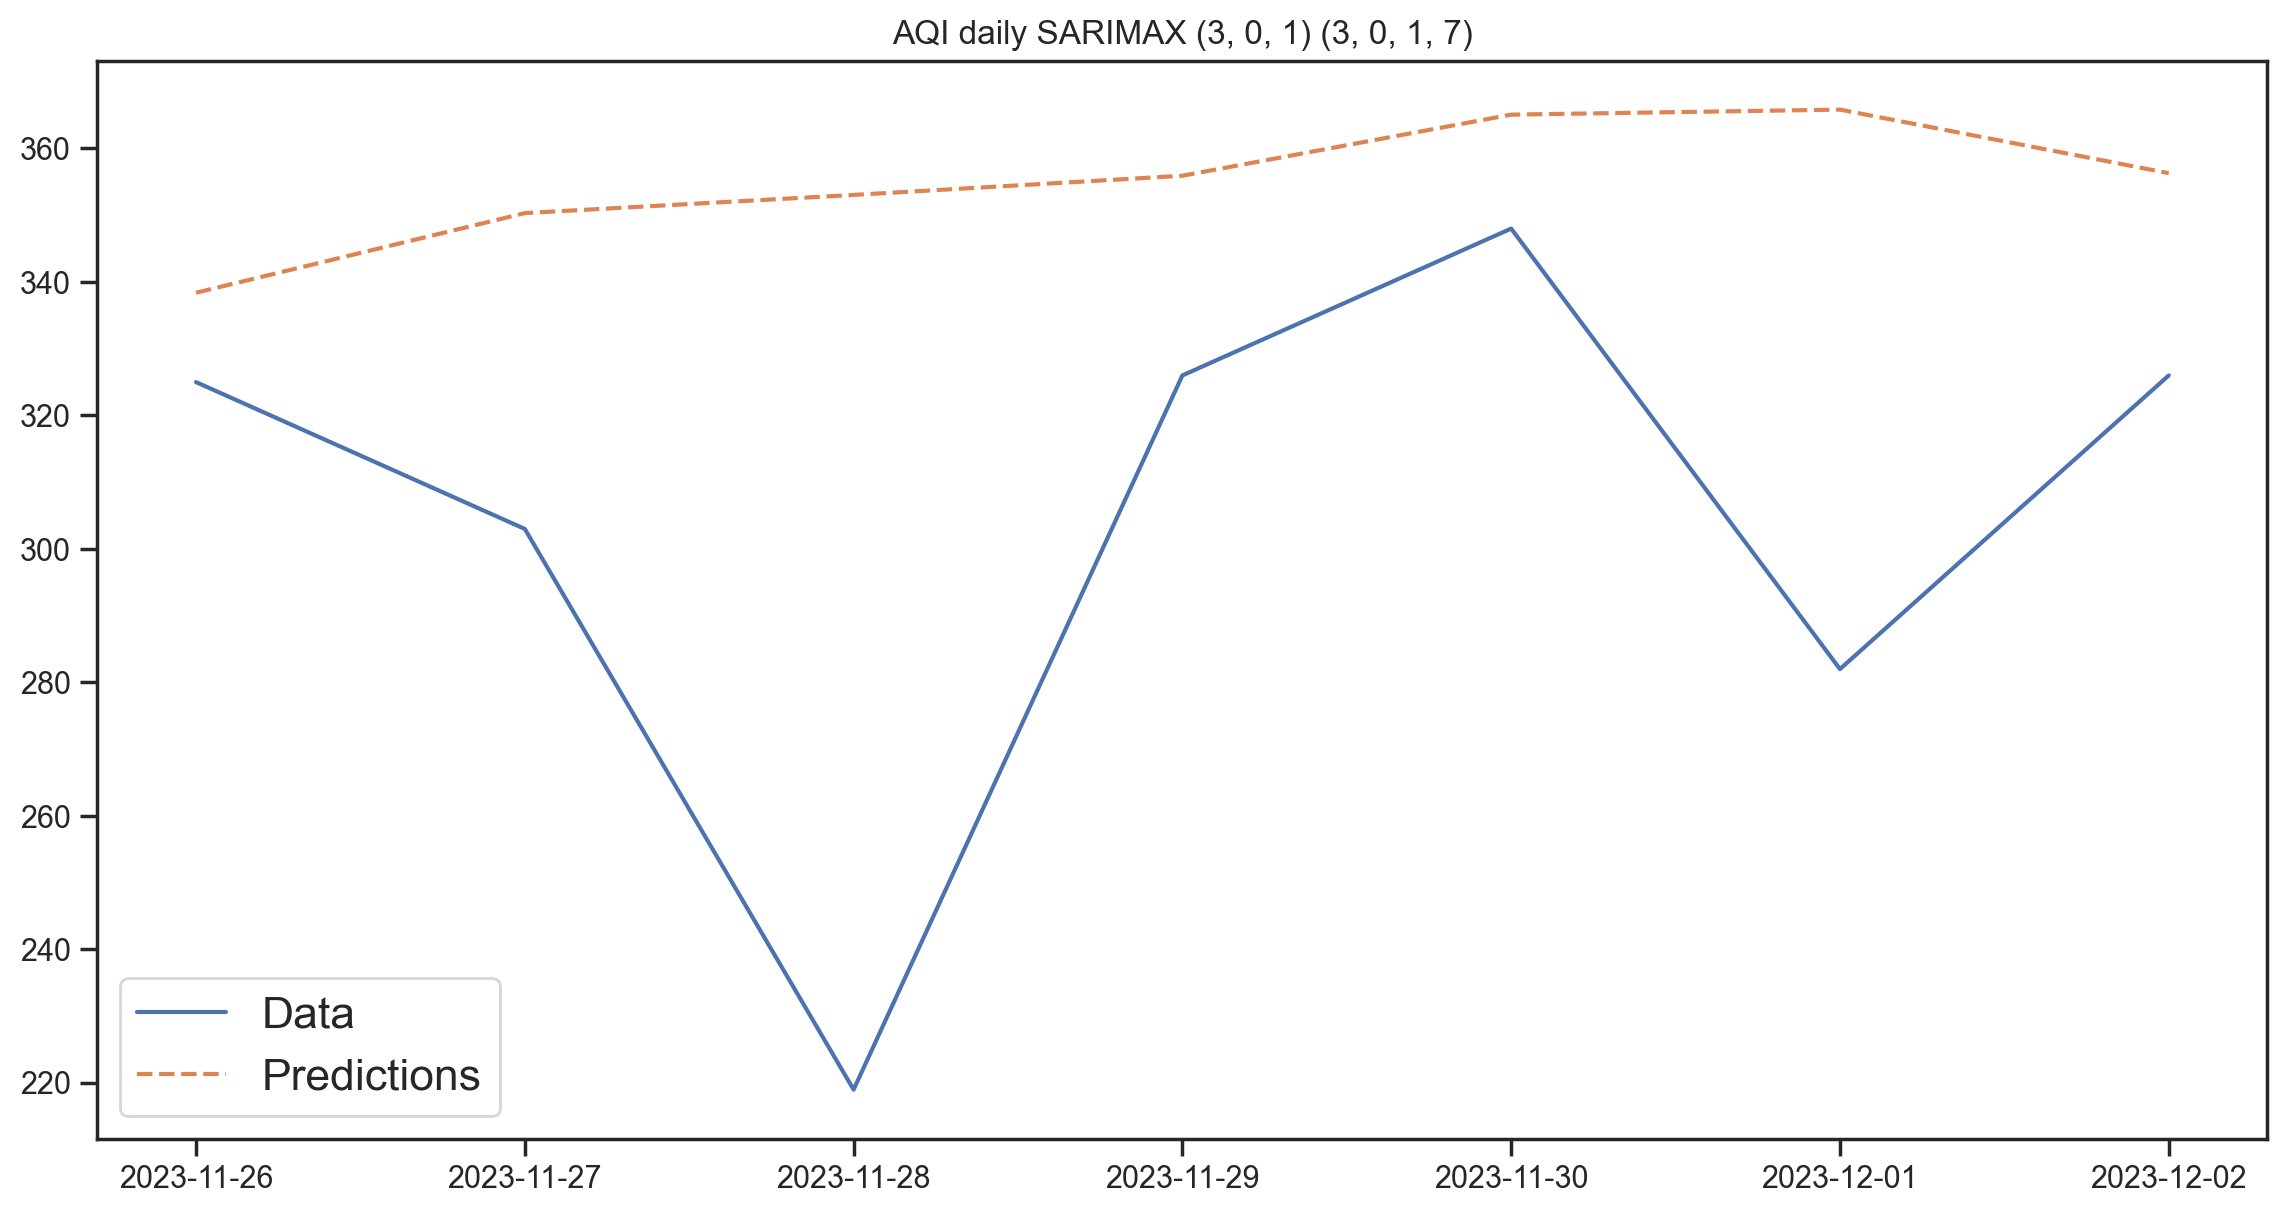

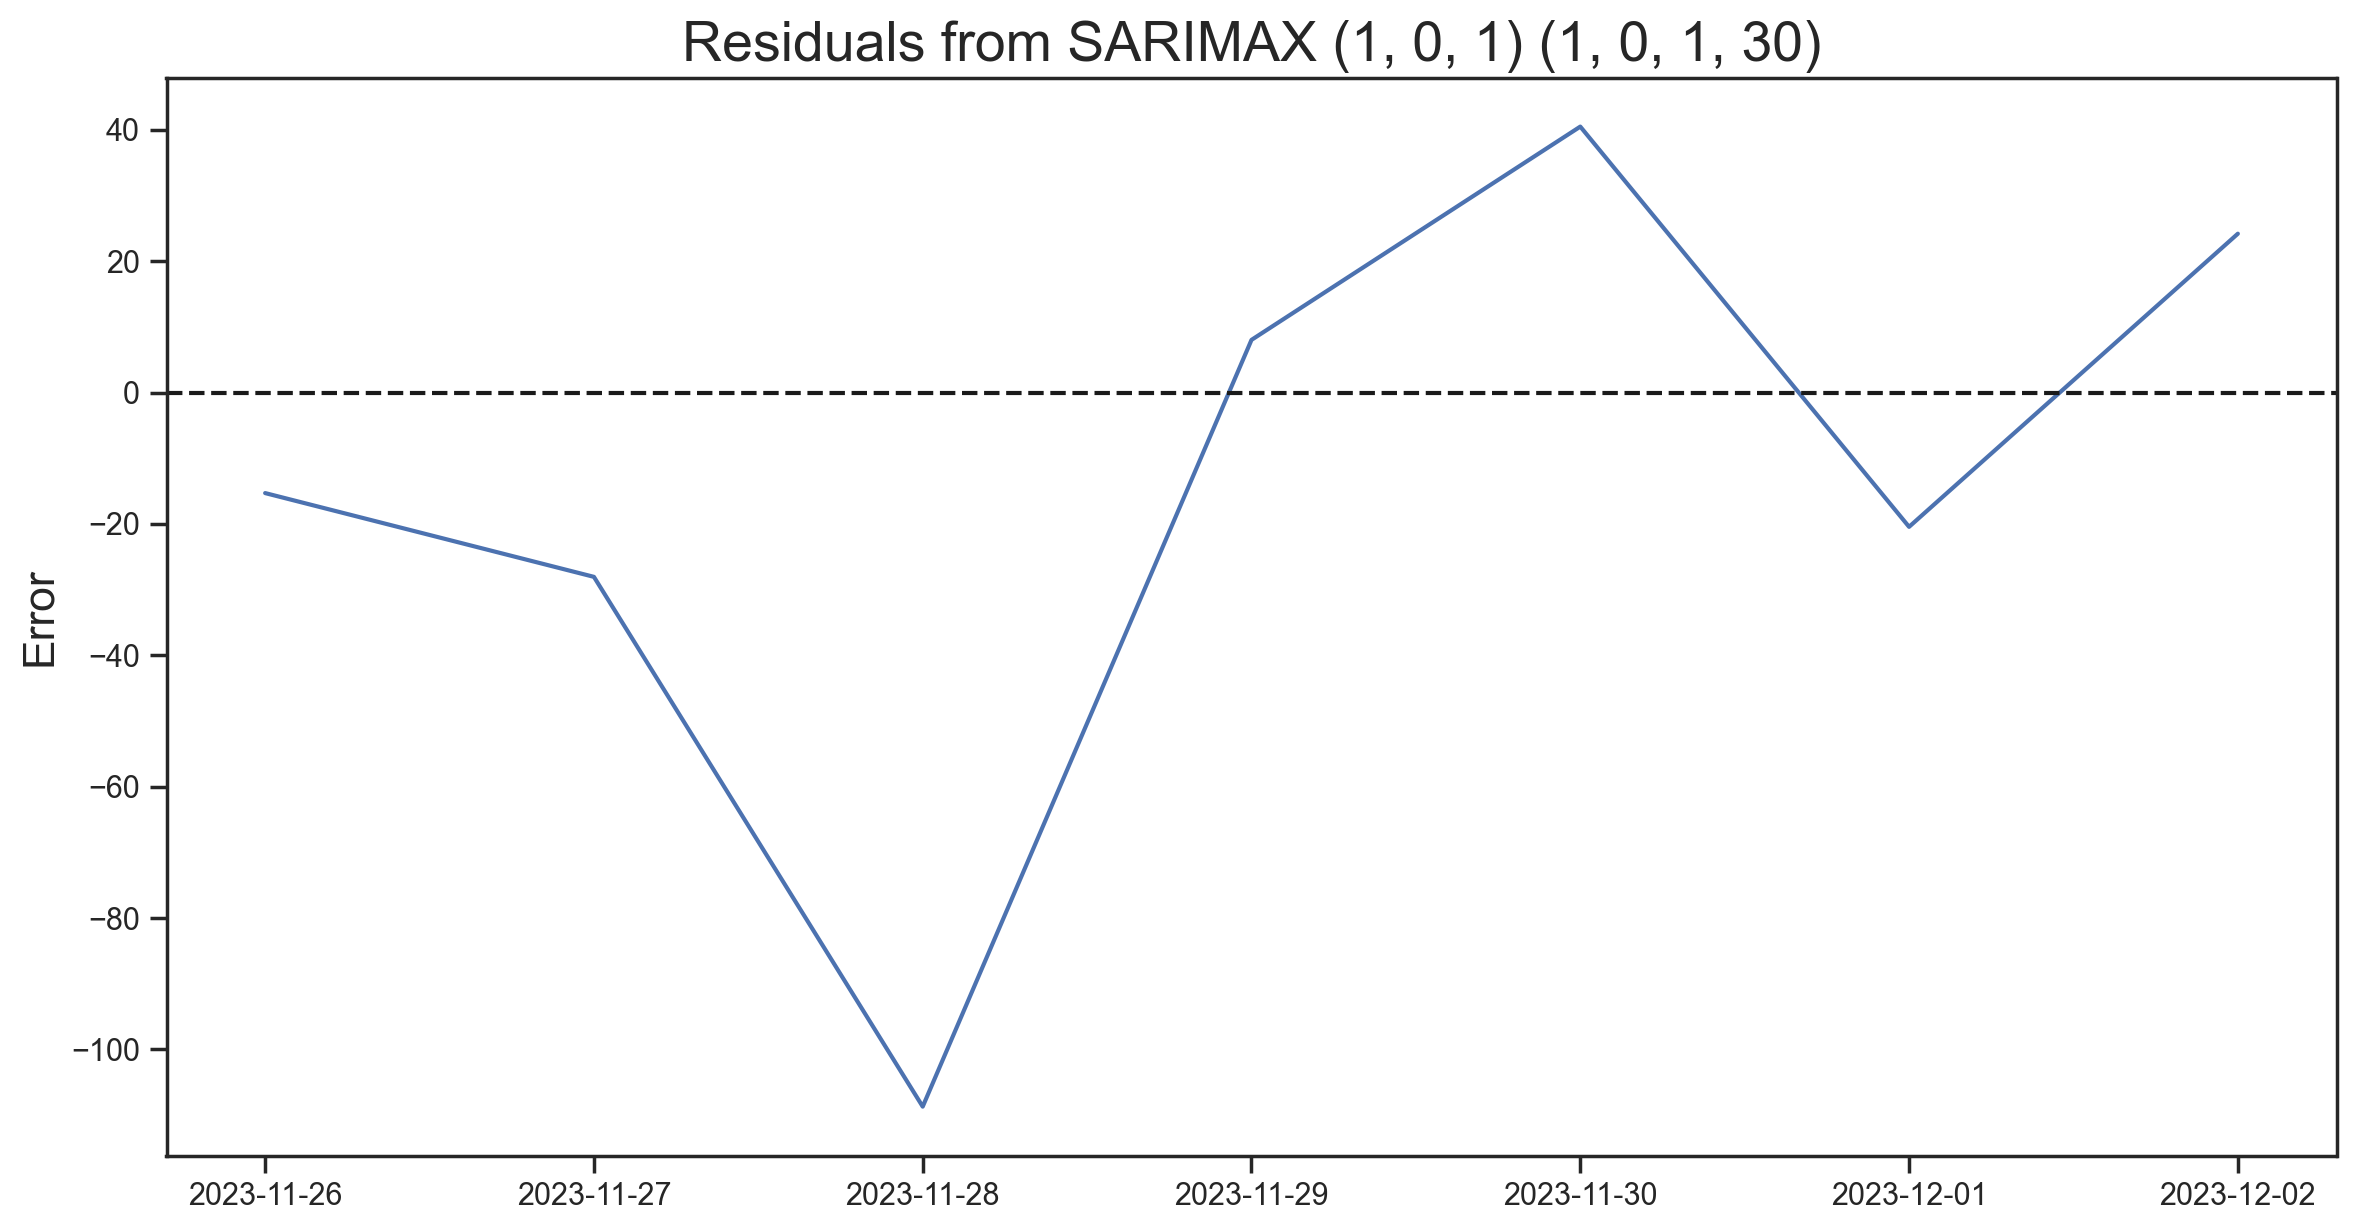

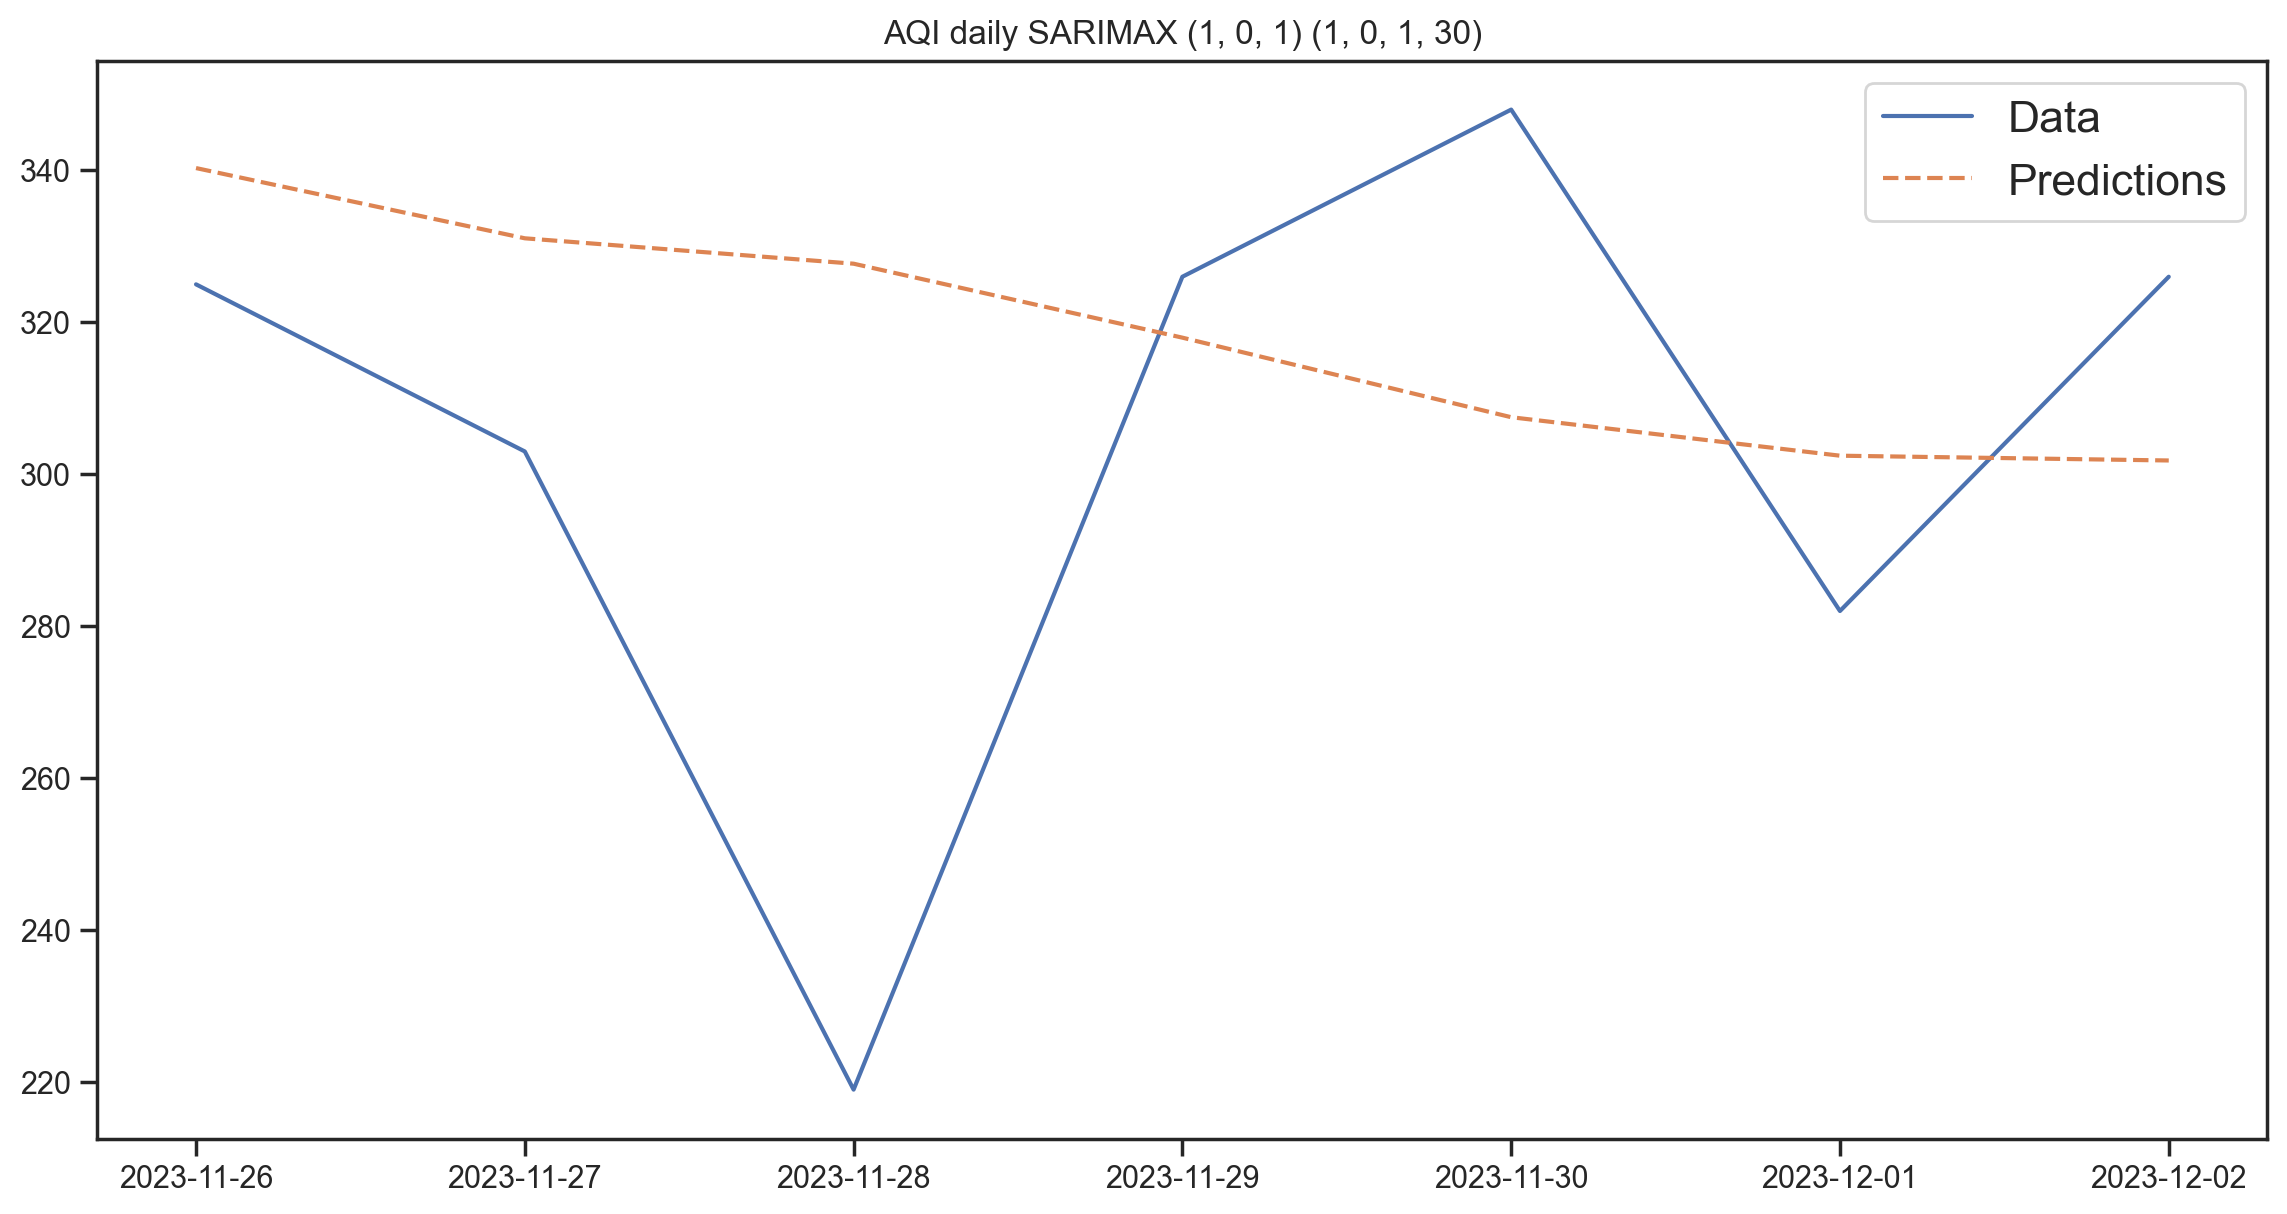

In [263]:
combinations = [[(1, 0, 1), (1, 0, 1, 7)], [(3, 0, 1), (3, 0, 1, 7)], [(1, 0, 1), (1, 0, 1, 30)]]

for order, seasonal_order in combinations:
    print(order, seasonal_order)
    results = without_rolling_model(df, order, seasonal_order, datetime(2023, 11, 25), datetime(2023, 12, 2), results)

In [264]:
results 

train_end   test_end  p  d  q  P  D  Q   s    MSE MAE      MAPE Rolling?  \
0 2023-11-20 2023-12-02  1  0  1  1  0  1   7    490  16  0.044696     True   
0 2023-11-20 2023-12-02  1  0  1  1  0  1  30    408  17  0.048423     True   
0 2023-11-20 2023-12-02  3  0  1  3  0  1   7   4509  54  0.170570    False   
0 2023-11-25 2023-12-02  1  0  0  1  1  0   7  10750  81  0.291416    False   
0 2023-11-25 2023-12-02  1  0  1  1  1  0   7  10704  81  0.290274    False   
0 2023-11-25 2023-12-02  1  0  1  1  1  1   7   2049  36  0.131509    False   
0 2023-11-25 2023-12-02  1  0  1  1  0  1   7   2112  36  0.131404    False   
0 2023-11-25 2023-12-02  3  0  1  3  0  1   7   4217  51  0.191491    False   
0 2023-11-25 2023-12-02  1  0  1  1  0  1  30   2221  35  0.131966    False   

     AIC    BIC  
0  15356  15382  
0  15381  15407  
0  15152  15199  
0  15561  15577  
0  15563  15584  
0  15211  15237  
0  15290  15316  
0  15208  15255  
0  15315  15341

(1, 0, 1) (1, 0, 1, 120)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.63016D+00    |proj g|=  4.57418D-02

At iterate    5    f=  5.62444D+00    |proj g|=  2.35624D-03

At iterate   10    f=  5.62423D+00    |proj g|=  6.28129D-04

At iterate   15    f=  5.62412D+00    |proj g|=  4.90856D-03

At iterate   20    f=  5.62400D+00    |proj g|=  1.58118D-03

At iterate   25    f=  5.62396D+00    |proj g|=  4.16434D-04

At iterate   30    f=  5.62381D+00    |proj g|=  7.50934D-05

At iterate   35    f=  5.62381D+00    |proj g|=  2.49380D-04

At iterate   40    f=  5.62381D+00    |proj g|=  3.22105D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     65      1     0     0   3.638D-04   5.624D+00
  F =   5.6238073505760893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/var/folders/27/b03t8q596qvcmtyqjtnh0w6w0000gn/T/ipykernel_5869/1689733556.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results = pd.concat([results, pd.DataFrame.from_dict(result)])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 0, 1) (1, 1, 1, 120)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.31833D+00    |proj g|=  5.14457D-02


 This problem is unconstrained.



At iterate    5    f=  5.28649D+00    |proj g|=  4.16344D-03

At iterate   10    f=  5.23543D+00    |proj g|=  7.60532D-02

At iterate   15    f=  5.22092D+00    |proj g|=  1.39075D-02

At iterate   20    f=  5.21385D+00    |proj g|=  2.19862D-03

At iterate   25    f=  5.21384D+00    |proj g|=  2.04023D-04

At iterate   30    f=  5.21382D+00    |proj g|=  1.39031D-03

At iterate   35    f=  5.21380D+00    |proj g|=  1.50406D-04

At iterate   40    f=  5.21380D+00    |proj g|=  4.04278D-05

At iterate   45    f=  5.21380D+00    |proj g|=  3.46278D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     56   

/var/folders/27/b03t8q596qvcmtyqjtnh0w6w0000gn/T/ipykernel_5869/1689733556.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results = pd.concat([results, pd.DataFrame.from_dict(result)])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(1, 0, 1) (1, 1, 1, 30)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66047D+00    |proj g|=  9.36098D-02

At iterate    5    f=  5.60801D+00    |proj g|=  1.03141D-02

At iterate   10    f=  5.60183D+00    |proj g|=  4.93034D-03

At iterate   15    f=  5.53985D+00    |proj g|=  5.71949D-03

At iterate   20    f=  5.52700D+00    |proj g|=  7.93569D-02
  ys=-2.432E-03  -gs= 2.525E-03 BFGS update SKIPPED

At iterate   25    f=  5.52139D+00    |proj g|=  4.46823D-03

At iterate   30    f=  5.52137D+00    |proj g|=  5.26423D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

/var/folders/27/b03t8q596qvcmtyqjtnh0w6w0000gn/T/ipykernel_5869/1689733556.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  results = pd.concat([results, pd.DataFrame.from_dict(result)])


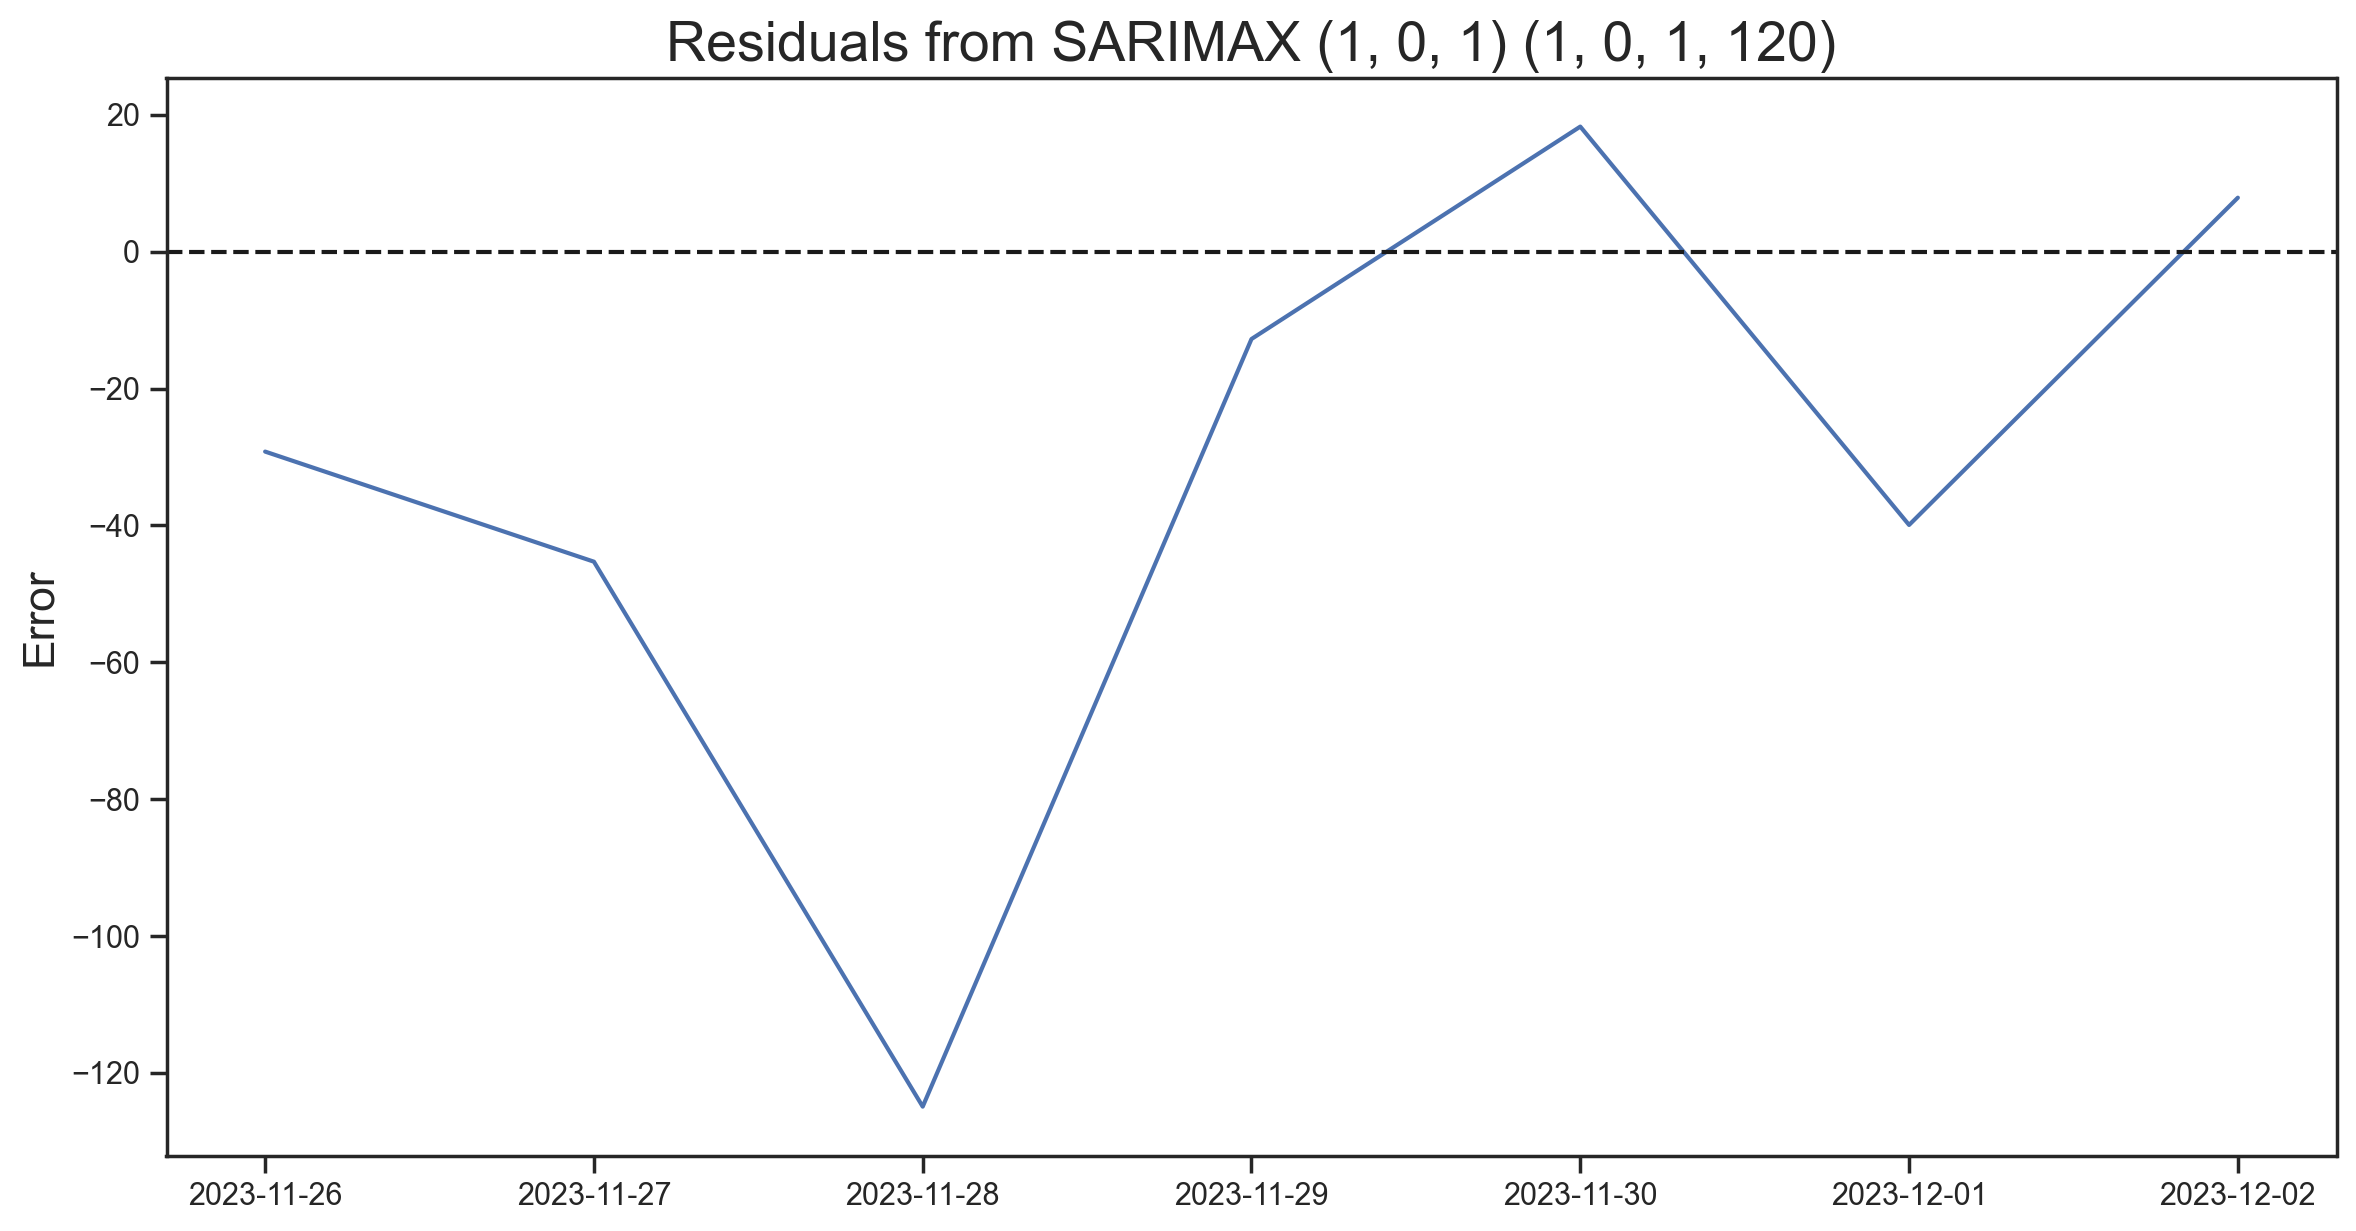

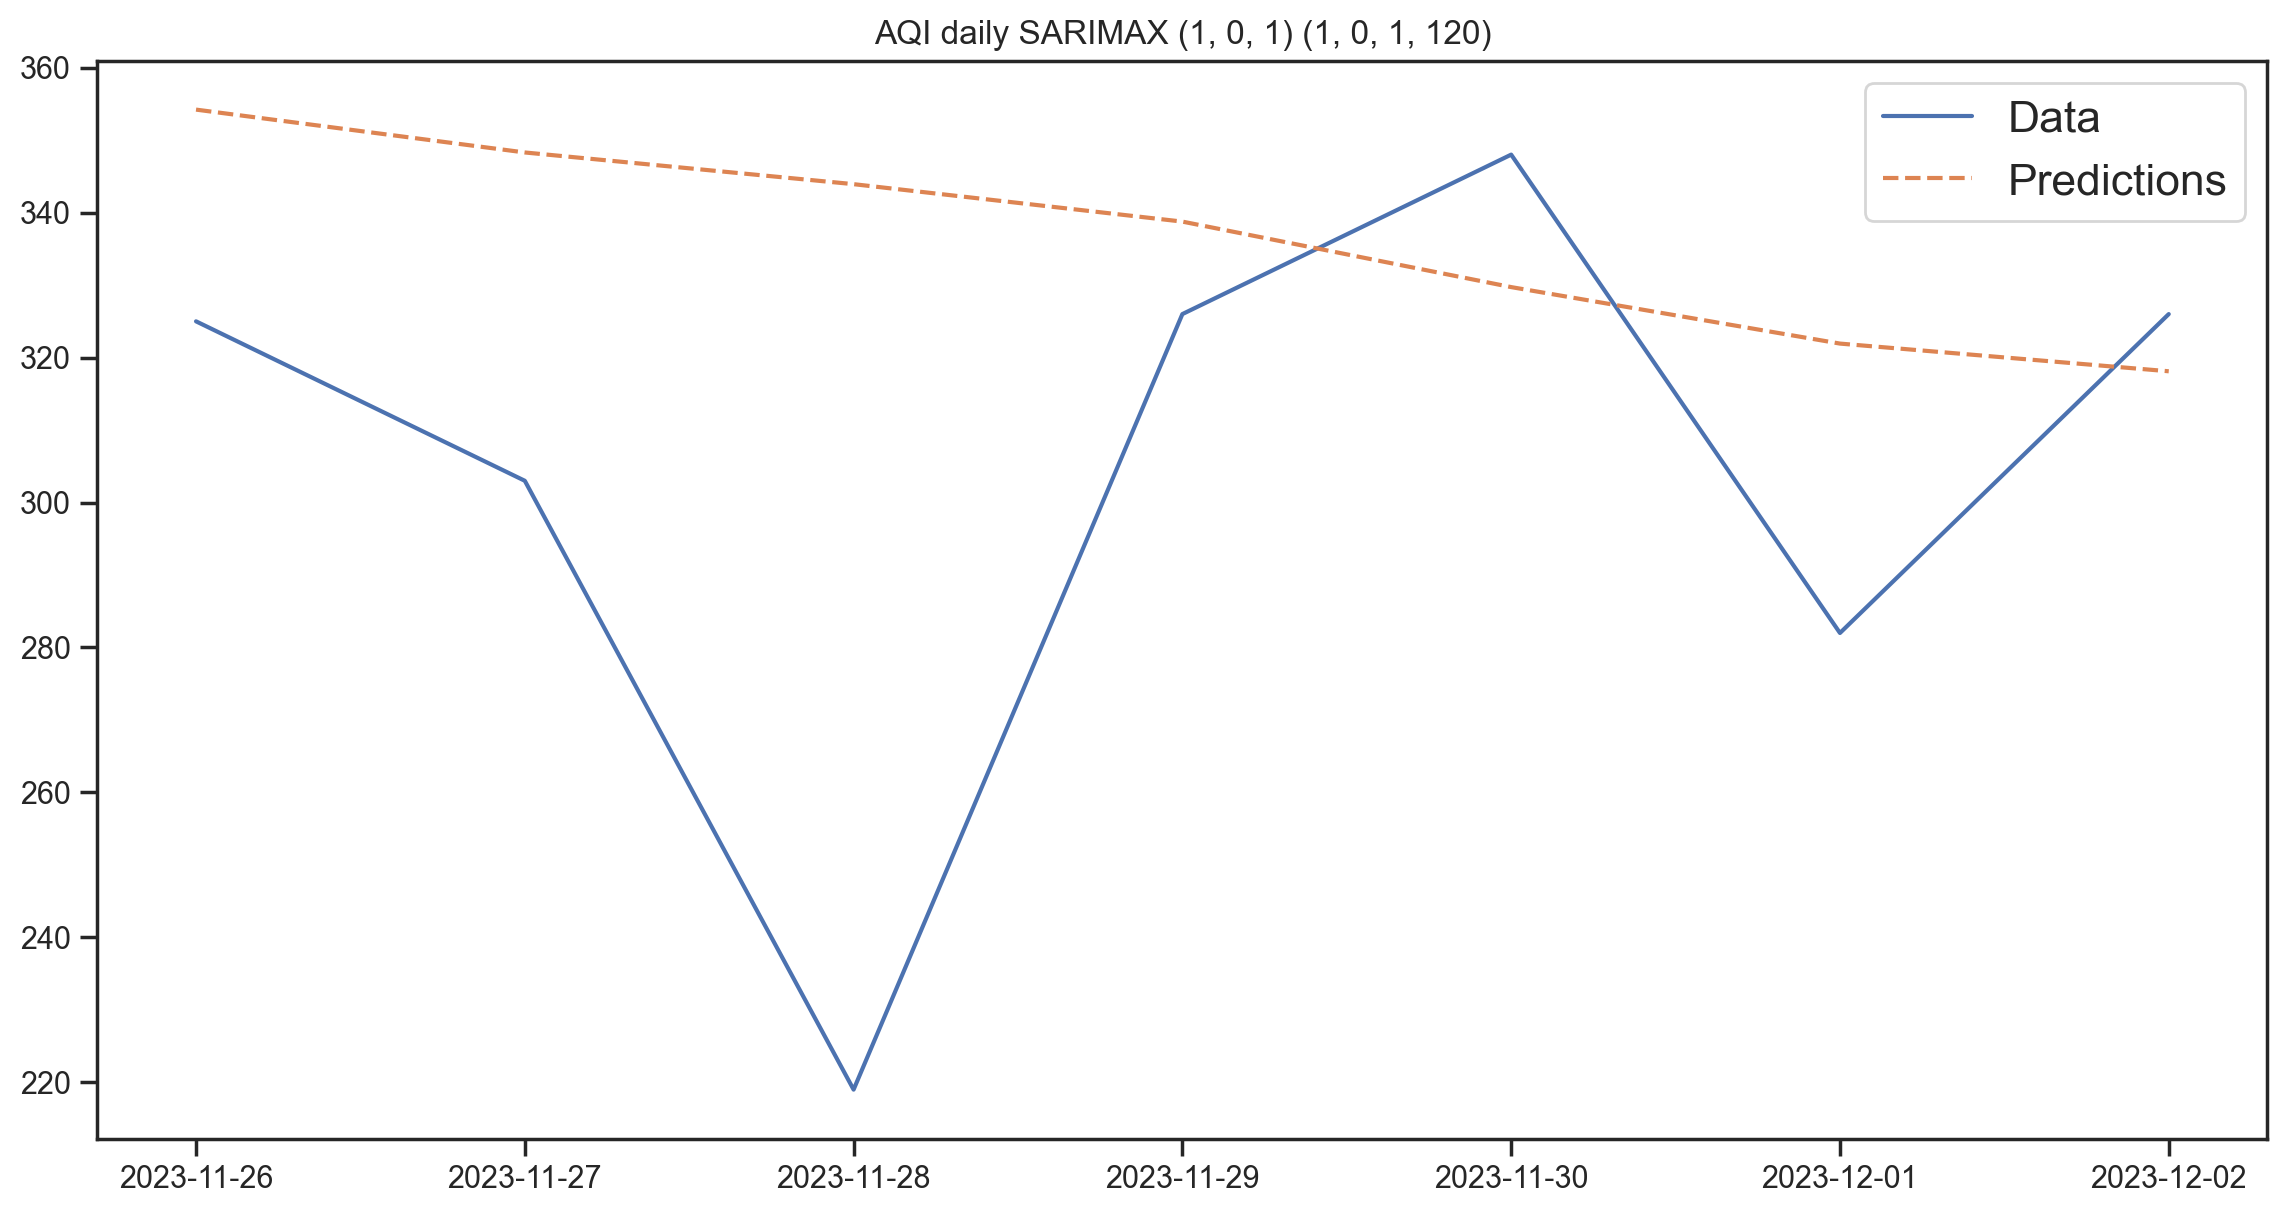

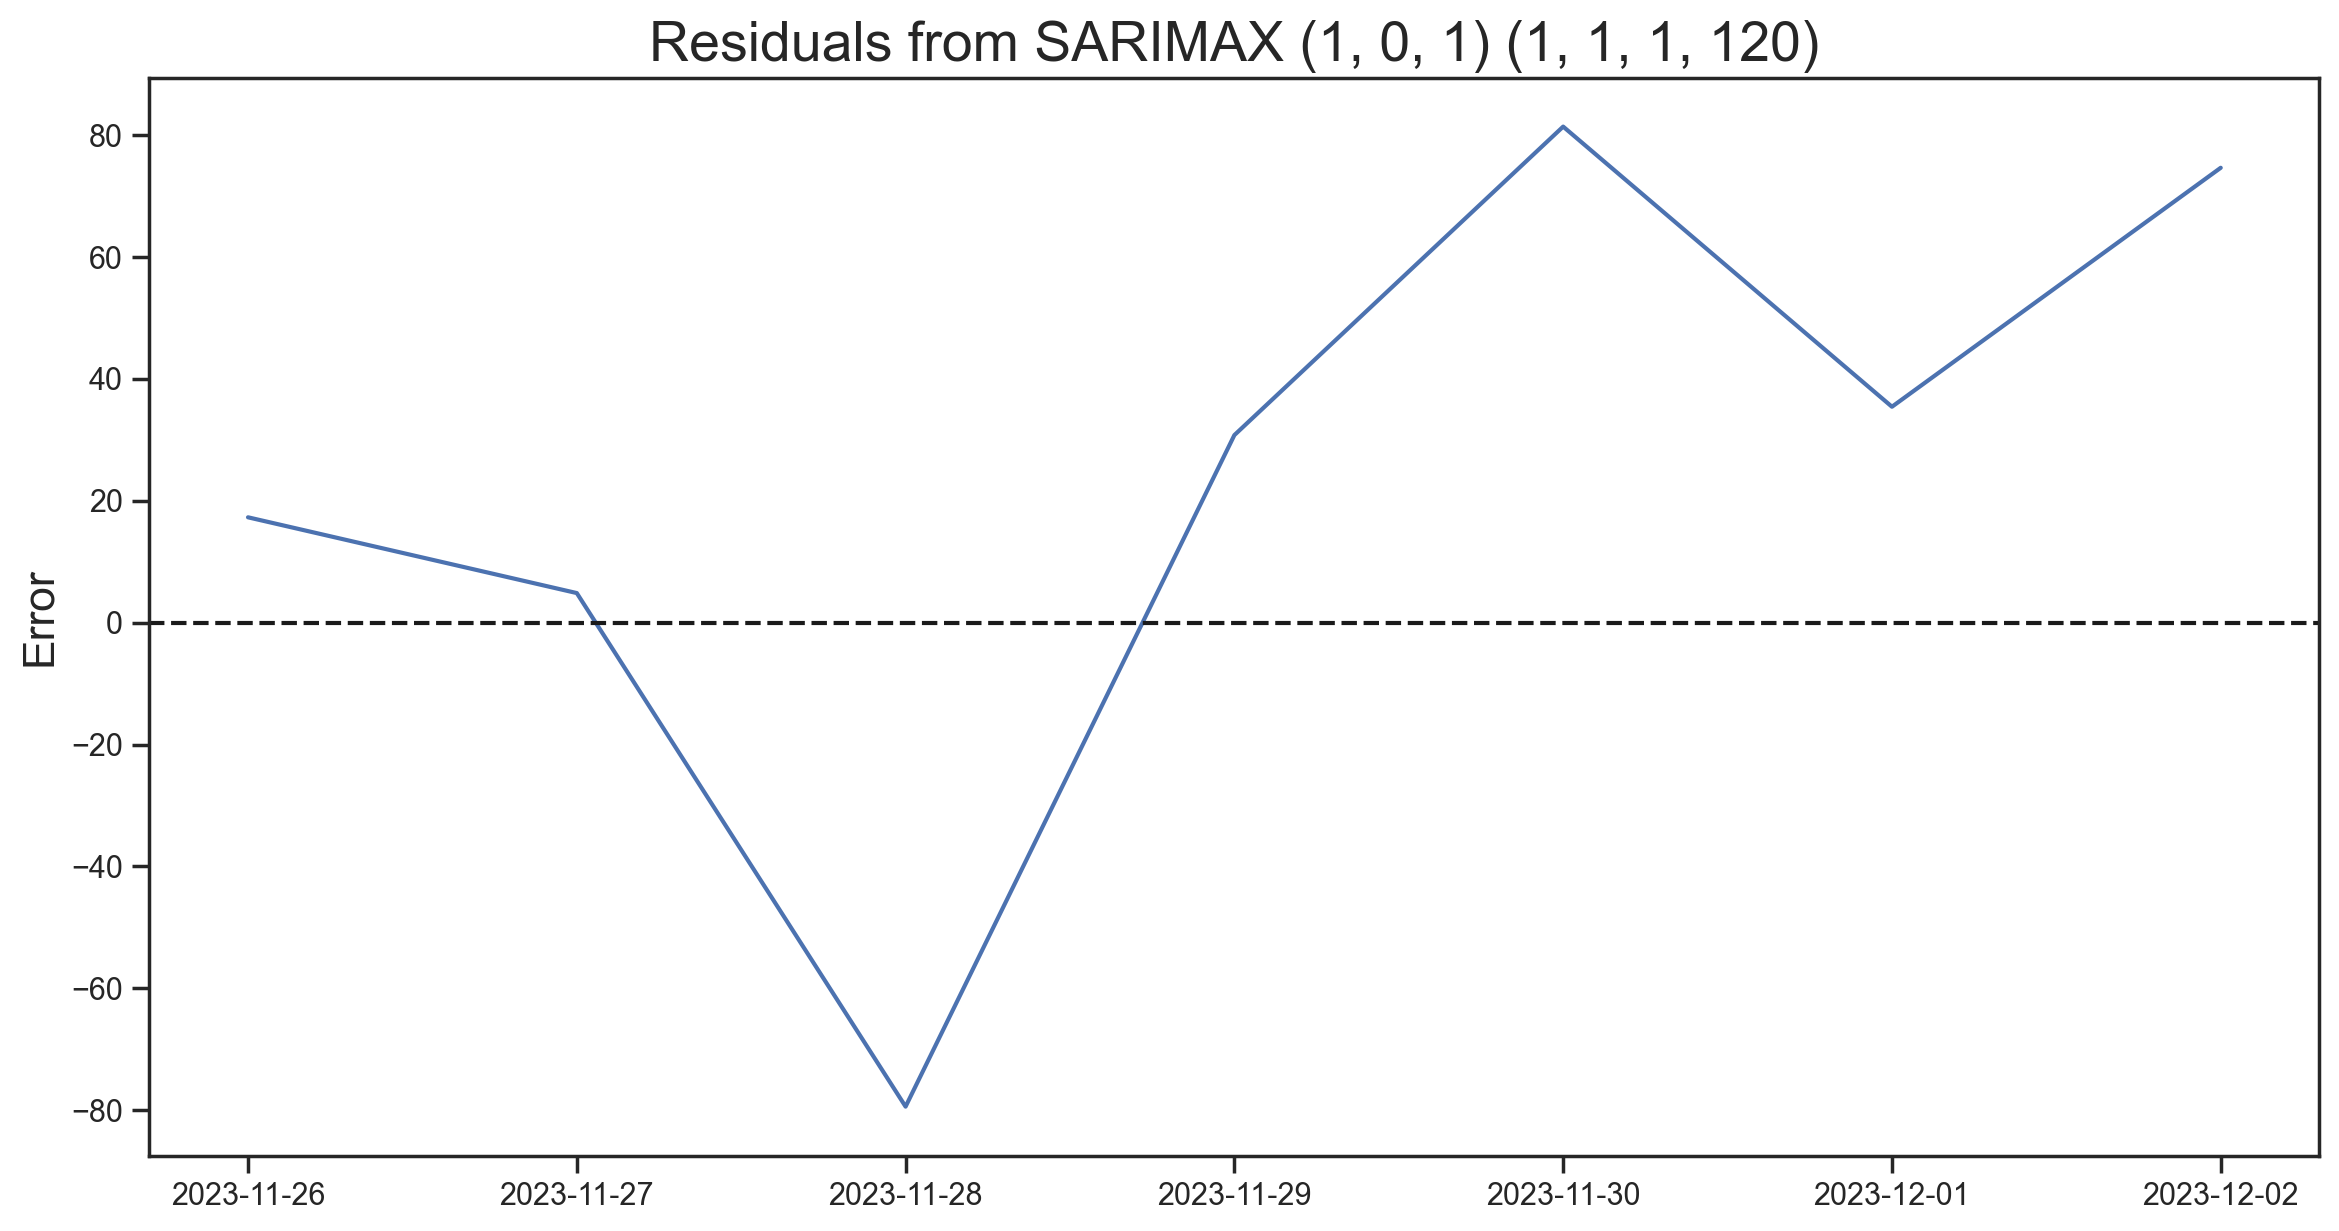

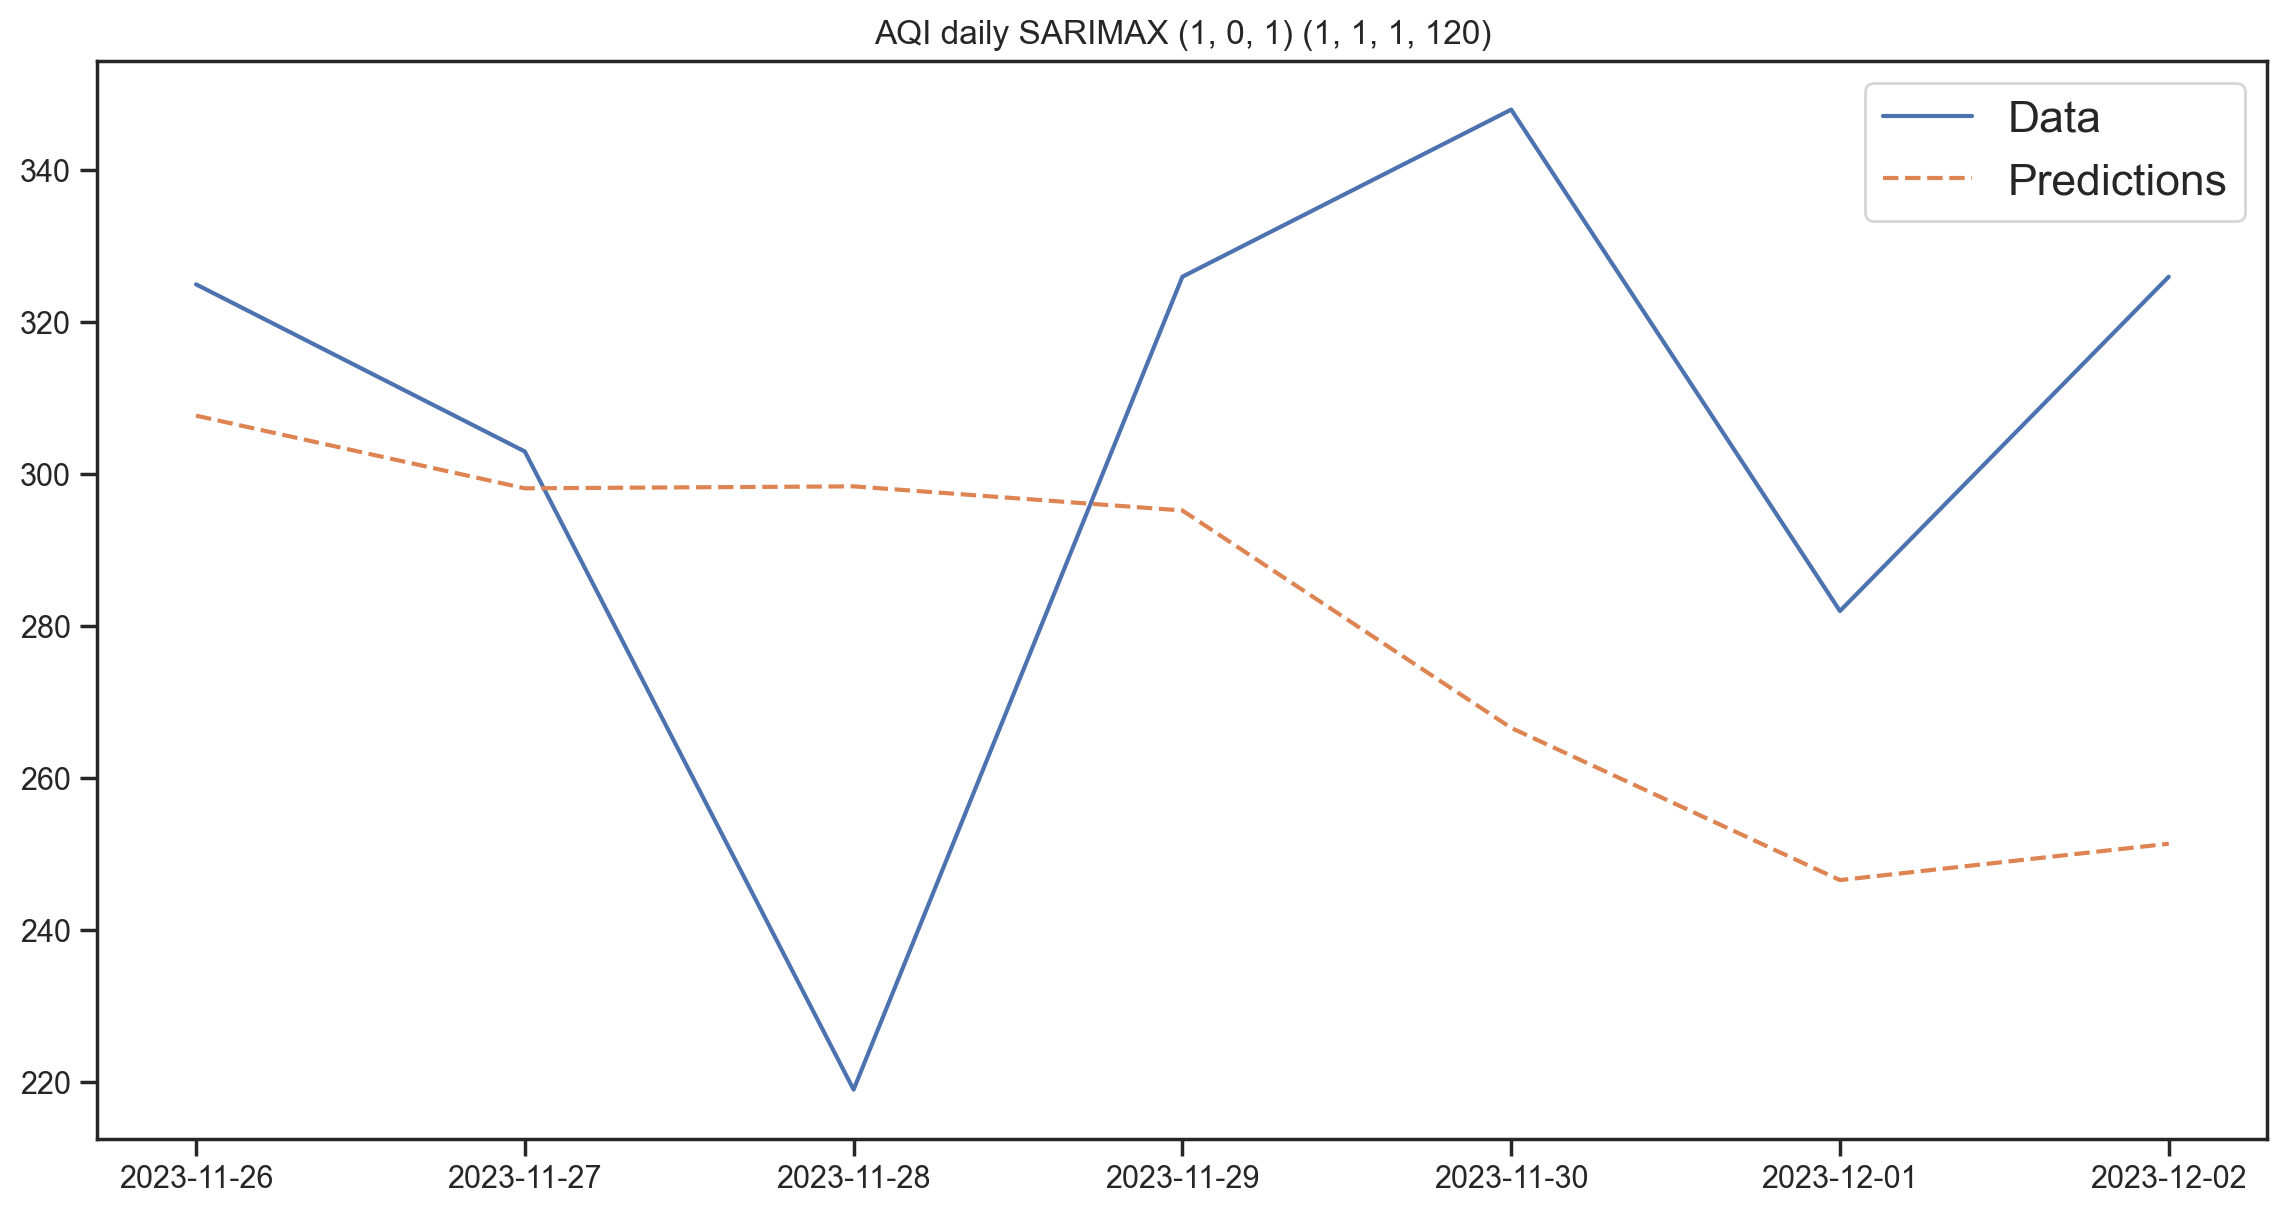

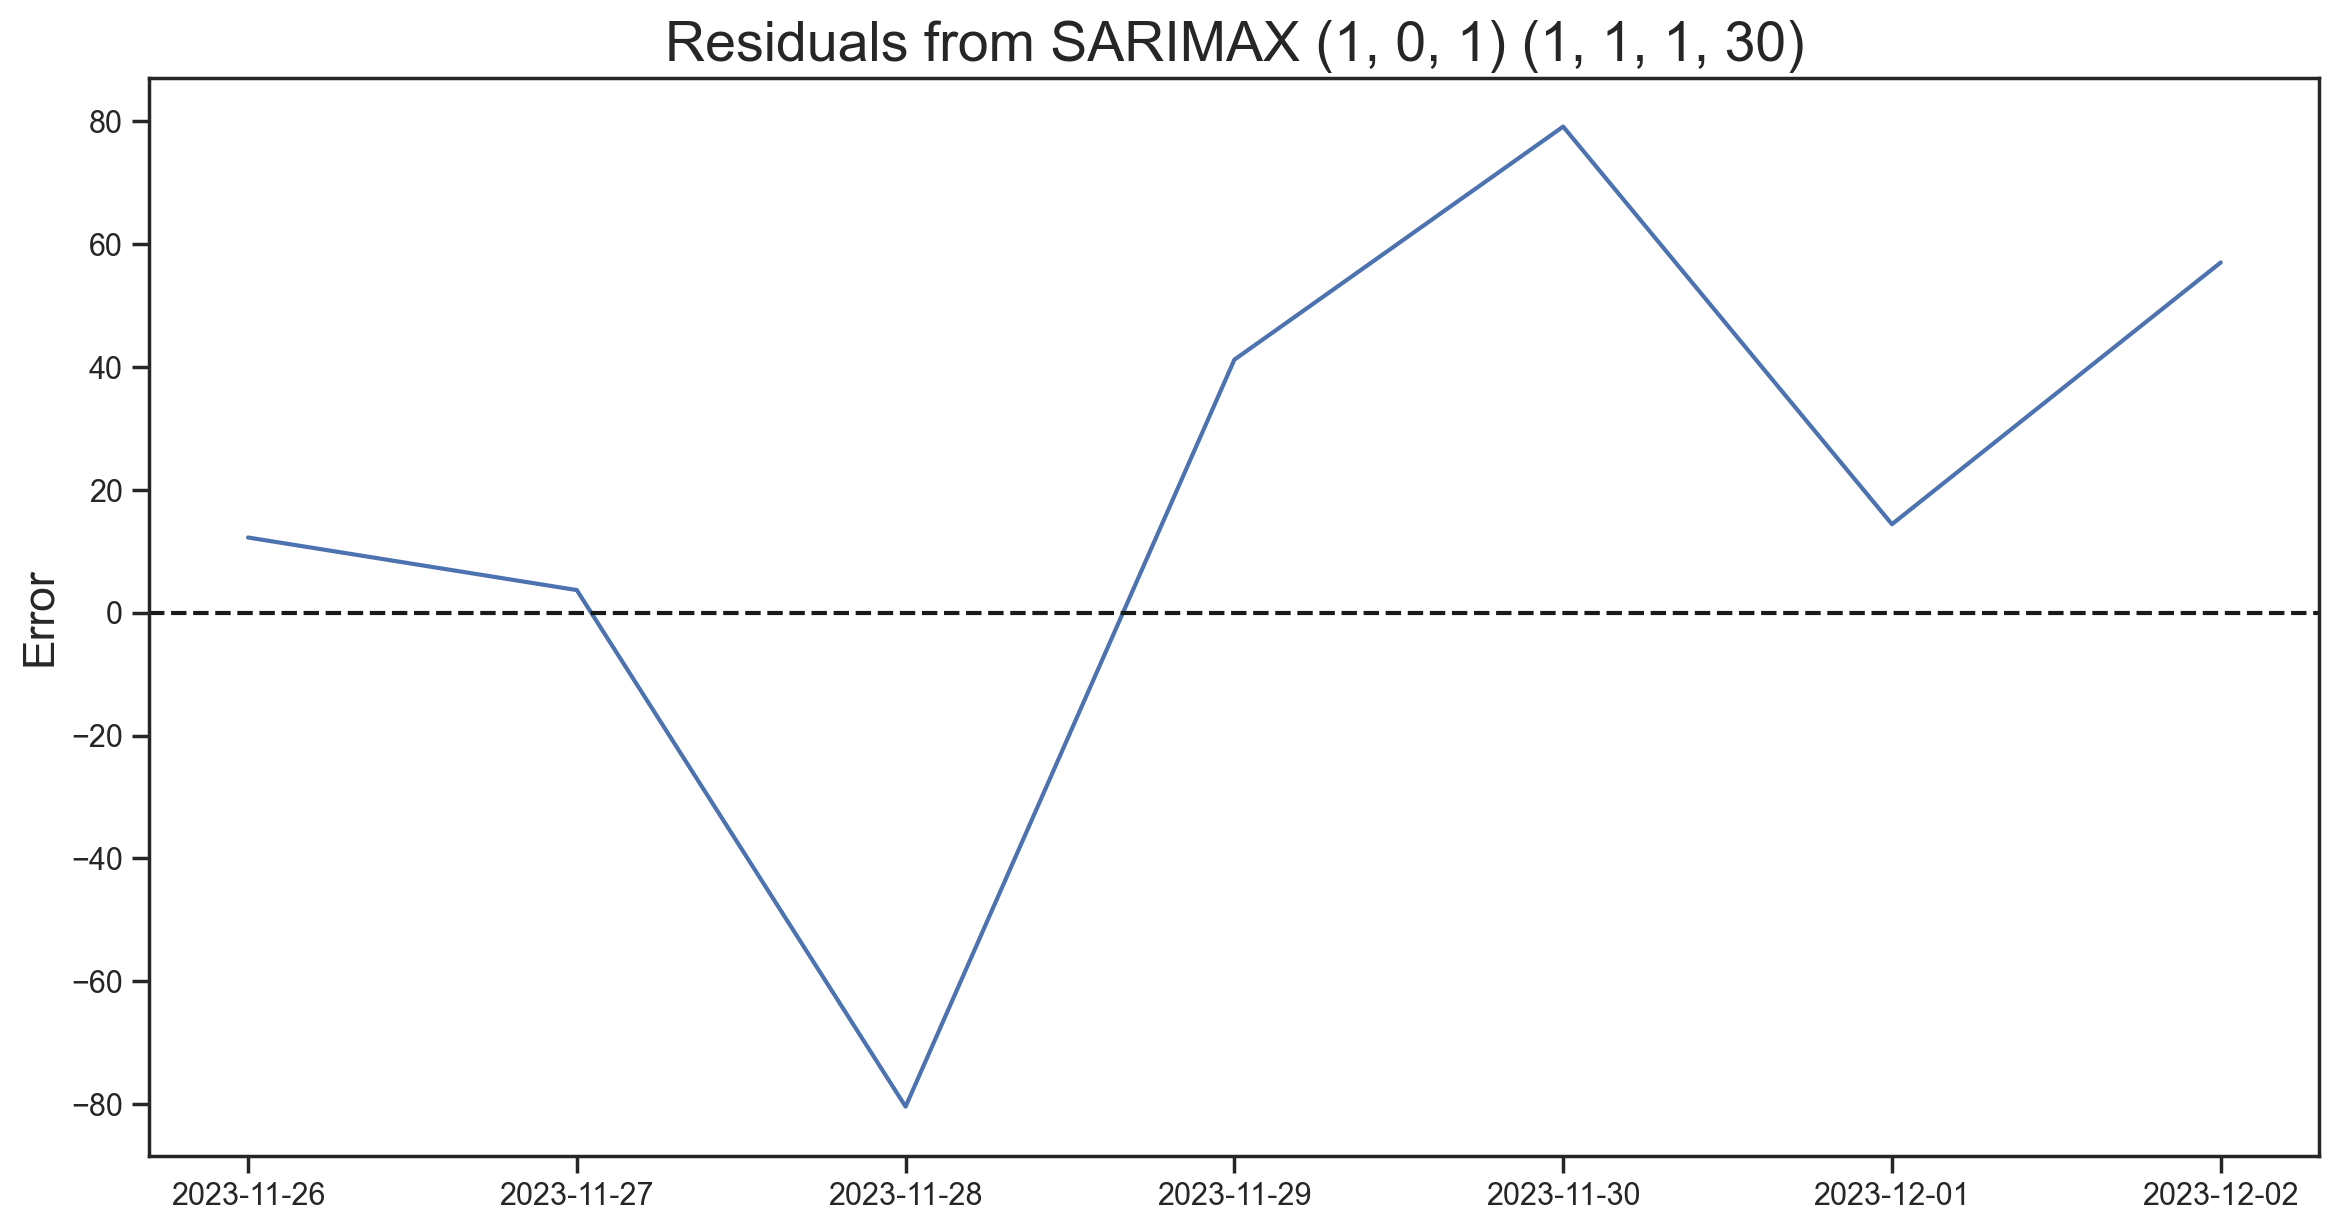

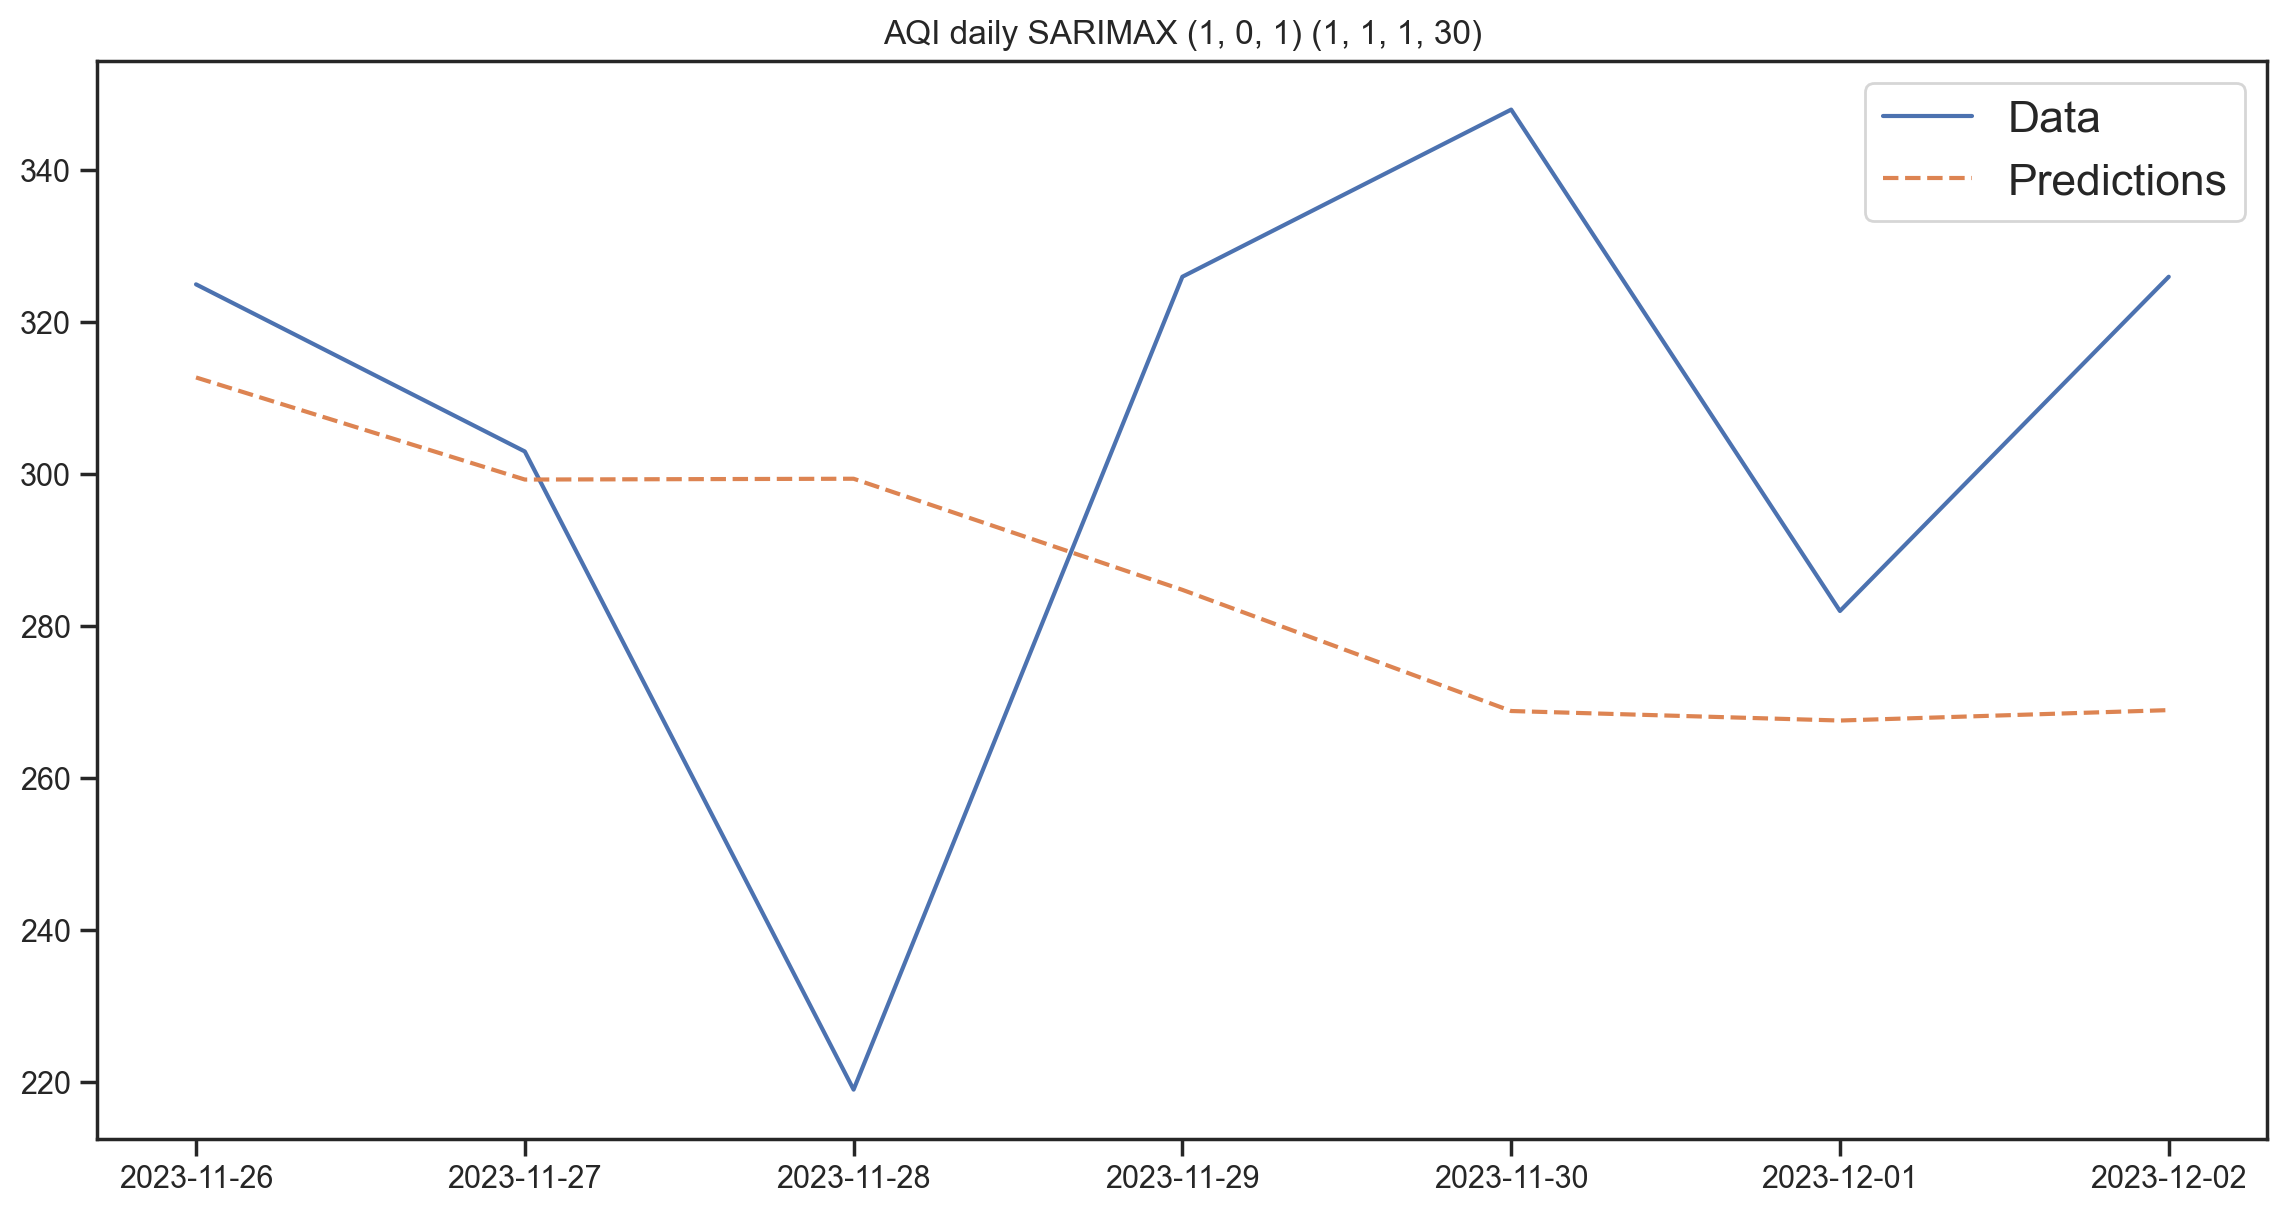

In [266]:
combinations = [[(1, 0, 1), (1, 0, 1, 120)], [(1, 0, 1), (1, 1, 1, 120)], [(1, 0, 1), (1, 1, 1, 30)]]

for order, seasonal_order in combinations:
    print(order, seasonal_order)
    results = without_rolling_model(df, order, seasonal_order, datetime(2023, 11, 25), datetime(2023, 12, 2), results)

In [267]:
results

train_end   test_end  p  d  q  P  D  Q    s    MSE MAE      MAPE Rolling?  \
0 2023-11-20 2023-12-02  1  0  1  1  0  1    7    490  16  0.044696     True   
0 2023-11-20 2023-12-02  1  0  1  1  0  1   30    408  17  0.048423     True   
0 2023-11-20 2023-12-02  3  0  1  3  0  1    7   4509  54  0.170570    False   
0 2023-11-25 2023-12-02  1  0  0  1  1  0    7  10750  81  0.291416    False   
0 2023-11-25 2023-12-02  1  0  1  1  1  0    7  10704  81  0.290274    False   
0 2023-11-25 2023-12-02  1  0  1  1  1  1    7   2049  36  0.131509    False   
0 2023-11-25 2023-12-02  1  0  1  1  0  1    7   2112  36  0.131404    False   
0 2023-11-25 2023-12-02  3  0  1  3  0  1    7   4217  51  0.191491    False   
0 2023-11-25 2023-12-02  1  0  1  1  0  1   30   2221  35  0.131966    False   
0 2023-11-25 2023-12-02  1  0  1  1  0  1  120   2952  40  0.152468    False   
0 2023-11-25 2023-12-02  1  0  1  1  1  1  120   3003  46  0.159225    False   
0 2023-11-25 2023-12-02  1  0  1  1  1  1   30   2580  41  0.142444    False   

     AIC    BIC  
0  15356  15382  
0  15381  15407  
0  15152  15199  
0  15561  15577  
0  15563  15584  
0  15211  15237  
0  15290  15316  
0  15208  15255  
0  15315  15341  
0  15318  15344  
0  14202  14228  
0  15039  15065

In [268]:
results.to_csv("models_results.csv")

In [ ]:
# best_model = # 2023-11-25	2023-12-02	1	0	1	1	0	1	7	2398	36	0.137155	False

In [ ]:
stepwise_fit = auto_arima(
    sector_51_daily['AQI_calculated'],
    suppress_warnings=True,
    d=0,  # non-seasonal difference order
    start_p=0,  # initial guess for p
    start_q=0,  # initial guess for q
    max_p=2,  # max value of p to test
    max_q=2,  # max value of q to test
    seasonal=True,  # is the time series seasonal? YES
    m=24,  # the seasonal period
    #D=1, # seasonal difference order
    start_P=0,  # initial guess for P
    start_Q=0,  # initial guess for Q
    max_P=2,  # max value of P to test
    max_Q=2,  # max value of Q to test
    information_criterion='aic',  # used to select best model
    trace=True,  # print results whilst training
    error_action='ignore',  # ignore orders that don't work
    stepwise=True  # apply intelligent order search
)
stepwise_fit.summary()

# Training rolling ARIMA 1,0,1

In [183]:
train_end = datetime(2023, 11, 20)
test_end = datetime(2023, 12, 2)

train_data = df[:train_end]['AQI']
test_data = df[train_end + timedelta(days=1):test_end]['AQI']

my_order = (1, 0, 1)
seasonal_oder = (0, 0, 0, 0)
p, d, q = my_order
P, D, Q, s = seasonal_oder

rolling_predictions = test_data.copy()

for train_end in test_data.index:
    print("train_end-timedelta(days=1)", train_end - timedelta(days=1))
    train_data = df[:train_end - timedelta(days=1)]['AQI']
    model = ARIMA(train_data, order=my_order)
    model_fit = model.fit()
    pred = model_fit.forecast(typ='levels')
    print("pred", pred)
    rolling_predictions[train_end] = pred

train_end-timedelta(days=1) 2023-11-20 00:00:00
pred 2023-11-21    324.210765
Freq: D, dtype: float64
train_end-timedelta(days=1) 2023-11-21 00:00:00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

pred 2023-11-22    311.615417
Freq: D, dtype: float64
train_end-timedelta(days=1) 2023-11-22 00:00:00
pred 2023-11-23    321.83146
Freq: D, dtype: float64
train_end-timedelta(days=1) 2023-11-23 00:00:00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

pred 2023-11-24    394.338952
Freq: D, dtype: float64
train_end-timedelta(days=1) 2023-11-24 00:00:00
pred 2023-11-25    436.975335
Freq: D, dtype: float64
train_end-timedelta(days=1) 2023-11-25 00:00:00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

pred 2023-11-26    337.737482
Freq: D, dtype: float64
train_end-timedelta(days=1) 2023-11-26 00:00:00
pred 2023-11-27    315.60707
Freq: D, dtype: float64
train_end-timedelta(days=1) 2023-11-27 00:00:00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

pred 2023-11-28    296.097762
Freq: D, dtype: float64
train_end-timedelta(days=1) 2023-11-28 00:00:00
pred 2023-11-29    233.648281
Freq: D, dtype: float64
train_end-timedelta(days=1) 2023-11-29 00:00:00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

pred 2023-11-30    296.746976
Freq: D, dtype: float64
train_end-timedelta(days=1) 2023-11-30 00:00:00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


pred 2023-12-01    324.020459
Freq: D, dtype: float64
train_end-timedelta(days=1) 2023-12-01 00:00:00
pred 2023-12-02    283.078364
Freq: D, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [184]:
residuals = test_data - rolling_predictions.shift(-1)

<Figure size 1400x400 with 0 Axes>

Text(0.5, 1.0, 'Residuals from Rolling ARIMA 1, 0, 1')

Text(0, 0.5, 'Error')

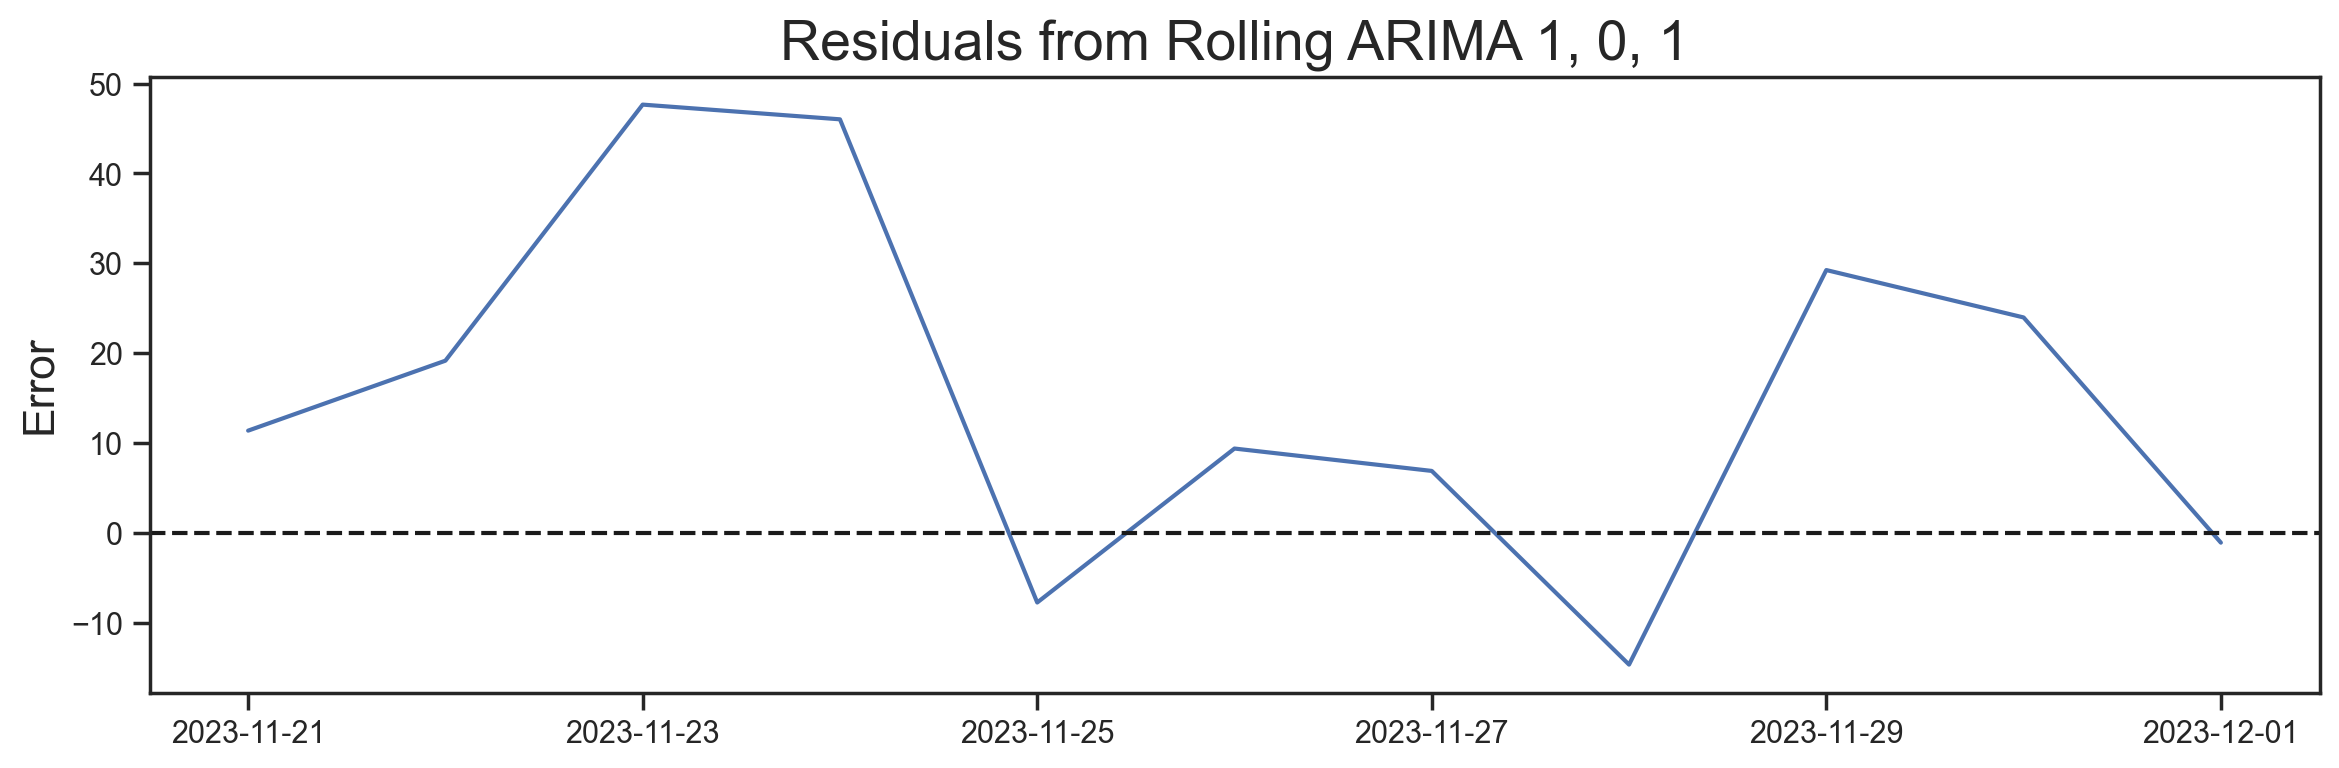

In [185]:
plt.figure(figsize=(14,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from Rolling ARIMA {}, {}, {}'.format(p,d,q), fontsize=20)
plt.ylabel('Error', fontsize=16)

In [200]:
results = append_to_results(p, d, q, P, D, Q, s, test_data[:-1],
                            rolling_predictions.shift(-1)[:-1], True,
                            model_fit, results)
results

p  d  q  P  D  Q  s    MSE   MAE     MAPE Rolling?      AIC      BIC
0  1  0  1  0  0  0  0  612.0  20.0  0.05446     True  15327.0  15348.0

In [201]:
# result = {
#     "p": [p],
#     "d": [d],
#     "q": [q],
#     "P": [P],
#     "D": [D],
#     "Q": [Q],
#     "s": [s],
#     "MSE": [mean_squared_error(test_data[:-1], rolling_predictions.shift(-1)[:-1])],
#     "MAE": [mean_absolute_error(test_data[:-1], rolling_predictions.shift(-1)[:-1])],
#     "MAPE": [mean_absolute_percentage_error(test_data[:-1], rolling_predictions.shift(-1)[:-1])],
#     "Rolling?": [True],
#     "AIC": [model_fit.aic],
#     "BIC": [model_fit.bic]
# }

# result

<Figure size 1400x700 with 0 Axes>

Text(0.5, 1.0, 'predictions ARIMA 1, 0, 1 ')

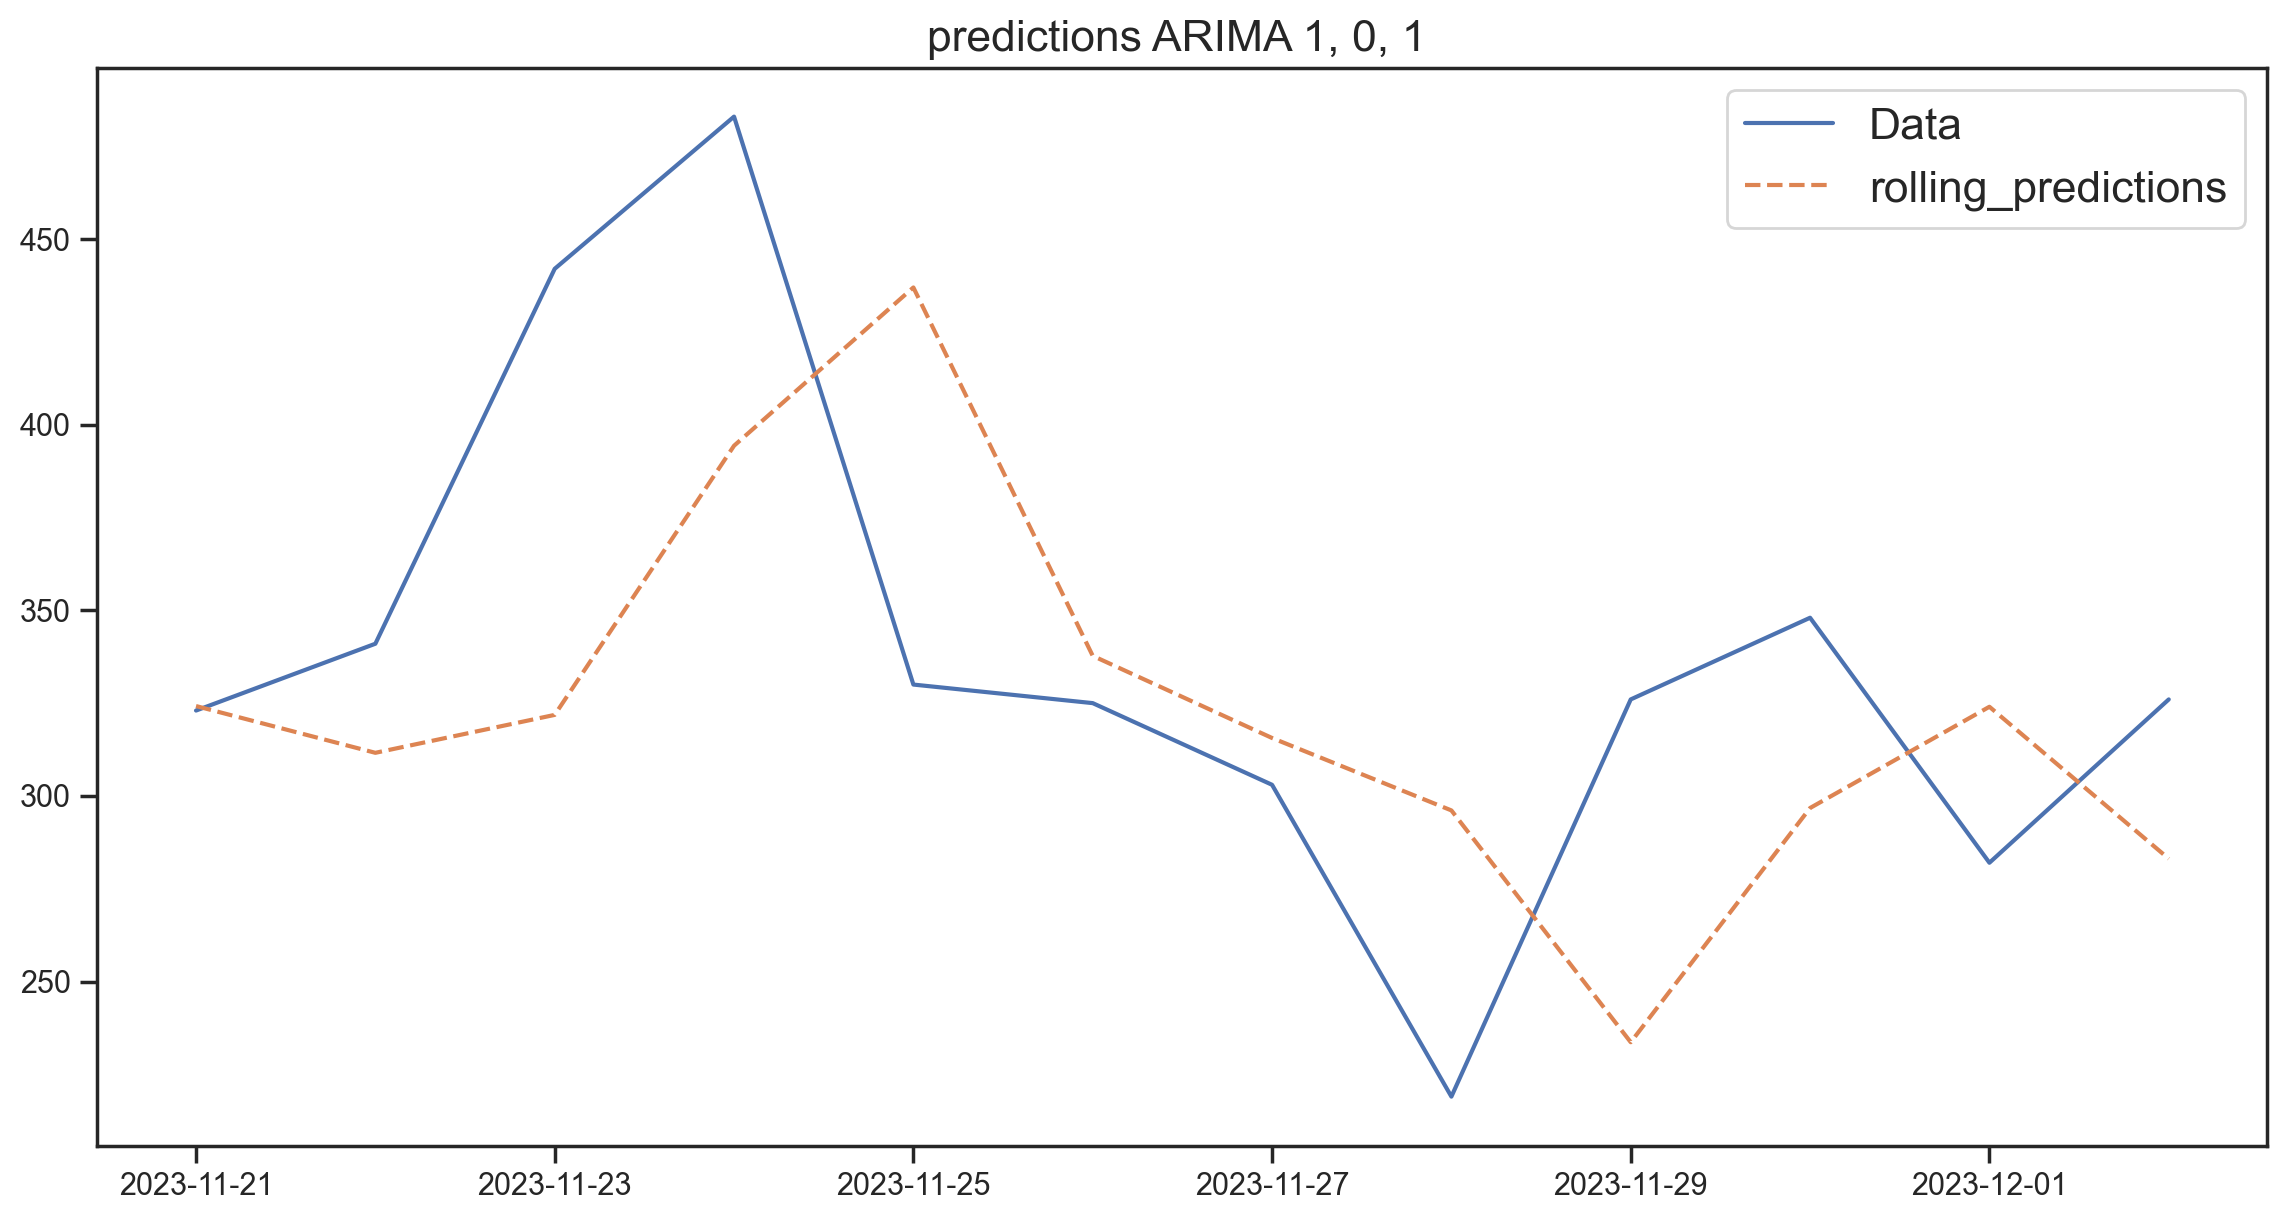

In [202]:
plt.figure(figsize=(14, 7))
plt.plot(test_data)
plt.plot(rolling_predictions , '--')
plt.legend(('Data', 'rolling_predictions'), fontsize=16)
plt.title("predictions ARIMA {}, {}, {} ".format(p,d,q), fontsize=16)

<Figure size 1400x700 with 0 Axes>

Text(0.5, 1.0, 'Shifted -1 predictions ARIMA 1, 0, 1 ')

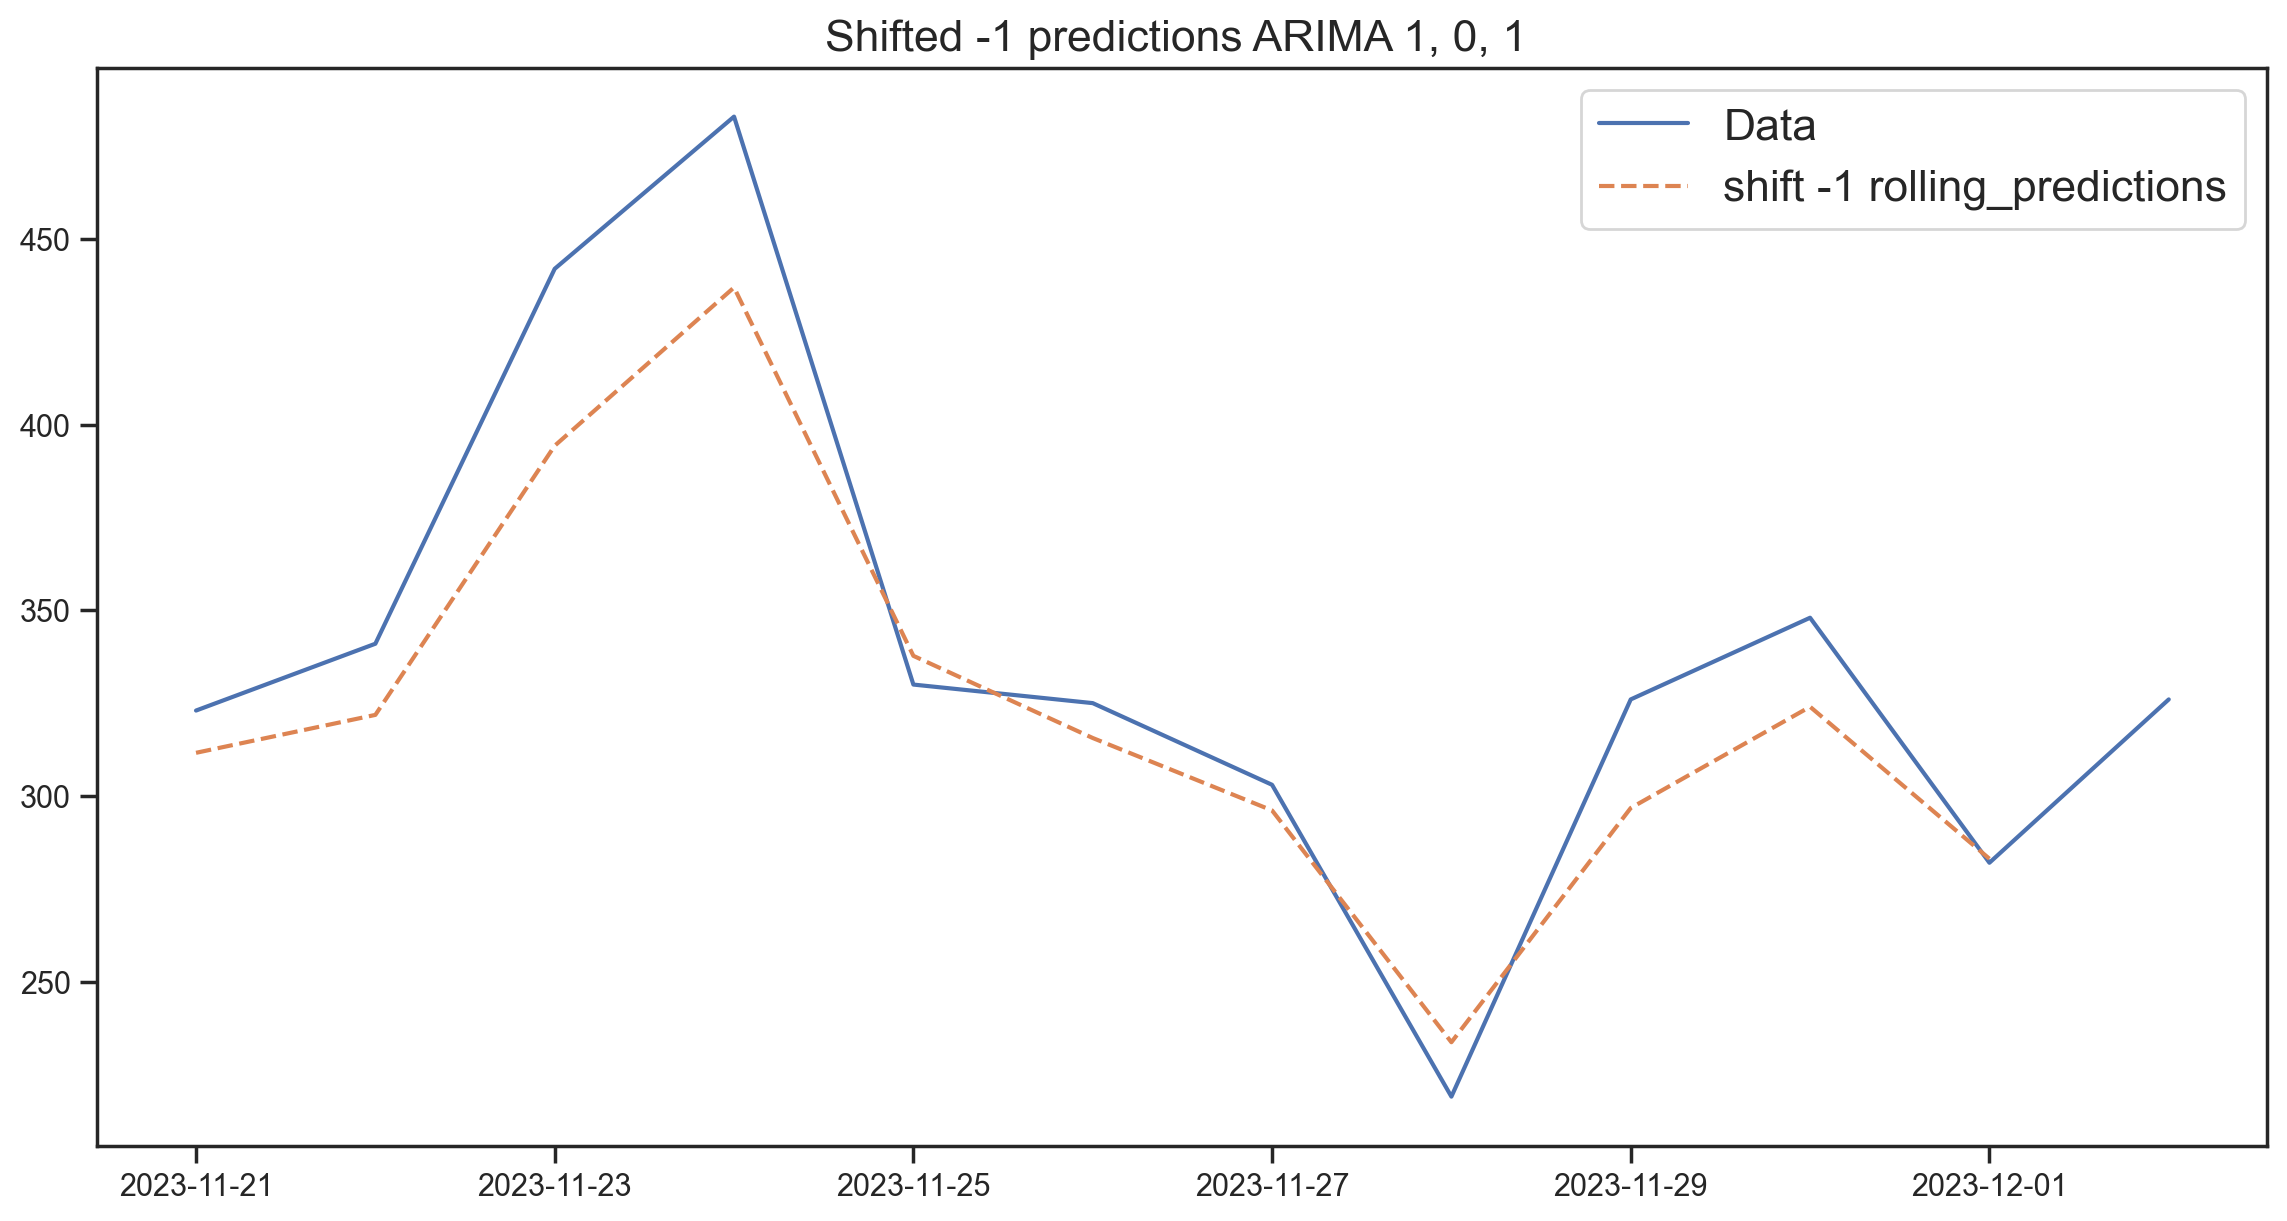

In [203]:
plt.figure(figsize=(14, 7))
plt.plot(test_data)
plt.plot(rolling_predictions.shift(-1) , '--')
plt.legend(('Data', 'shift -1 rolling_predictions'), fontsize=16)
plt.title("Shifted -1 predictions ARIMA {}, {}, {} ".format(p,d,q), fontsize=16)

# Training without rolling ARIMA 1,0,1

In [113]:
train_end = datetime(2023, 11, 29)
test_end = datetime(2023, 12, 2)

train_data = df[:train_end]['AQI']
test_data = df[train_end + timedelta(days=1):test_end]['AQI']

p, d, q = (1, 0, 1)
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()
print("Model summary ", model_fit.summary())

Model summary                                 SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                 1365
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7648.880
Date:                Mon, 04 Dec 2023   AIC                          15305.759
Time:                        21:55:45   BIC                          15326.635
Sample:                    03-05-2020   HQIC                         15313.573
                         - 11-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        222.0819     13.902     15.975      0.000     194.835     249.329
ar.L1          0.8859      0.012     71.182      0.000       0.862       0.910
ma.L1         -0.1890      0.025     

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [114]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
pred_start_date, pred_end_date

(Timestamp('2023-11-30 00:00:00'), Timestamp('2023-12-02 00:00:00'))

In [115]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date, typ='levels')
residuals = test_data - predictions

In [102]:
model_fit.forecasts[0][-10:]

array([313.51758006, 324.33013086, 311.73720045, 321.90286425,
       394.21590124, 436.45476493, 337.80222789, 315.67670744,
       296.16305538, 233.93187345])

In [93]:
predictions

2023-11-30    296.746976
2023-12-01    288.228153
2023-12-02    280.681275
Freq: D, Name: predicted_mean, dtype: float64

In [116]:
predictions

2023-11-30    296.746976
2023-12-01    288.228153
2023-12-02    280.681275
Freq: D, Name: predicted_mean, dtype: float64

<Figure size 1400x400 with 0 Axes>

Text(0.5, 1.0, 'Residuals from ARIMA 1, 0, 1 ')

Text(0, 0.5, 'Error')

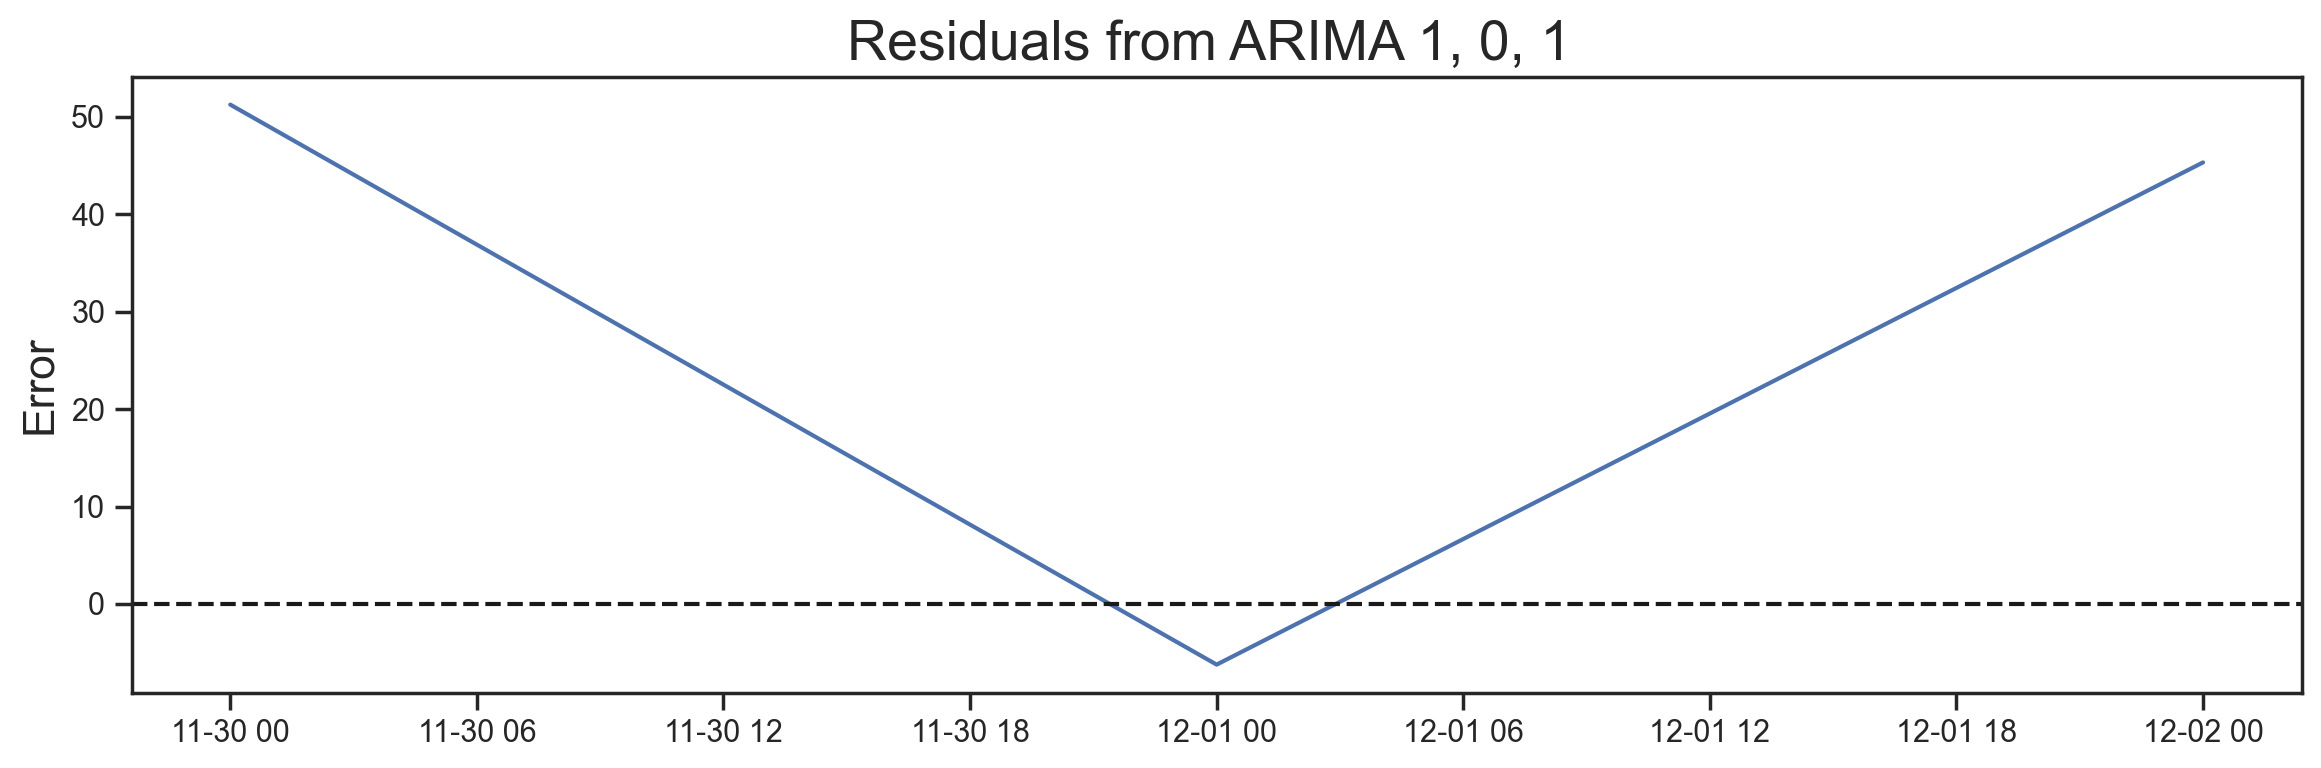

In [117]:
plt.figure(figsize=(14,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARIMA {}, {}, {} '.format(p,d,q), fontsize=20)
plt.ylabel('Error', fontsize=16)

<Figure size 1400x700 with 0 Axes>

Text(0.5, 1.0, 'Shifted -1 predictions ARIMA 1, 0, 1 ')

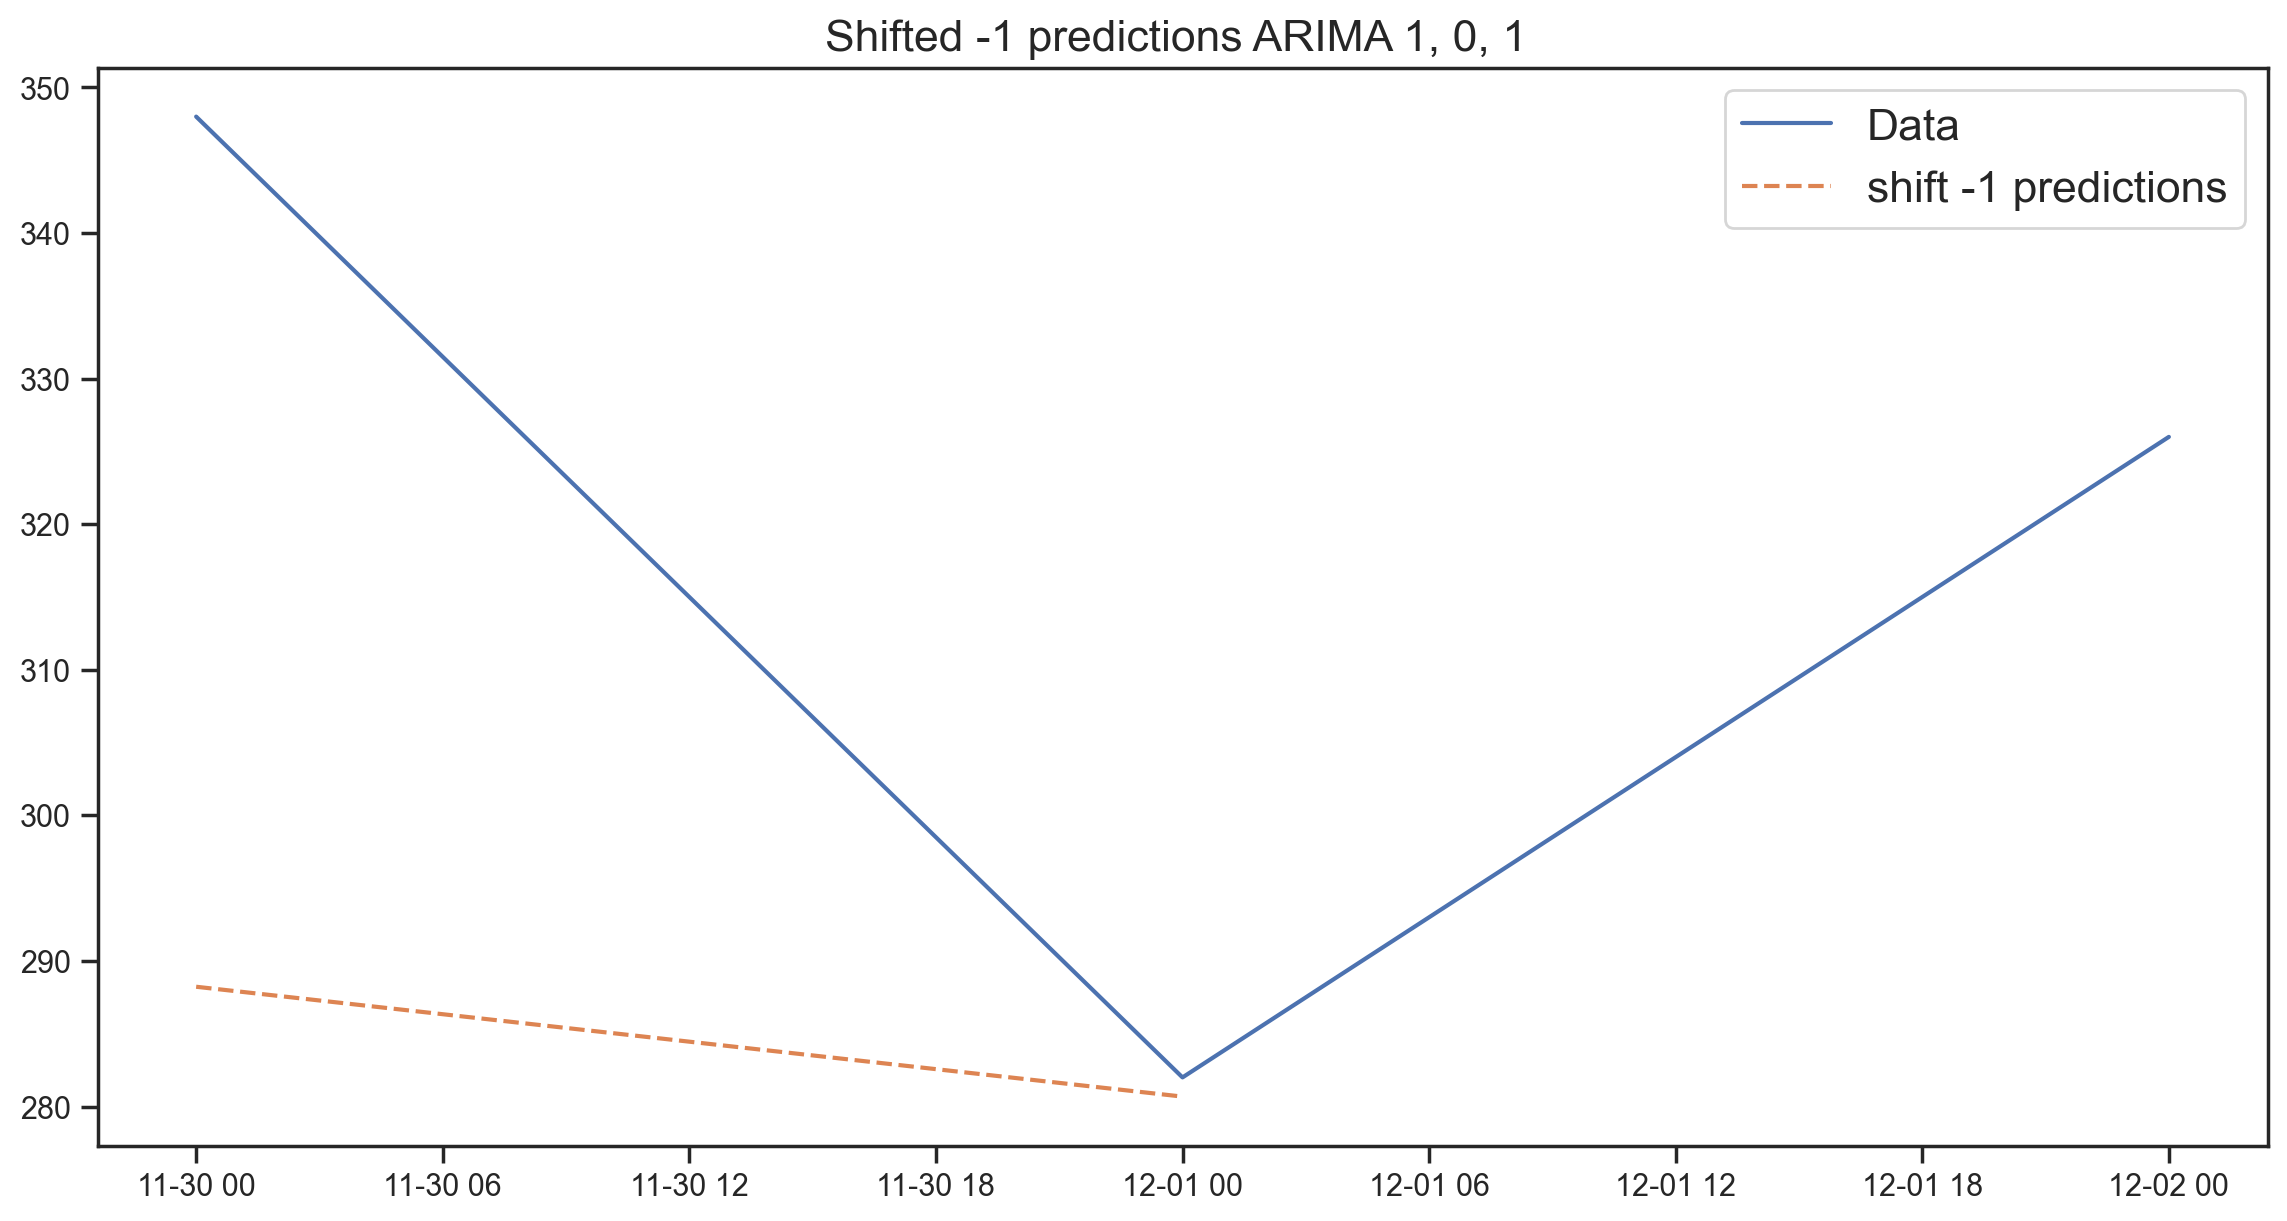

In [118]:
plt.figure(figsize=(14, 7))
plt.plot(test_data)
plt.plot(predictions.shift(-1) , '--')
plt.legend(('Data', 'shift -1 predictions'), fontsize=16)
plt.title("Shifted -1 predictions ARIMA {}, {}, {} ".format(p,d,q), fontsize=16)

<Figure size 1400x700 with 0 Axes>

Text(0.5, 1.0, 'ARIMA 1, 0, 1')

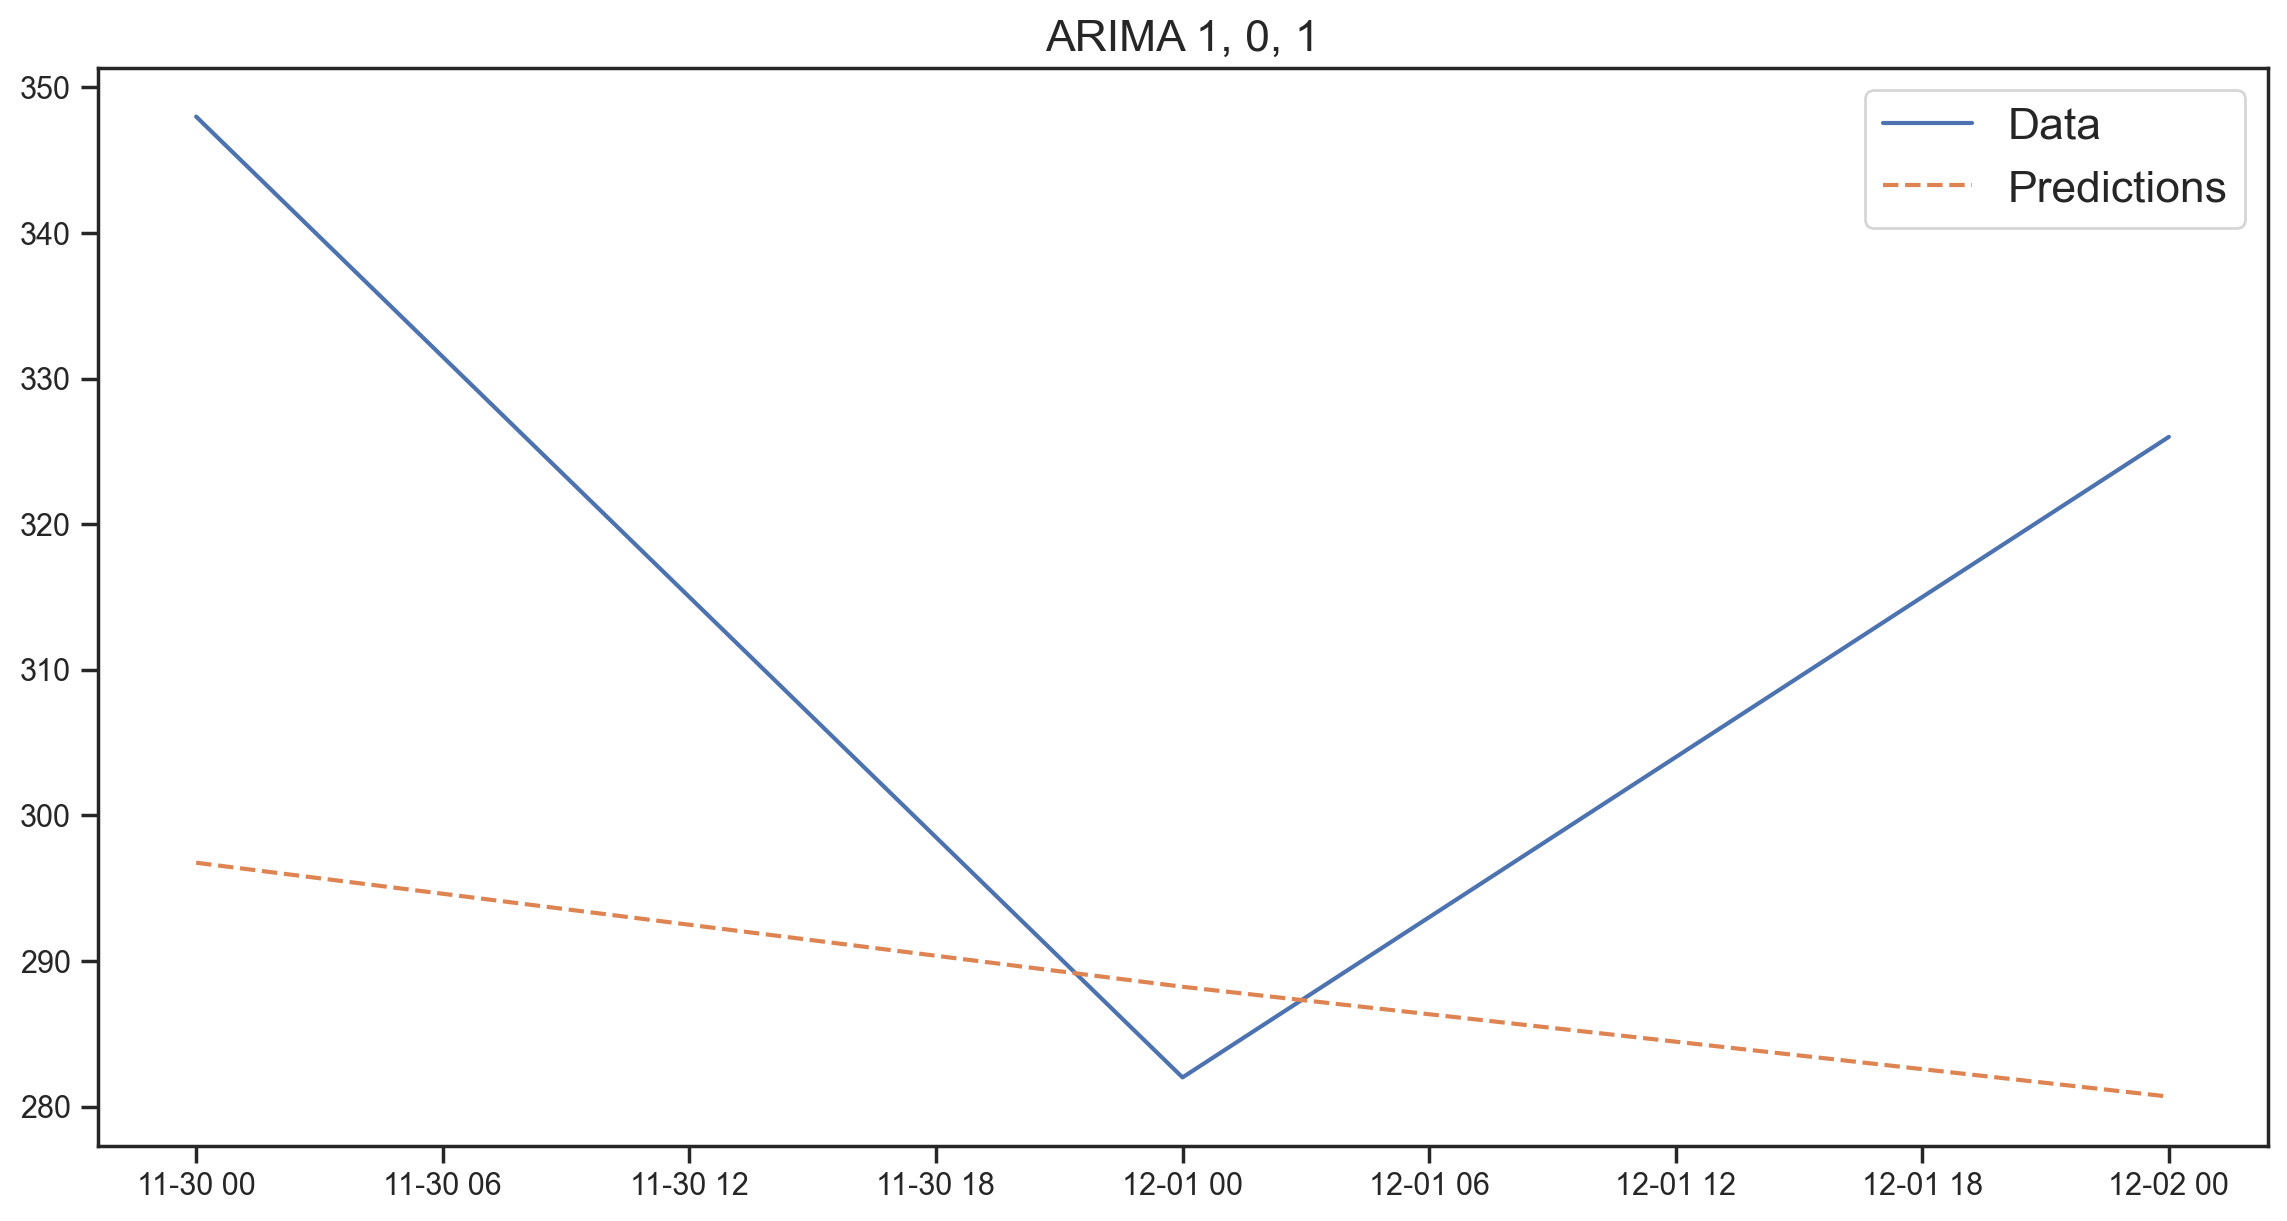

In [91]:
plt.figure(figsize=(14, 7))
plt.plot(test_data)
plt.plot(predictions, '--')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title("ARIMA {}, {}, {}".format(p,d,q), fontsize=16)

# Training ARIMA 1,1,1

In [69]:
train_end = datetime(2023, 11, 26)
test_end = datetime(2023, 12, 2)

train_data = df[:train_end]['AQI']
test_data = df[train_end + timedelta(days=1):test_end]['AQI']

p, d, q = (1, 1, 1)
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()
print("Model summary ", model_fit.summary())

Model summary                                 SARIMAX Results                                
Dep. Variable:                    AQI   No. Observations:                 1362
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7596.744
Date:                Mon, 04 Dec 2023   AIC                          15199.489
Time:                        21:31:43   BIC                          15215.137
Sample:                    03-05-2020   HQIC                         15205.347
                         - 11-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5815      0.026     22.138      0.000       0.530       0.633
ma.L1         -0.9049      0.013    -67.960      0.000      -0.931      -0.879
sigma2      4125.3413    109.596     

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [70]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
pred_start_date, pred_end_date

(Timestamp('2023-11-27 00:00:00'), Timestamp('2023-12-02 00:00:00'))

In [71]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date, typ='levels')
residuals = test_data - predictions

<Figure size 1400x700 with 0 Axes>

Text(0.5, 1.0, 'ARIMA 1, 1, 1')

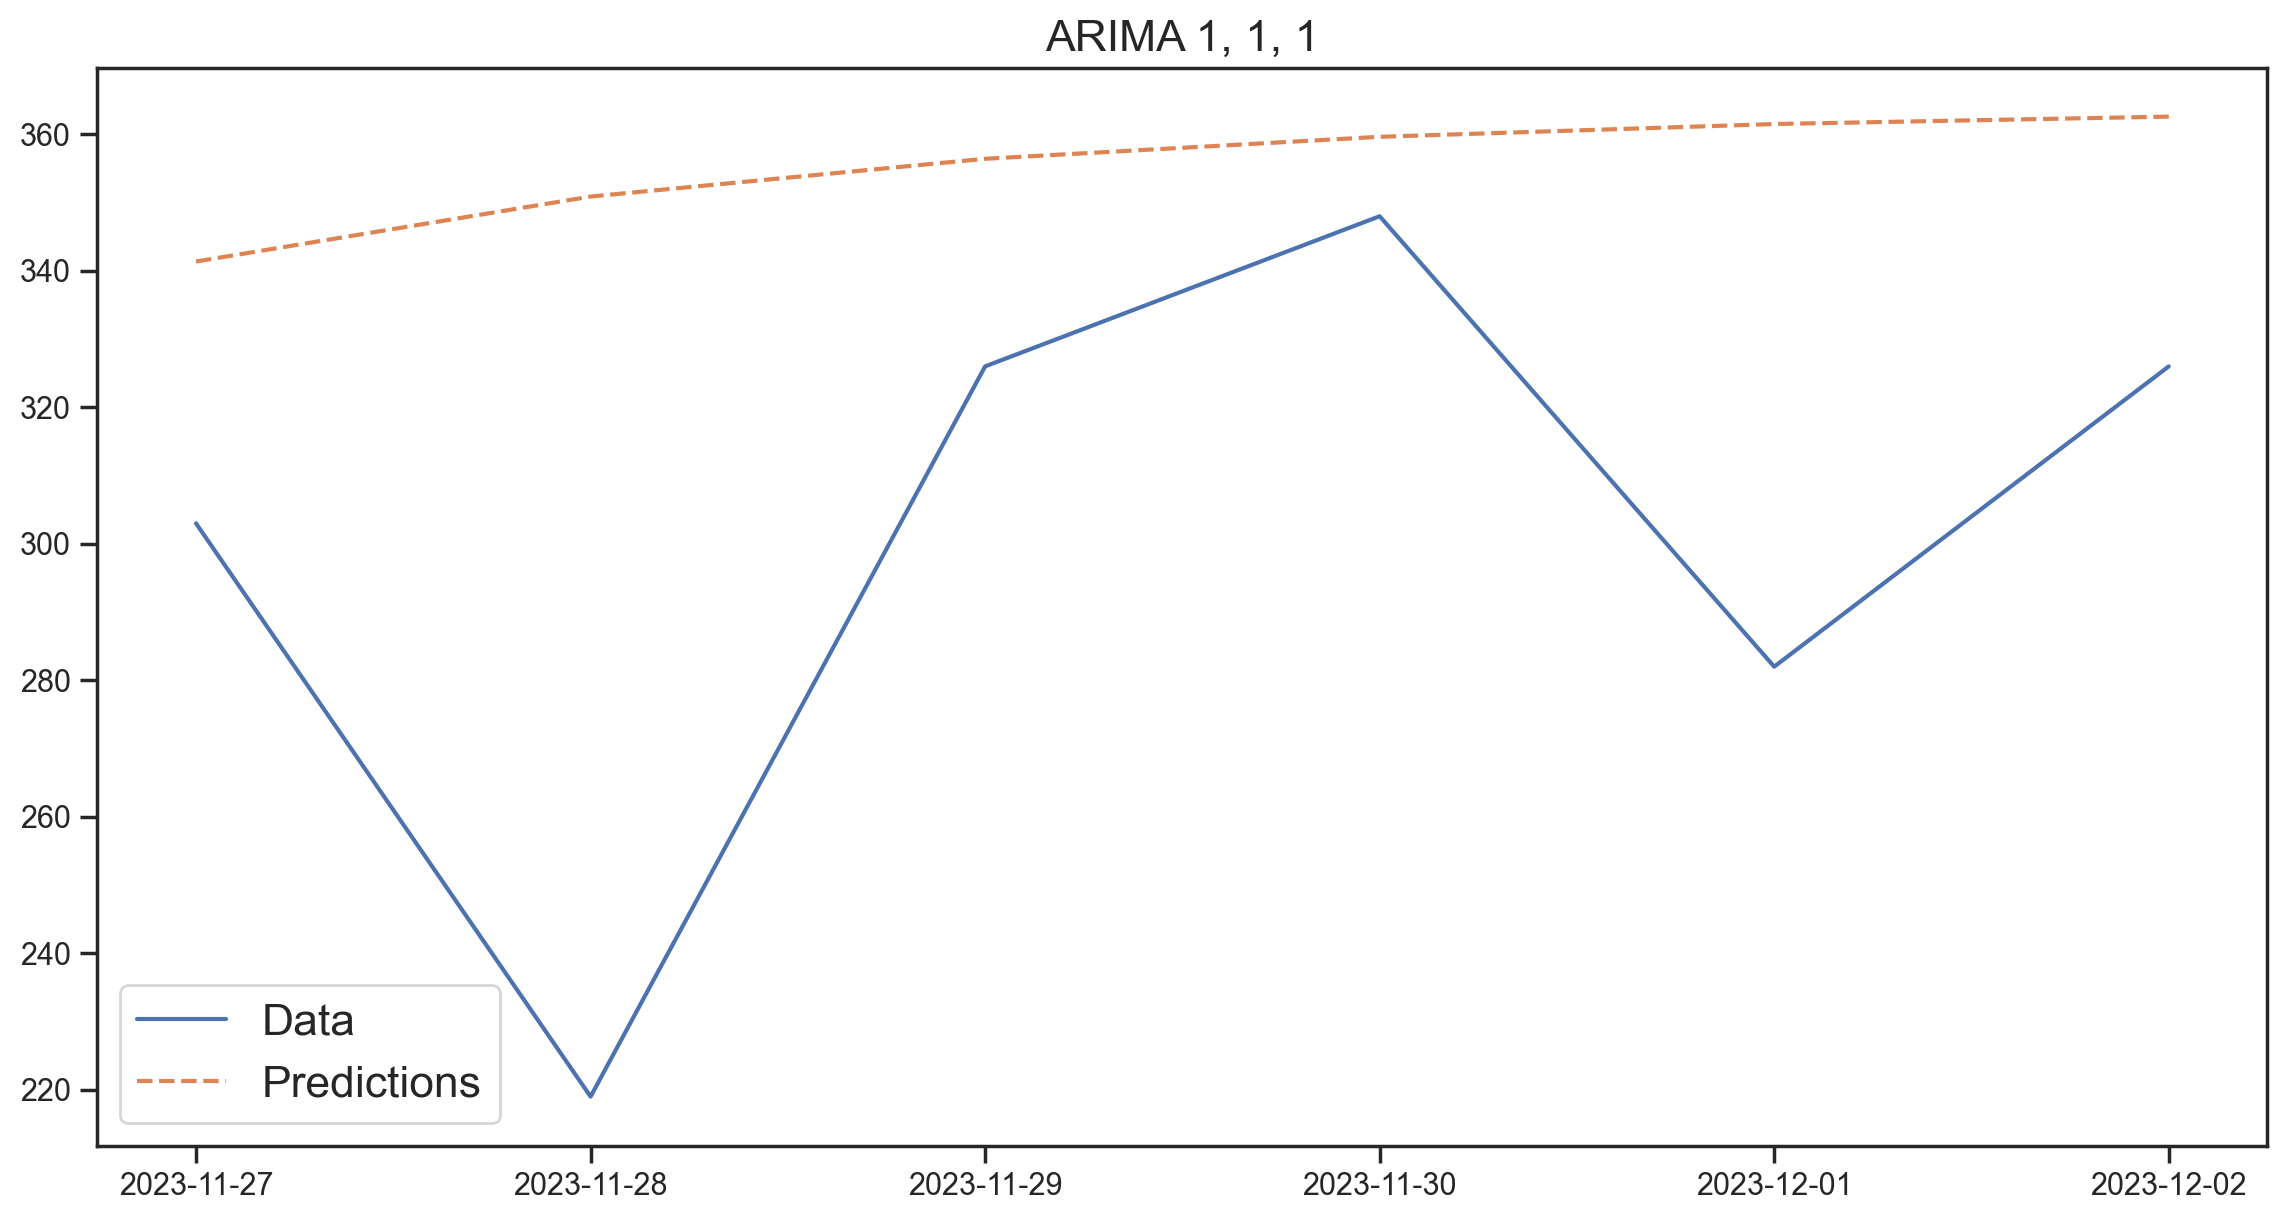

In [72]:
plt.figure(figsize=(14, 7))
plt.plot(test_data)
plt.plot(predictions, '--')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title("ARIMA {}, {}, {}".format(p,d,q), fontsize=16)

# SARIMAX (1, 0, 1) (1, 0, 1, 7)

In [128]:
train_end = datetime(2023, 11, 25)
test_end = datetime(2023, 12, 2)

train_data = df[:train_end]['AQI']
test_data = df[train_end + timedelta(days=1):test_end]['AQI']

my_order = (1,0,1)
my_seasonal_order = (1, 0, 1, 7) 
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()
print("Model summary ", model_fit.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70390D+00    |proj g|=  1.59741D-01

At iterate    5    f=  5.62351D+00    |proj g|=  6.81604D-04

At iterate   10    f=  5.62253D+00    |proj g|=  1.19673D-03

At iterate   15    f=  5.62172D+00    |proj g|=  1.14337D-02

At iterate   20    f=  5.61584D+00    |proj g|=  3.11932D-03

At iterate   25    f=  5.61415D+00    |proj g|=  4.30170D-03

At iterate   30    f=  5.61363D+00    |proj g|=  4.71992D-04

At iterate   35    f=  5.61350D+00    |proj g|=  1.19217D-03

At iterate   40    f=  5.61341D+00    |proj g|=  5.41876D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [129]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions
residuals

Date
2023-11-26    -6.888257
2023-11-27   -20.281869
2023-11-28   -98.231032
2023-11-29    21.897186
2023-11-30    46.876320
2023-12-01   -14.520634
2023-12-02    42.310683
dtype: float64

<Figure size 1400x700 with 0 Axes>

Text(0.5, 1.0, 'Sector 51 AQI daily SARIMAX(1, 0, 1)(1, 0, 1, 7)')

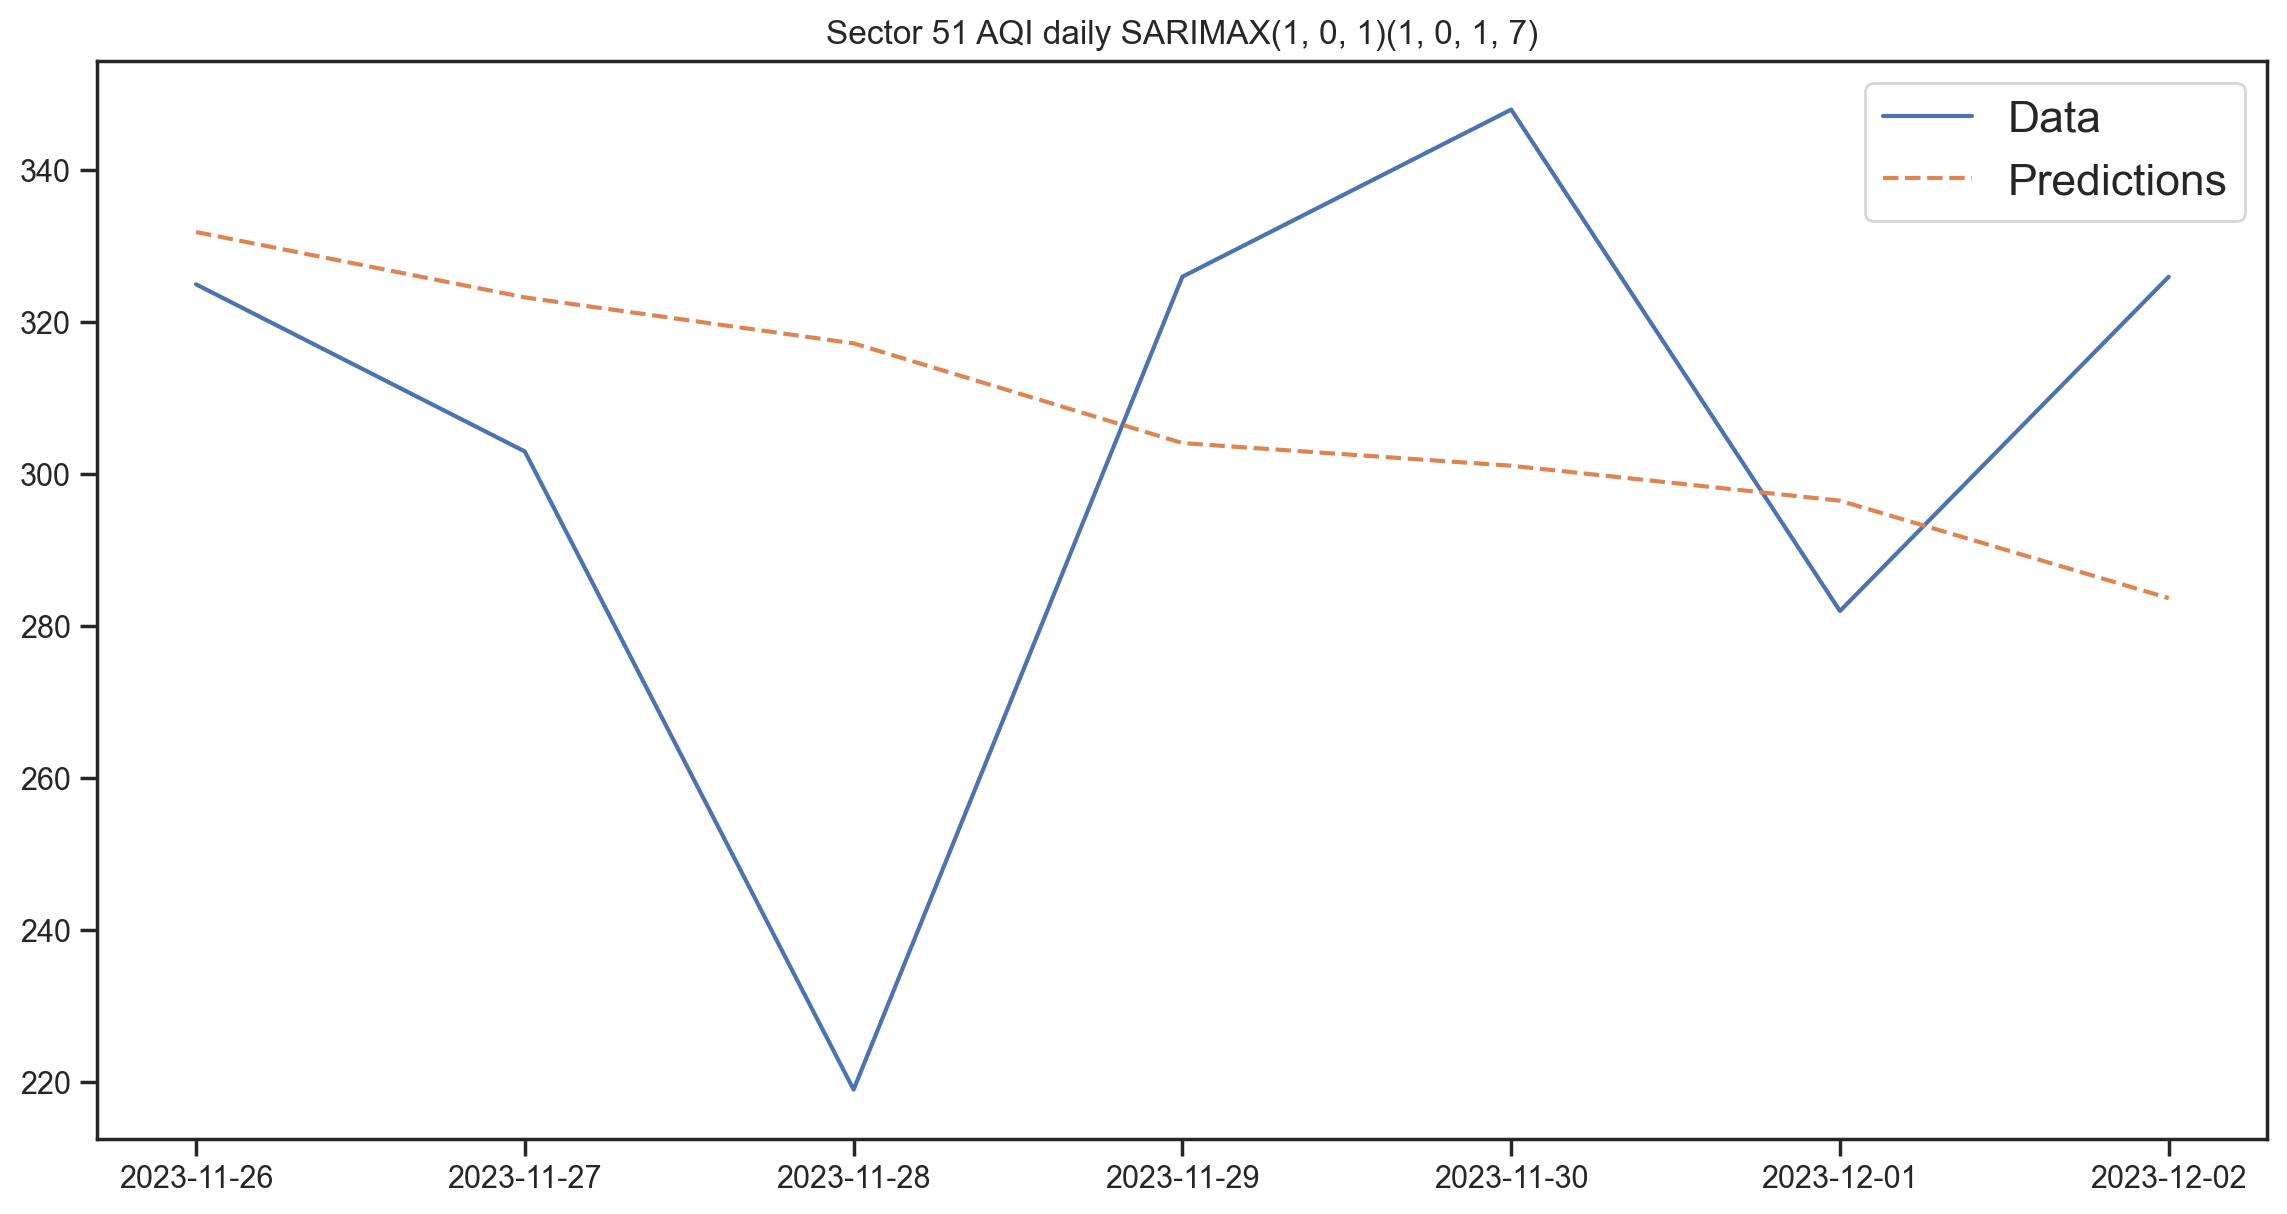

In [130]:
plt.figure(figsize=(14, 7))
plt.plot(test_data)
plt.plot(predictions, '--')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title("Sector 51 AQI daily SARIMAX" + str(my_order) + str(my_seasonal_order) )

In [134]:
np.sqrt(np.sum((test_data - predictions)**2)/len(test_data))

45.959697801564786

In [136]:
(np.sum(abs(test_data - predictions))/len(test_data))

35.857997299410115

In [133]:
model_fit.aic 

15289.709950194389

# SARIMAX 

In [140]:
train_end = datetime(2023, 11, 25)
test_end = datetime(2023, 12, 2)

train_data = df[:train_end]['AQI']
test_data = df[train_end + timedelta(days=1):test_end]['AQI']

my_order = (1,0,1)
my_seasonal_order = (1, 0, 1, 24) 
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()
print("Model summary ", model_fit.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67506D+00    |proj g|=  1.16045D-01

At iterate    5    f=  5.62230D+00    |proj g|=  7.18510D-04

At iterate   10    f=  5.62198D+00    |proj g|=  1.16179D-03

At iterate   15    f=  5.62196D+00    |proj g|=  9.86485D-04

At iterate   20    f=  5.62195D+00    |proj g|=  3.35362D-05

At iterate   25    f=  5.62188D+00    |proj g|=  7.93657D-04

At iterate   30    f=  5.62110D+00    |proj g|=  3.05506D-03

At iterate   35    f=  5.62050D+00    |proj g|=  1.24327D-03

At iterate   40    f=  5.61966D+00    |proj g|=  5.01061D-03

At iterate   45    f=  5.61945D+00    |proj g|=  3.99155D-04
  ys=-1.135E-05  -gs= 1.002E-05 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Model summary                                       SARIMAX Results                                      
Dep. Variable:                                AQI   No. Observations:                 1361
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood               -7648.068
Date:                            Tue, 05 Dec 2023   AIC                          15306.136
Time:                                    17:18:10   BIC                          15332.216
Sample:                                03-05-2020   HQIC                         15315.899
                                     - 11-25-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9447      0.008    112.441      0.000       0.928       0.961
ma.L1         -0.248

In [142]:
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions
residuals

Date
2023-11-26    -15.396584
2023-11-27    -33.075112
2023-11-28   -114.645057
2023-11-29      7.041115
2023-11-30     29.950936
2023-12-01    -25.228513
2023-12-02     27.035766
dtype: float64

<Figure size 1400x700 with 0 Axes>

Text(0.5, 1.0, 'Sector 51 AQI daily SARIMAX(1, 0, 1)(1, 0, 1, 24)')

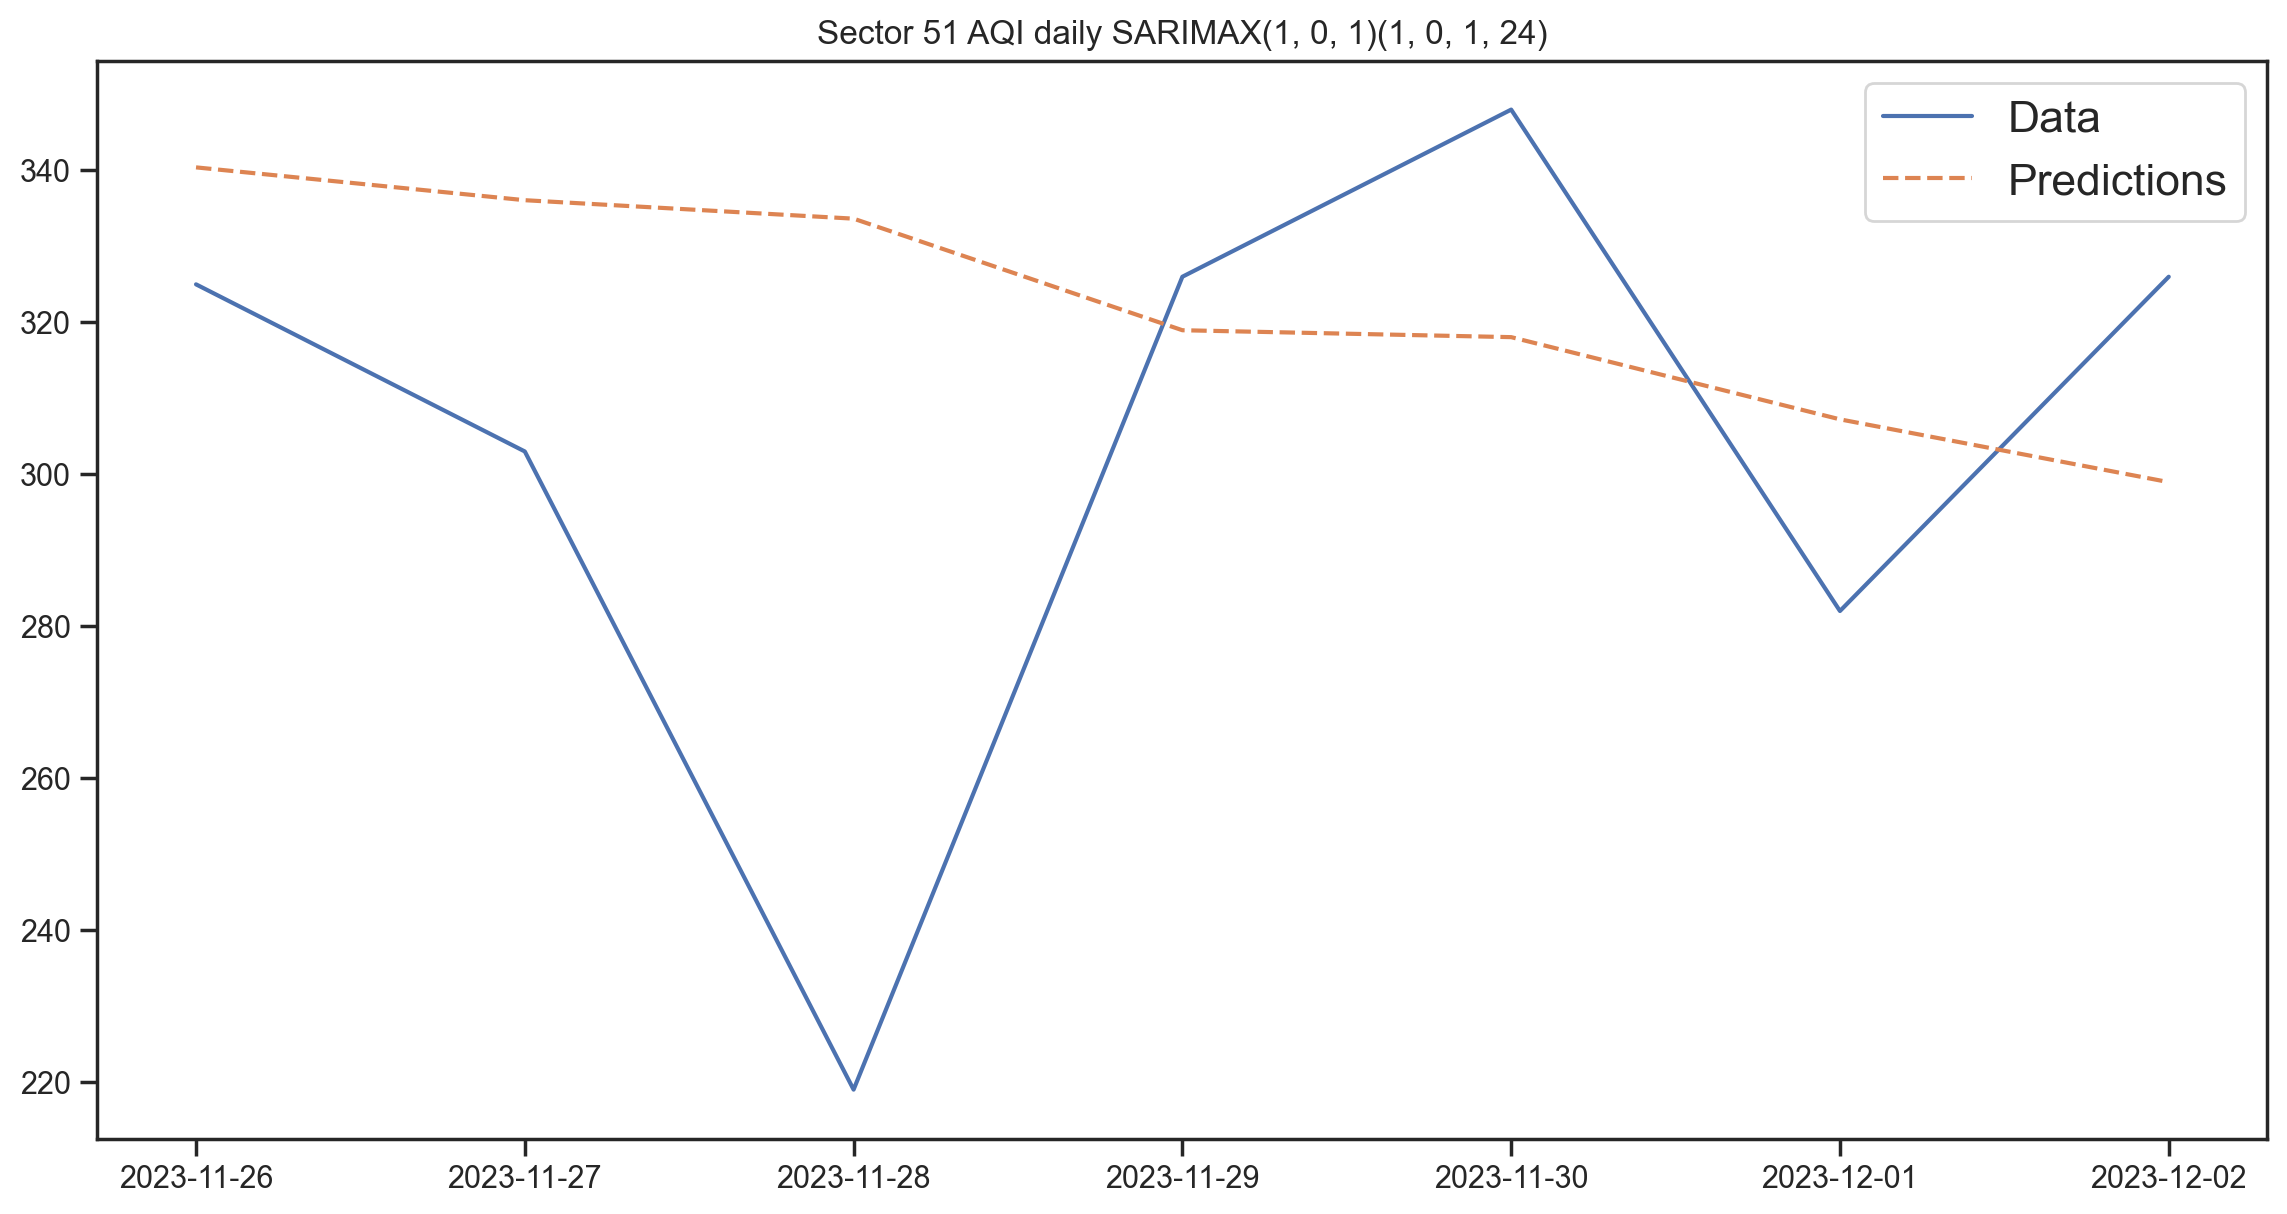

In [143]:
plt.figure(figsize=(14, 7))
plt.plot(test_data)
plt.plot(predictions, '--')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title("Sector 51 AQI daily SARIMAX" + str(my_order) + str(my_seasonal_order) )

In [141]:
(np.sum(abs(test_data - predictions))/len(test_data)) # "MAE_(1,0,1), (1,0,1,6)" = 35.77

35.77868282189337

In [144]:
(np.sum(abs(test_data - predictions))/len(test_data))  # "MAE_(1,0,1), (1,0,1,7)" = 36.05

36.053297661697066

In [145]:
model_fit.aic 

15306.135923799113

In [146]:
results

p  d  q        MSE Rolling?           AIC
0  1  0  1  16.803441     True  15327.189958